In [1]:
%load_ext pycodestyle_magic
%flake8_on
# la convention PEP8 est ainsi testée

Rédigé par Etienne Lardeur
2020, Projet 5 parcours Data Scientist - OpenClassrooms

# 1. Objectifs du projet

Nous cherchons à exploiter pour le compte d'Olist (solution de ventre sur les marketplaces en ligne), un historique de commande, afin de fournir aux équipes marketing une proposition de segmentation client. <br/>
<br/>
Le but est de :
- fournir une description de cette segmentation client dont l'équipe marketing pourra déduire des actions, 
- expliciter la logique sous-jacente, 
- vérifier les conditions de stabilité dans le temps des segments proposés et proposition de contrat de maintenance. <br/>

Le présent notebook détaille l'ensemble des étapes d'analyse des données et de construction (en créant des features dérivés), d'un dataset centré clients assortis de découpages temporels, en vue de réaliser des segmentations et tester leur stabilité.

# 2. Structure des données

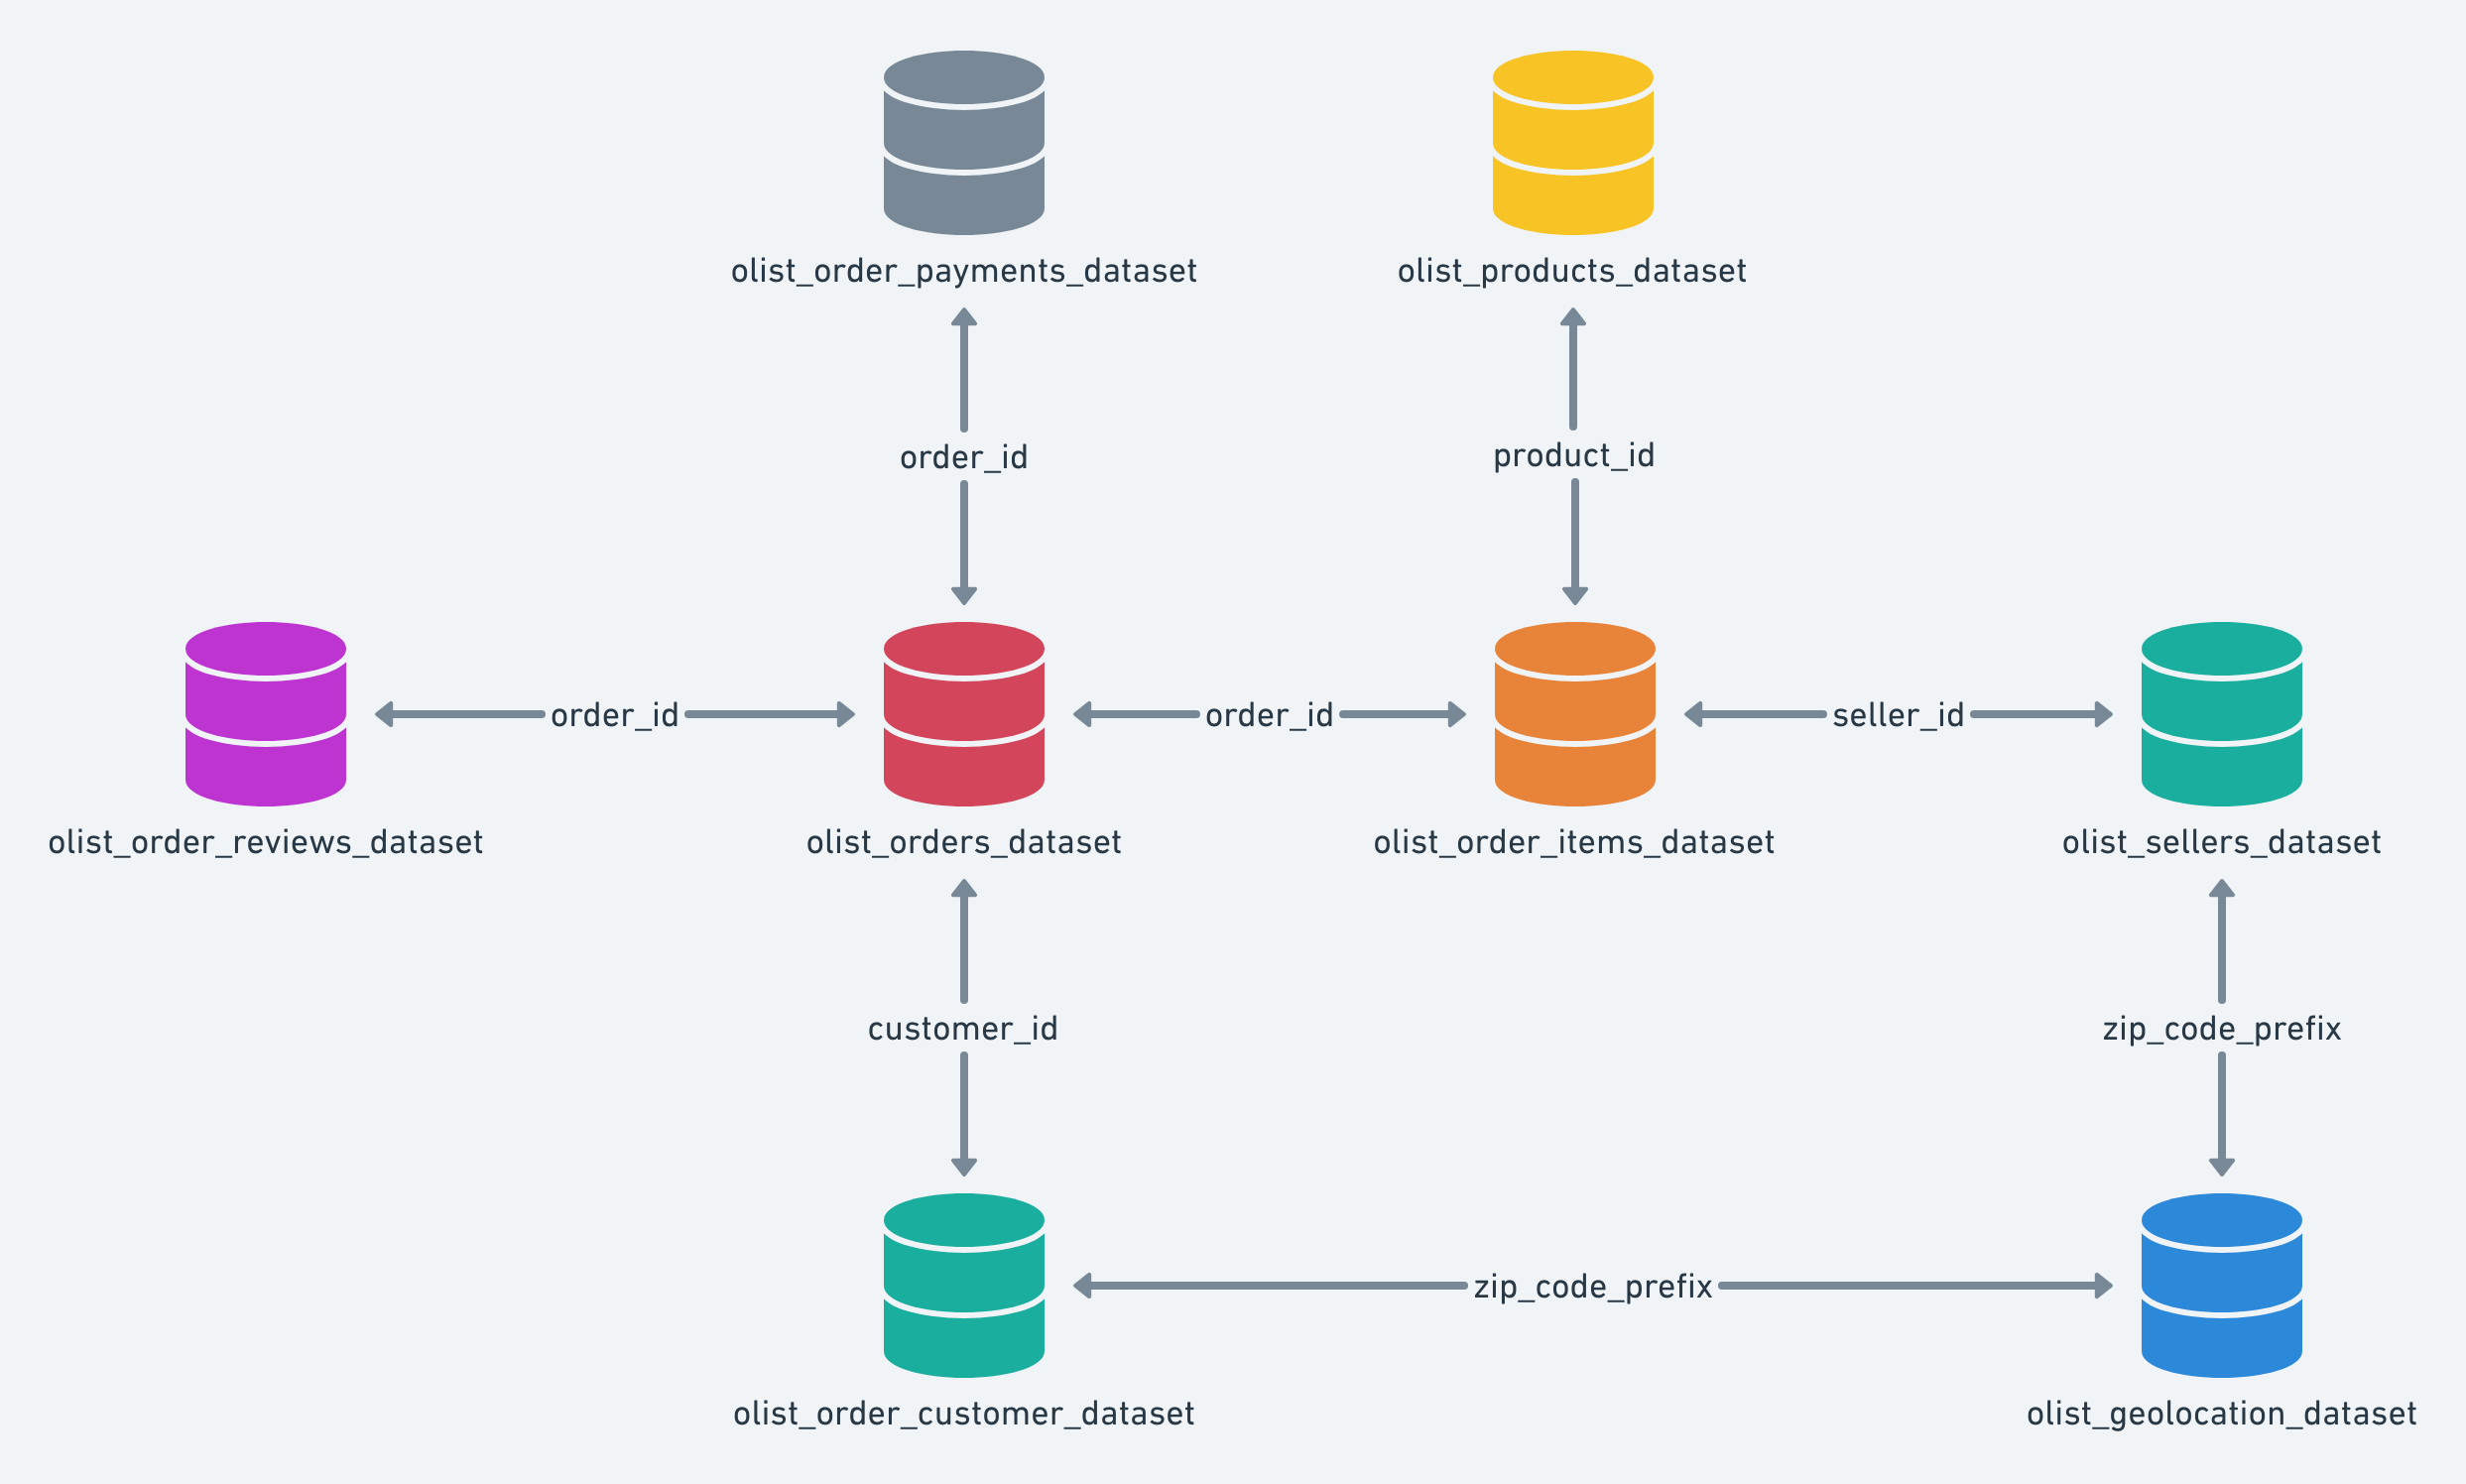

source {fig, datasets} : https://www.kaggle.com/olistbr/brazilian-ecommerce

Olist a mis a disposition les données sur Kaggle : y sont décrits les 8 datasets ainsi qu'un fichier product_category_name_translation. <br/>
Le schéma ci-dessus présente les datasets reliés par les clés indiquées.<br/>

En termes de cardinalités :
- les datasets sont fusionnables simplement avec une cardinalité 1:1 : cas de l'order_id depuis l'orders_dataset, mais également : customer_id, seller_id et product_id,
- un order est composé d'une liste de produits (1:n) via la notion d'items dans le datasets identifiant aussi le seller (1:1).
- un customerunique_id regroupe tous les customer_id associés en 1:1 à un order_id,
- le geolocation_dataset est associé via un zip_code_prefix, soit à un customer, soit à un seller. <br/>

Hors schéma, il reste une association simple des product_category_name en anglais qu'on exploitera pour une meilleure lisibilité.

In [1]:
%matplotlib inline
# importer les packages
# common
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.decomposition import PCA
# specific
from datetime import datetime
import time
# home made
import functions
from functions import distribution, charm_price, haversine, heatmap, rankgauss, scaled_rankgauss
# paramètres
sns.set(style="ticks")
sns.set_style('whitegrid')

In [3]:
# Pour afficher toutes les colonnes
pd.options.display.max_columns = 100

In [4]:
# créer les dataframes correspondants aux données
df_customers = pd.read_csv('Data/olist_customers_dataset.csv')
df_orders = pd.read_csv('Data/olist_orders_dataset.csv')
df_items = pd.read_csv('Data/olist_order_items_dataset.csv')
df_products = pd.read_csv('Data/olist_products_dataset.csv')
df_payments = pd.read_csv('Data/olist_order_payments_dataset.csv')
df_sellers = pd.read_csv('Data/olist_sellers_dataset.csv')
df_reviews = pd.read_csv('Data/olist_order_reviews_dataset.csv')
df_geolocation = pd.read_csv('Data/olist_geolocation_dataset.csv')
df_translation = pd.read_csv('Data/product_category_name_translation.csv')

In [5]:
# créer le dict des datasets
datasets = {
    'Orders': df_orders,
    'Items': df_items,
    'Customers': df_customers,
    'Payments': df_payments,
    'Products': df_products,
    'Sellers': df_sellers,
    'Reviews': df_reviews,
    'Geolocation': df_geolocation,
    'Translation': df_translation,
}

In [6]:
# observer les tailles des datasets
for x, y in datasets.items():
    print(f'{x} shape is : ' f'{list(y.shape)}')

Orders shape is : [99441, 8]
Items shape is : [112650, 7]
Customers shape is : [99441, 5]
Payments shape is : [103886, 5]
Products shape is : [32951, 9]
Sellers shape is : [3095, 4]
Reviews shape is : [100000, 7]
Geolocation shape is : [1000163, 5]
Translation shape is : [71, 2]


Les données de 100 000 Commandes environ ont été mises à disposition.

In [7]:
ref = df_orders.shape[0]

# 3. Pertinence du recentrage sur le Client
Au vu du but recherché le principe est de construire des features caractérisant le Client, i.e. d'aggréger des données synthétiques au Customer_unique_id.<br/>
Dans cette logique, il faut opérer la sélection et le traitement des informations à "remonter" vers le Client au fil des liens d'association et cardinalité successifs.<br/>
Nous allons d'abord observer le triptyque Commande - Article - Client et son "recentrage" sur le Client.

## 3.1. Aperçu des données Clients

In [8]:
# aperçu des données customers
df_customers.sample(3)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
92297,b5ef23001e4c334c545ae1520408f2b3,8ee43e65ed4d403459140984e43fef80,14077,ribeirao preto,SP
24634,1135ecbf1ddc0da7eb2f1f529cb46708,43c9959df2b196aa650b48eab5d1a411,14015,ribeirao preto,SP
23426,3d2f3aecac5b243372d17898c8fbac83,3e70cb9a49fa2d85f38fc392d17e4bab,84320,reserva,PR


In [9]:
# compter le nombre de clients
df_customers['customer_unique_id'].unique().size

96096

Les données sont anonymisées et sommaires : la localisation {ville, état} reliée à une {lat, lng} via un code, ainsi que le customer_unique_id qui  regroupe tous les customer_id eux-mêmes reliés aux order_id. 

In [10]:
# compter le nb d'achat par client
df_customers_purchase = df_customers.groupby(
    'customer_unique_id',
    as_index=False).agg({'customer_id': ['count']})
df_customers_purchase.columns = ['customer_unique_id',
                                 'order_count']

In [11]:
# afficher les 10 clients ayant effectué le plus de commandes
df_customers_purchase = df_customers_purchase.sort_values(by='order_count',
                                                          ascending=False)
df_customers_purchase[:10]

,customer_unique_id,order_count
52973,8d50f5eadf50201ccdcedfb9e2ac8455,17
23472,3e43e6105506432c953e165fb2acf44c,9
37797,6469f99c1f9dfae7733b25662e7f1782,7
76082,ca77025e7201e3b30c44b472ff346268,7
10354,1b6c7548a2a1f9037c1fd3ddfed95f33,7
7175,12f5d6e1cbf93dafd9dcc19095df0b3d,6
83540,de34b16117594161a6a89c50b289d35a,6
37585,63cfc61cee11cbe306bff5857d00bfe4,6
90451,f0e310a6839dce9de1638e0fe5ab282a,6
27043,47c1a3033b8b77b3ab6e109eb4d5fdf3,6


In [12]:
# moyenne des commandes par client
df_customers_purchase['order_count'].mean()

1.0348089410589412

In [13]:
# nombre de clients pour lesquels on détient l'information de 2 achats ou plus
df_customers_purchase[df_customers_purchase['order_count'] > 1].shape

(2997, 2)

In [14]:
# pourcentage des clients multi-acheteurs
print(round(100 *
            df_customers_purchase[df_customers_purchase['order_count'] >
                                  1].shape[0] /
            df_customers_purchase.shape[0], 2)) 

3.12


In [15]:
# aggréger le nb d'achats effectués pour chaque client unique
df_customers = df_customers.merge(
    df_customers_purchase,
    how='left',
    left_on=['customer_unique_id'],
    right_on=['customer_unique_id'])

In [16]:
# observer le résultat
df_customers.sample(3)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_count
34099,98dfe650b52959127ab18d7c8b1da221,9bb2aefabf7d7dee2dcc022bd1277ecf,12245,sao jose dos campos,SP,1
4135,0bfe96ed9f807da029472429981cfa99,18f8e0ebb3ee98e9f3805f92c3ff7431,19300,presidente bernardes,SP,1
87083,ea4b8b06045d157d4c93c1336a63dea9,84bda1bb7cd0c9902b41bf43e840ede9,20530,rio de janeiro,RJ,1


## 3.2. Limitation des données
Nous constatons seulement 3 % d'acheteurs récurrents dans les données mises à disposition. <br/>
L'application de la méthode de segmentation RFM (Récence, Fréquence, Montant) est très largement compromise par cette troncature des données. 
En effet, en termes de segmentation, si des commandes ont été retirées pour la majorité des clients on retrouvera logiquement un groupe de clients étant fictivement les seuls à avoir réalisé plusieurs achats (Fréquence). <br/>
Par ailleurs, l'analyse de l'intervalle entre 2 achats risque de ne pas être représentative au moins quantitativement (Fréquence). <br/>
Enfin, le découpage dans le temps sans données longitudinales rend caduque la notion d'ancienneté client (Récence). <br/>

## 3.3. Aggrégation sur la Commande
Nous nous efforcerons donc de produire pour le marketing une caractéristation "directe" d'un nouveau client, en limitant autant que possible le biais d'une nouvelle troncature de donnée, selon la façon de retenir une commande unique par client (ex. la dernière commande effectuée, le produit le plus cher, etc.). <br/>

In [17]:
# contrôler les données manquantes
df_customers.isna().sum()

customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
order_count                 0
dtype: int64

# 4. La Commande au centre des données

In [18]:
# aperçu des données orders
df_orders.head(3)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00


La Commande est bien le centre initial et privilégié des données : elle permet de remonter aux Produits et aux Vendeurs via la notion d'Article (Item, qui représente le panier acheté). Elle est reliée directement aux Clients, aux Paiements et aux Avis. <br/>
Le processus pour chaque commande est détaillé (order_status et dates associées), à commencer par la date et l'heure d'achat. <br/>
Ces données temporelles permettent d'appréhender la période couverte et d'étudier la stabilité de la segmentation. <br/>
Nous passons en revue les éléments de la commande et des données reliées, susceptibles de caractériser le Client.

## 4.1. Order Status : filtrer les Commandes échues

In [19]:
# lister les valeurs possibles de l'order_status
df_orders['order_status'].unique()

array(['delivered', 'invoiced', 'shipped', 'processing', 'unavailable',
       'canceled', 'created', 'approved'], dtype=object)

Text(0.5, 1.02, 'Order Status')

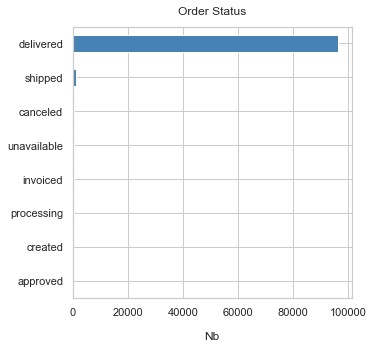

In [20]:
# observer la répartition des commandes par status
df_orders['order_status'].value_counts().plot(
    kind='barh',
    color='steelblue',
    figsize=(5, 5)).invert_yaxis()
plt.xlabel('Nb', labelpad=14)
plt.title('Order Status', y=1.02)

On choisit de retirer les commandes "en cours" et retirer les commandes non disponibles ou annulées (qui peuvent faire l'objet d'une attention client spécifique).

In [21]:
# retirer les commandes en cours
df_orders = df_orders[df_orders['order_status'] == 'delivered']
print(df_orders.shape)

(96478, 8)


In [22]:
# détecter les valeurs manquantes
df_orders.isna().sum()

order_id                          0
customer_id                       0
order_status                      0
order_purchase_timestamp          0
order_approved_at                14
order_delivered_carrier_date      2
order_delivered_customer_date     8
order_estimated_delivery_date     0
dtype: int64

In [23]:
# retirer les valeurs manquantes et controler la taille résultante
df_orders = df_orders.dropna().copy()
print(df_orders.shape)

(96455, 8)


In [24]:
print(ref-df_orders.shape[0])

2986


## 4.2. Order process : exploiter les dates de Commande
Le processus de commande va permettre d'observer les volumes de commandes sur la période mise à disposition.

In [25]:
# s'assurer du format des informations dates
for col in ['order_purchase_timestamp',
            'order_approved_at',
            'order_delivered_carrier_date',
            'order_delivered_customer_date',
            'order_estimated_delivery_date']:
    df_orders[col] = pd.to_datetime(df_orders[col],
                                    format='%Y-%m-%d %H:%M:%S')

In [26]:
# décomposer la date d'achat en donnée année, mois, jour, heure
df_orders['order_purchase_year'] =\
    df_orders.order_purchase_timestamp.apply(lambda x: x.year)
df_orders['order_purchase_month'] =\
    df_orders.order_purchase_timestamp.apply(lambda x: x.month)
df_orders['order_purchase_day'] =\
    df_orders.order_purchase_timestamp.apply(lambda x: x.day)
df_orders['order_purchase_dayofweek'] =\
    df_orders.order_purchase_timestamp.apply(lambda x: x.dayofweek)
df_orders['order_purchase_hour'] =\
    df_orders.order_purchase_timestamp.apply(lambda x: x.hour)
# identifier par son libellé, le moi et le jour de la semaine
df_orders['order_purchase_month_label'] =\
    df_orders.order_purchase_month.map({1: 'Jan',
                                        2: 'Feb',
                                        3: 'Mar',
                                        4: 'Apr',
                                        5: 'May',
                                        6: 'Jun',
                                        7: 'Jul',
                                        8: 'Aug',
                                        9: 'Sep',
                                        10: 'Oct',
                                        11: 'Nov',
                                        12: 'Dec'})
df_orders['order_purchase_dayofweek_label'] =\
    df_orders.order_purchase_dayofweek.map({0: 'Mon',
                                            1: 'Tue',
                                            2: 'Wed',
                                            3: 'Thu',
                                            4: 'Fri',
                                            5: 'Sat',
                                            6: 'Sun'})

### 4.2.1. Commandes mensuelles au cours du temps

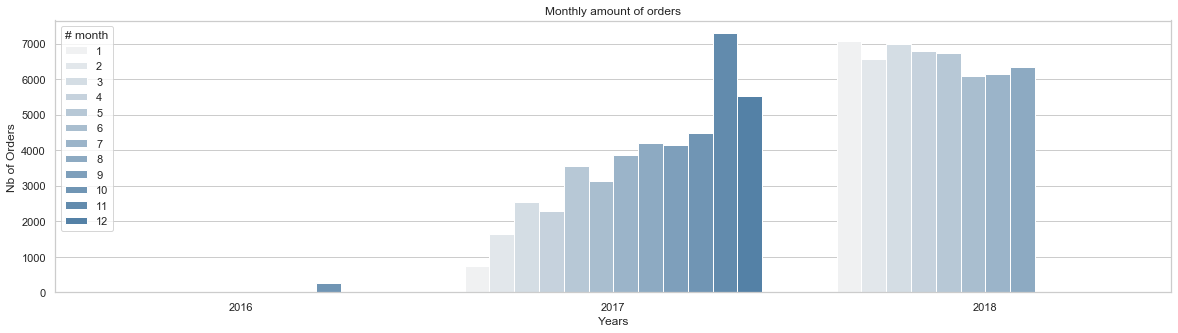

In [27]:
# afficher l'évolution des commandes
plt.figure(figsize=(20, 5))
ax = sns.countplot(x='order_purchase_year',
                   hue='order_purchase_month',
                   data=df_orders,
                   color='Steelblue')
ax.set(xlabel='Years',
       ylabel='Nb of Orders',
       title='Monthly amount of orders')
plt.legend(title='# month', loc='upper left')
plt.show()

Nous disposons à compter de Janvier 2018, d'une quantité de commande stable jusqu'au mois d'Aout 2018. Les 13 mois qui précèdent montrent une augmentation monotone à l'exception d'un probable surnombre de commandes en Novembre 2017. <br/>
Nous pouvons envisager de construire une segmentation sur la période 2017 et tester sa stabilité en injectant un par un les 8 mois suivants. <br/>

In [28]:
df_orders.sample(3)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_purchase_year,order_purchase_month,order_purchase_day,order_purchase_dayofweek,order_purchase_hour,order_purchase_month_label,order_purchase_dayofweek_label
81479,677b75c94abaf28f434d9f1be4c12808,9533ca0dba01ab4d0a841b397616813d,delivered,2018-08-14 22:28:42,2018-08-14 22:44:02,2018-08-16 13:41:00,2018-08-17 14:38:39,2018-08-20,2018,8,14,1,22,Aug,Tue
49899,5065ad433fb01b8ee48433c8ce6c6be9,679b6663d92f901171c7d9544094fbc3,delivered,2018-03-02 21:15:46,2018-03-02 21:30:29,2018-03-06 01:56:24,2018-03-14 22:59:31,2018-03-20,2018,3,2,4,21,Mar,Fri
67691,bcdd99725db7d4c2fd9468f0fcf3cfa1,ec44c35c1f4142d89e506f87f9ffc183,delivered,2018-02-16 22:02:09,2018-02-17 01:27:01,2018-02-23 19:07:47,2018-03-03 10:32:10,2018-03-06,2018,2,16,4,22,Feb,Fri


In [29]:
# créer / actualiser les commandes réparties par année
orders_2017 = df_orders[(df_orders['order_purchase_year'] == 2017) |
                        (df_orders['order_purchase_year'] == 2016)]
orders_2018 = df_orders[(df_orders['order_purchase_year'] == 2018)]

On observe donc deux périodes : la période transitoire "2017" qui correspond à une montée en charge, et la période stabilisée "2018".
Du fait de la troncature manifestement opérée sur les données, la transition ou la stabilité peuvent être mises en doute.

### 4.2.2. Moment d'achat

Nous allons observer les commandes au fil des jours du mois et au fil de la semaine :<br/>
Le Client pouvant être caractérisé par le moment privilégié de la journée, de la semaine ou du mois où il effectue ses achats.<br/>

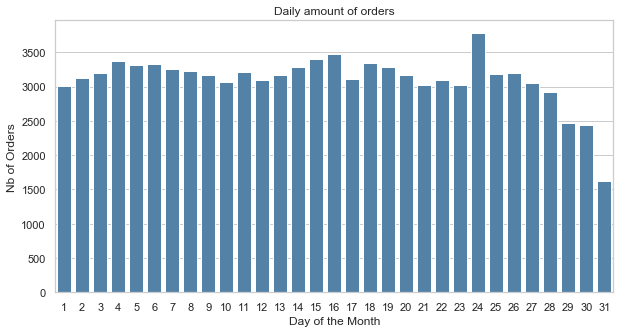

In [30]:
# afficher l'évolution des commandes selon les jours du mois (en cumul)
plt.figure(figsize=(10, 5))
ax = sns.countplot(x='order_purchase_day',
                   data=df_orders,
                   color='Steelblue')
ax.set(xlabel='Day of the Month',
       ylabel='Nb of Orders',
       title='Daily amount of orders')
plt.show()

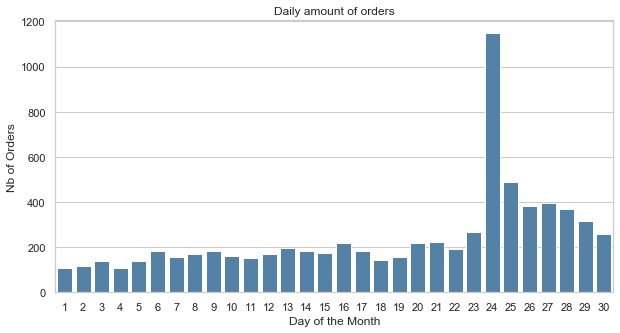

In [31]:
# confirmer le pic de commandes 11/2017
plt.figure(figsize=(10, 5))
ax = sns.countplot(x='order_purchase_day',
                   data=df_orders[(df_orders['order_purchase_year'] == 2017) &
                                  (df_orders['order_purchase_month'] == 11)],
                   color='Steelblue')
ax.set(xlabel='Day of the Month',
       ylabel='Nb of Orders',
       title='Daily amount of orders')
plt.show()

Excepté le 24 novembre 2017, nous ne constatons pas de grande variation et le plus faible nombre de commandes constatées un 31ème jour du mois est trivial.

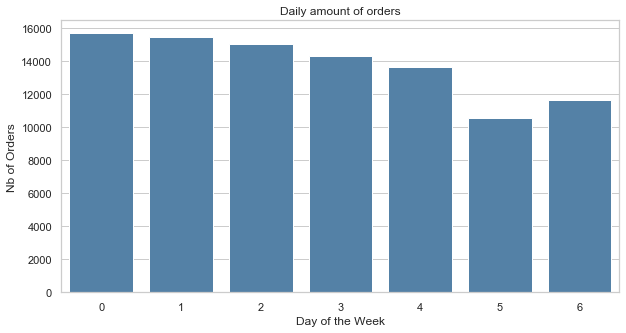

In [32]:
# afficher l'évolution des commandes selon les jours de la semaine
plt.figure(figsize=(10, 5))
ax = sns.countplot(x='order_purchase_dayofweek',
                   data=df_orders,
                   color='Steelblue')
ax.set(xlabel='Day of the Week',
       ylabel='Nb of Orders',
       title='Daily amount of orders')
plt.show()

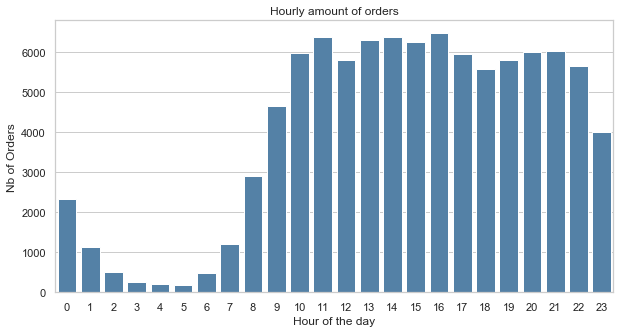

In [33]:
# afficher l'évolution des commandes selon les heures de la journée
plt.figure(figsize=(10, 5))
ax = sns.countplot(x='order_purchase_hour',
                   data=df_orders,
                   color='Steelblue')
ax.set(xlabel='Hour of the day',
       ylabel='Nb of Orders',
       title='Hourly amount of orders')
plt.show()

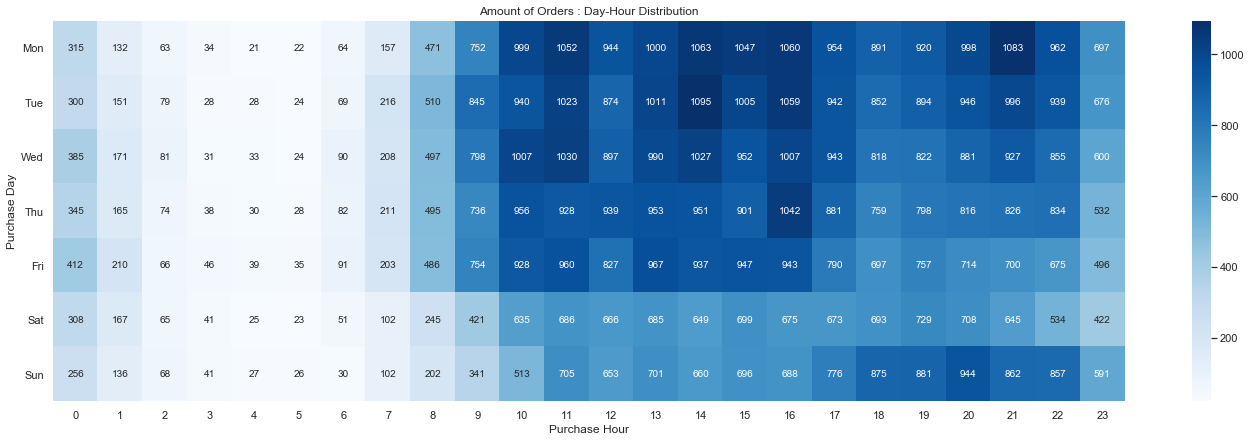

In [34]:
# afficher la répartition des commandes par heure et jour d'achat
order_count = df_orders.groupby(['order_purchase_dayofweek',
                                 'order_purchase_hour'])\
    .count()['order_id'].unstack()
plt.figure(figsize=(24, 7))
ax = sns.heatmap(order_count, cmap='Blues', annot=True, fmt='d')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
ax.set(xlabel='Purchase Hour',
       ylabel='Purchase Day',
       yticklabels=(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']),
       title='Amount of Orders : Day-Hour Distribution')
for item in ax.get_yticklabels():
    item.set_rotation(0)
plt.show()

Nous obtenons des périodes d'une heure pour lesquelles la quantité de commande peut varier de quelques unités à plus d'un millier (en cumul sur près de 2 ans) : nous dégageons des zones temporelles.

### 4.2.3. Découpage du moment d'achat en zone temporelles

Pour effectuer ce découpage, nous nous appuyons sur la visualisation des décomptes par heure - jour qu'offre une clustermap, c'est à dire une heatmap dont les données sont organisées à partir d'un clustering hiérarchique.
Après test les différentes méthodes de clustering et métriques de calcul des distances (lorsqu'elles sont viables) présentent des résultats similaires.

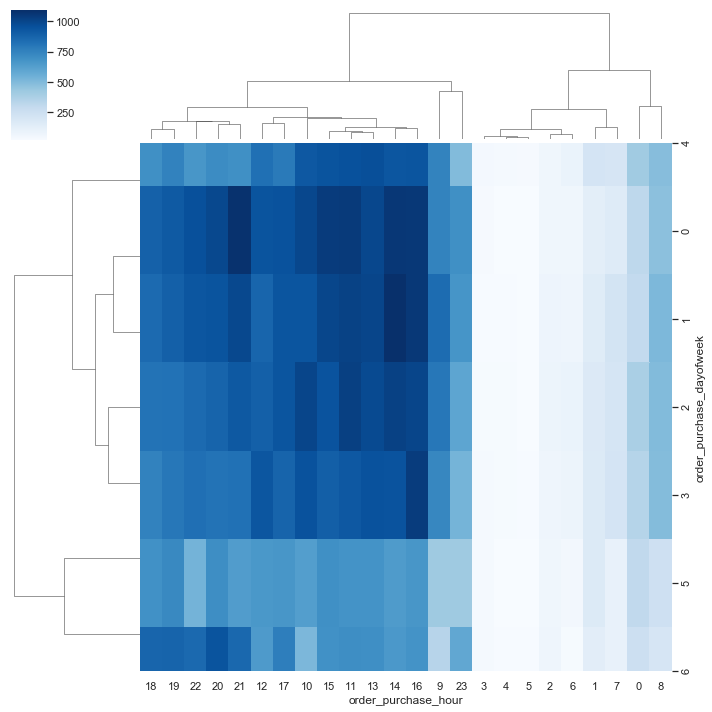

In [35]:
# afficher une clustermap pour définir les zones temporelles
sns.clustermap(order_count, cmap='Blues', method='median', metric='euclidean')
plt.show()

Le clustering fait apparaitre très clairement le découpage Working-Day / Week-End, ainsi que Day - Night. <br/>
On observe une distinctionpour 9h et 23h, mais qui ont moins de sens à être dissociés que l'usuelle distinction Day-Evening qui apparait juste après. <br/>

Il y a deux niveaux de compromis possibles, selon qu'on aménage ou non une distinction AM - PM qui a l'avantage de répartir les effectifs de commandes de manière plus équitable et d'être facilement actionnable / interprétable pour des visées marketing.

On retient dans ce cas 4 à 5 time zones :
- "Night", creuse quelque soit le jour de la semaine, couvrant la période [0h-8h],
- "WE", week-end,
- "Day" [9h-17h] et "Evening-WD" [18h-23h],
- en coupant "Day" par la distinction usuelle "AM" [9h-12h] et "PM" [13h-17h].


In [36]:
# distinguer nuit, am, pm, evening
df_orders['time_zone_hour'] =\
    df_orders.order_purchase_hour.map({0: 'Night',
                                       1: 'Night',
                                       2: 'Night',
                                       3: 'Night',
                                       4: 'Night',
                                       5: 'Night',
                                       6: 'Night',
                                       7: 'Night',
                                       8: 'AM',
                                       9: 'AM',
                                       10: 'AM',
                                       11: 'AM',
                                       12: 'AM',
                                       13: 'PM',
                                       14: 'PM',
                                       15: 'PM',
                                       16: 'PM',
                                       17: 'PM',
                                       18: 'Evening',
                                       19: 'Evening',
                                       20: 'Evening',
                                       21: 'Evening',
                                       22: 'Evening',
                                       23: 'Evening'})

In [37]:
# distinguer week et week-end
df_orders['time_zone_day'] =\
    df_orders.order_purchase_dayofweek.map({0: 'WD',
                                            1: 'WD',
                                            2: 'WD',
                                            3: 'WD',
                                            4: 'WD',
                                            5: 'WE',
                                            6: 'WE'})

In [38]:
# construire les 3 zones WD : AM, PM et Evening
df_orders['purchase_time_zone_cat'] = df_orders['time_zone_hour'] + '-' + df_orders['time_zone_day']

In [39]:
# construire la time zone WE
df_orders['purchase_time_zone_cat'][df_orders['time_zone_day'] == 'WE'] = 'WE'

C:\Users\etien\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [40]:
# construire la time zone Night
df_orders['purchase_time_zone_cat'][df_orders['time_zone_hour'] == 'Night'] = 'Night'

C:\Users\etien\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [41]:
# contrôler la liste de time zone construites
df_orders['purchase_time_zone_cat'].unique()

array(['AM-WD', 'Evening-WD', 'WE', 'PM-WD', 'Night'], dtype=object)

Text(0.5, 1.02, 'Purchase Time Zones')

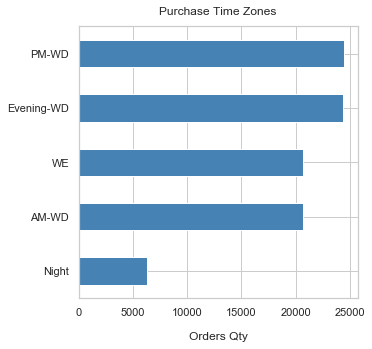

In [42]:
# observer la répartition des commandes par purchase_time_zone
df_orders['purchase_time_zone_cat'].value_counts().plot(
    kind='barh',
    color='steelblue',
    figsize=(5, 5)).invert_yaxis()
plt.xlabel('Orders Qty', labelpad=14)
plt.title('Purchase Time Zones', y=1.02)

In [43]:
df_orders.sample(3)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_purchase_year,order_purchase_month,order_purchase_day,order_purchase_dayofweek,order_purchase_hour,order_purchase_month_label,order_purchase_dayofweek_label,time_zone_hour,time_zone_day,purchase_time_zone_cat
35912,5ca29c3c00080a507890c89a0323f06d,e3e55fa35f62eea2d859f98e2317e80f,delivered,2017-06-07 08:47:46,2017-06-07 09:02:13,2017-06-13 16:03:02,2017-06-21 17:15:46,2017-06-30,2017,6,7,2,8,Jun,Wed,AM,WD,AM-WD
46183,2a15d40da6accb25c550b694fdf84478,2b141f94788b2cced0125f3159a92aed,delivered,2018-04-19 21:29:39,2018-04-19 21:50:14,2018-04-20 19:04:59,2018-04-23 16:23:38,2018-05-07,2018,4,19,3,21,Apr,Thu,Evening,WD,Evening-WD
86538,6ed234c648ccdf0be691d96c9aecbd34,0435f56ca2461ef676149d29d9f0b5d4,delivered,2018-01-31 16:10:02,2018-02-01 16:15:09,2018-02-06 22:22:13,2018-02-09 18:19:51,2018-02-16,2018,1,31,2,16,Jan,Wed,PM,WD,PM-WD


### 4.2.4. Délais de livraison et retard

Le comportement futur du client, et plus directement le review score qu'il donnera à réception de l'article, peut être affecté par l'écart de date de livraison effective / estimée et dans une moindre mesure par le délai d'approbation de sa commande (ce dernier est réduit et standard et ne sera donc pas considéré à ce stade).<br/>

In [44]:
# calculer le délai de livraison annoncé
df_orders['estimated_delivery_time'] =\
    (df_orders['order_estimated_delivery_date'] -
     df_orders['order_purchase_timestamp']).dt.days

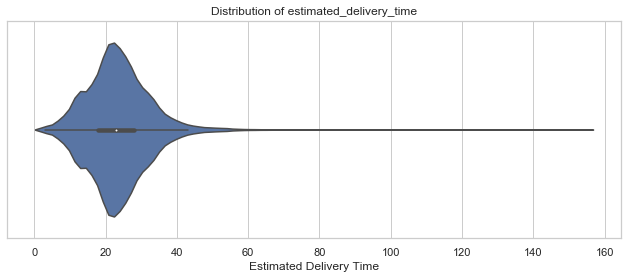

Délai moyen de livraison annoncé en jours : 23


In [45]:
# afficher la distribution de délais de livraison estimé / annoncé
distribution(df_orders,
             'estimated_delivery_time',
             'Estimated Delivery Time',
             'violin')
print('Délai moyen de livraison annoncé en jours : ' +
      str(round(df_orders['estimated_delivery_time'].mean())))

On observe des délais annoncés extrêmes. Le processus de commande n'est plus nominal, comme c'est le cas par exemple pour des articles en rupture de stock, où le délai estimé est forcément erroné si les délais de fabrication ne sont pas maîtrisés.

In [46]:
# calculer le délai de livraison effectif
df_orders['effective_delivery_time'] =\
    (df_orders['order_delivered_customer_date'] -
     df_orders['order_purchase_timestamp']).dt.days

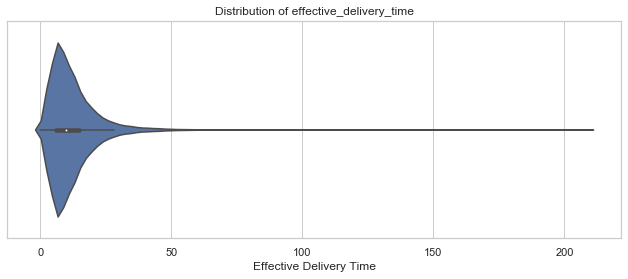

Délai moyen effectif de livraison en jours : 12


In [47]:
# afficher la distribution des délais de livraison effectif
distribution(df_orders,
             'effective_delivery_time',
             'Effective Delivery Time',
             'violin')
print('Délai moyen effectif de livraison en jours : ' +
      str(round(df_orders['effective_delivery_time'].mean())))

In [48]:
# nombre de livraison sous 24h
df_orders[df_orders['effective_delivery_time'] == 0].shape

(13, 20)

In [49]:
# calculer l'écart entre la livraison réelle et prévue (en jours d'avance)
df_orders['delivery_vs_estimated'] =\
    (df_orders['order_estimated_delivery_date'] -
     df_orders['order_delivered_customer_date']).dt.days

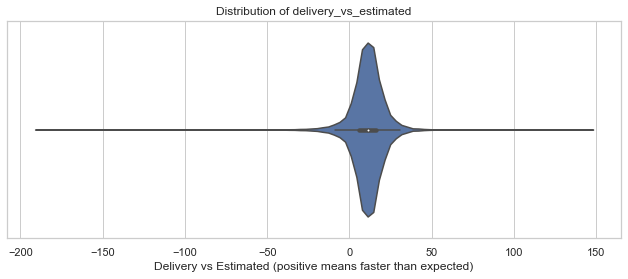

Ecart moyen entre le délai de livraison effective et estimé : 11


In [50]:
# afficher la distribution de l'écart de délai de livraison
distribution(df_orders,
             'delivery_vs_estimated',
             'Delivery vs Estimated (positive means faster than expected)',
             'violin')
print('Ecart moyen entre le délai de livraison effective et estimé : ' +
      str(round(df_orders['delivery_vs_estimated'].mean())))

Les clients reçoivent en général leur commande 11 jours avant la date estimée, qui est de fait estimée au delà des délais nominaux de préparation - expédition - transport - livraison. 

Bien que le client ne le "sache" pas, le délai qui lui est annoncé est régulièrement honoré à la moitié ou presque, ou à l'inverse, on lui annonce en moyenne le double du délai que prendrait réellement la livraison en moyenne. <br/>
Cela implique de construire une indication corrigée de l'écart de délai de livraison, et par exemple considérer l'écart de livraison par rapport à la valeur moyenne. <br/>

In [51]:
# créer / actualiser les commandes répartes par année
orders_2017 = df_orders[(df_orders['order_purchase_year'] == 2017) |
                        (df_orders['order_purchase_year'] == 2016)]
orders_2018 = df_orders[(df_orders['order_purchase_year'] == 2018)]

In [52]:
# observer la variation éventuelle entre 2017 et 2018
print('Variation delivery_vs_estimated entre 2017 (ref) et 2018 : ' +
      str(round(orders_2017['delivery_vs_estimated'].mean() - orders_2018['delivery_vs_estimated'].mean())))

Variation delivery_vs_estimated entre 2017 (ref) et 2018 : 1


Les cas extrêmes observés produise des situations incohérentent qui remettent en cause la fiabilité de la date annoncé. <br/>
Ils portent sur une faible quantité de commandes. <br/>
On décide de filtrer sur la base du délai estimé, en vertu du principe qu'il n'est pas maîtrisé dans ce cas (délai de fabrication) et qu'il fera l'objet d'un suivi spécifique.

In [53]:
# calcul du 99ème percentile pour le délai estimé
np.percentile(df_orders['estimated_delivery_time'], 99)

50.0

In [54]:
# contrôler la quantité d'outliers considérés
df_orders[df_orders['estimated_delivery_time'] >= 50].shape

(1001, 21)

In [55]:
# calcul du 99ème percentile pour le délai effectif
np.percentile(df_orders['effective_delivery_time'], 99)

46.0

In [56]:
# contrôler la quantité d'outliers considérés
df_orders[df_orders['effective_delivery_time'] >= 45].shape

(1091, 21)

In [57]:
# retirer les outliers
df_orders = df_orders[df_orders['estimated_delivery_time'] < 50]
df_orders = df_orders[df_orders['effective_delivery_time'] < 45]

In [58]:
# contrôler le nb de commandes
df_orders.shape

(94422, 21)

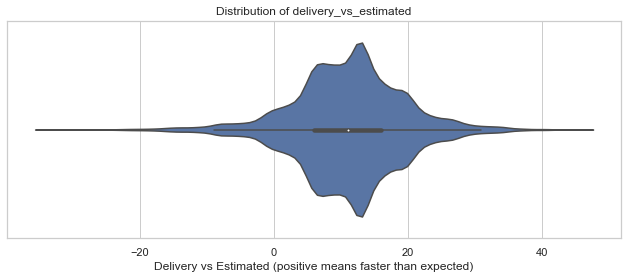

Ecart moyen entre le délai de livraison effective et estimé : 11


In [59]:
# afficher la distribution de l'écart de délai de livraison
distribution(df_orders,
             'delivery_vs_estimated',
             'Delivery vs Estimated (positive means faster than expected)',
             'violin')
print('Ecart moyen entre le délai de livraison effective et estimé : ' +
      str(round(df_orders['delivery_vs_estimated'].mean())))

Au vu de cette répartition, on opte pour une séparation en 3 : nominal, sooner and later.

In [60]:
df_orders['delivery_vs_estimated_lvl'] = pd.qcut(
    df_orders['delivery_vs_estimated'],
    3,
    labels=['Later_Delivery',
            'Nominal_Delivery',
            'Sooner_Delivery'])

Text(0.5, 1.02, 'Delivery Delay Levels')

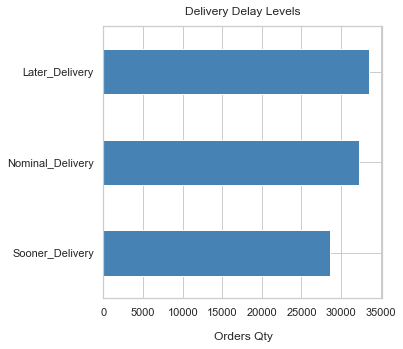

In [61]:
# observer la répartition des retard ou avance de livraison
df_orders['delivery_vs_estimated_lvl'].value_counts().plot(
    kind='barh',
    color='steelblue',
    figsize=(5, 5)).invert_yaxis()
plt.xlabel('Orders Qty', labelpad=14)
plt.title('Delivery Delay Levels', y=1.02)

In [62]:
# retirer les valeurs manquantes et controler la taille résultante
df_orders = df_orders.dropna().copy()
print(df_orders.shape)

(94422, 22)


In [63]:
# retirer les colonnes obsolètes
df_orders = df_orders.drop(
    columns=['order_status',
             'order_approved_at',
             'order_delivered_carrier_date',
             'order_delivered_customer_date',
             'order_estimated_delivery_date'])

In [64]:
# aperçu des données orders
df_orders.head(3)

,order_id,customer_id,order_purchase_timestamp,order_purchase_year,order_purchase_month,order_purchase_day,order_purchase_dayofweek,order_purchase_hour,order_purchase_month_label,order_purchase_dayofweek_label,time_zone_hour,time_zone_day,purchase_time_zone_cat,estimated_delivery_time,effective_delivery_time,delivery_vs_estimated,delivery_vs_estimated_lvl
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,2017,10,2,0,10,Oct,Mon,AM,WD,AM-WD,15,8,7,Later_Delivery
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-24 20:41:37,2018,7,24,1,20,Jul,Tue,Evening,WD,Evening-WD,19,13,5,Later_Delivery
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,2018-08-08 08:38:49,2018,8,8,2,8,Aug,Wed,AM,WD,AM-WD,26,9,17,Sooner_Delivery


# 5. Les articles (Items & Products)

Le dataset items relie la commande (order) aux produits (products) : il détaille le "panier" d'articles commandés, et pour lesquels sont définis le vendeur, le prix, le coût de livraison, une éventuelle date limite d'envoi.<br/>
Tandis que le dataset Products définis les caractéristiques unitaires de catégorie, taille, poids et description de l'article. <br/>
On retrouve la quantité achetée car les produits sont listés unitairement.

## 5.1. Items (articles d'un panier)

In [65]:
# aperçu des données Items
df_items.sample(3)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
90712,ce0102221c8d12a97979c74d09cca282,1,8338cef8355d238f43711dcb9c0657b2,cca3071e3e9bb7d12640c9fbe2301306,2017-06-02 04:03:05,45.9,15.10
53822,7a5b3f682886d750ce6eae941ad0d793,1,2b849e71ada03a262ef4338a7abd8b79,f8db351d8c4c4c22c6835c19a46f01b0,2018-06-15 17:58:48,104.9,12.07
109340,f87b019430922741706698256b753421,1,962a6951154f98f2c8e9a5b8b2bcf4a9,1025f0e2d44d7041d6cf58b6550e0bfa,2018-05-16 22:55:58,75.0,14.48


La date limite d'envoi est une information attachée au panier complétant les délais renseignés, le délai d'envoi varie peu et sera ignoré.

In [66]:
# ordonner les articles par prix décroissants
df_items = df_items.sort_values(by=['order_id', 'price'],
                                ascending=False)

In [67]:
# compter le nb d'articles par commande
df_items_count = df_items.groupby(
    'order_id',
    as_index=False).agg({'order_item_id': ['max'],
                         'product_id': ['nunique']})
df_items_count.columns = ['order_id',
                          'items_qty',
                          'products_qty']

In [68]:
# nombre de commandes uniques
df_items_count.shape

(98666, 3)

In [69]:
# afficher les 3 commandes avec le plus d'articles
df_items_count = df_items_count.sort_values(by='items_qty',
                                            ascending=False)
df_items_count[:3]

,order_id,items_qty,products_qty
50137,8272b63d03f5f79c56e9e4120aec44ef,21,3
10459,1b15974a0141d54e36626dca3fdc731a,20,1
65715,ab14fdcfbe524636d65ee38360e22ce8,20,1


In [70]:
#  quantités d'articles et nb d'articles différents et pourcentages
print('nb articles en moyenne par commande  : ' +
      str(round(df_items_count['items_qty'].mean(), 2)))
print('nb articles différents en moyenne par commande  : ' +
      str(round(df_items_count['products_qty'].mean(), 2)))
print('pourcentage de commandes avec 2 articles ou plus  : ' +
      str(round(100 *
                df_items_count[df_items_count['items_qty'] > 1].shape[0] /
                df_items_count.shape[0], 2)))
print('pourcentage de commandes avec 2 produits différents ou plus  : ' +
      str(round(100 *
                df_items_count[df_items_count['products_qty'] > 1].shape[0] /
                df_items_count.shape[0], 2)))

nb articles en moyenne par commande  : 1.14
nb articles différents en moyenne par commande  : 1.04
pourcentage de commandes avec 2 articles ou plus  : 9.94
pourcentage de commandes avec 2 produits différents ou plus  : 3.28


In [71]:
# scruter les commandes avec les plus grandes quantité d'articles
df_items[df_items['order_id'] == '8272b63d03f5f79c56e9e4120aec44ef']

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
57317,8272b63d03f5f79c56e9e4120aec44ef,21,79ce45dbc2ea29b22b5a261bbb7b7ee7,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,7.8,6.57
57297,8272b63d03f5f79c56e9e4120aec44ef,1,270516a3f41dc035aa87d220228f844c,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57298,8272b63d03f5f79c56e9e4120aec44ef,2,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57299,8272b63d03f5f79c56e9e4120aec44ef,3,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57300,8272b63d03f5f79c56e9e4120aec44ef,4,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57301,8272b63d03f5f79c56e9e4120aec44ef,5,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57302,8272b63d03f5f79c56e9e4120aec44ef,6,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57303,8272b63d03f5f79c56e9e4120aec44ef,7,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57304,8272b63d03f5f79c56e9e4120aec44ef,8,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57305,8272b63d03f5f79c56e9e4120aec44ef,9,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89


In [72]:
df_items[df_items['order_id'] == '00143d0f86d6fbd9f9b38ab440ac16f5']

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
32,00143d0f86d6fbd9f9b38ab440ac16f5,1,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,2017-10-20 16:07:52,21.33,15.1
33,00143d0f86d6fbd9f9b38ab440ac16f5,2,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,2017-10-20 16:07:52,21.33,15.1
34,00143d0f86d6fbd9f9b38ab440ac16f5,3,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,2017-10-20 16:07:52,21.33,15.1


Il s'agit de quantités élevées d'un nombre réduit d'articles différent, ce qui tend à indiquer que c'est la nature du produit qui implique d'en commander une plus grande quantité, au contraire d'une diversité d'articles dans le panier de commande. <br/>
C'est un effet probable de la troncature des données.

On observe que le coût de livraison semble s'ajouter pour chaque produit contrairement à ce qu'on imagine dans la réalité. <br/>
C'est lié à la répartition d'un coût de livraison calculé (f(taille, poids)) et réparti sur les items de la commande.

In [73]:
# nombre de commandes pour lesquelles il y 2 articles différents ou plus
df_items_count[df_items_count['products_qty'] > 1].shape

(3236, 3)

In [74]:
# dériver en un feature catégoriel les single_product ou multi_product (2 et +)
df_items_count['products_qty'] =\
    df_items_count['products_qty'].map(
    lambda x: 'multi_products' if x >= 2 else 'single_product')
# dériver en un feature catégoriel les single_item ou multi_item (2 et +)
df_items_count['items_qty'] =\
    df_items_count['items_qty'].map(
    lambda x: 'multi_items' if x >= 2 else 'single_item')

Text(0.5, 1.02, 'Single vs multi-products balance')

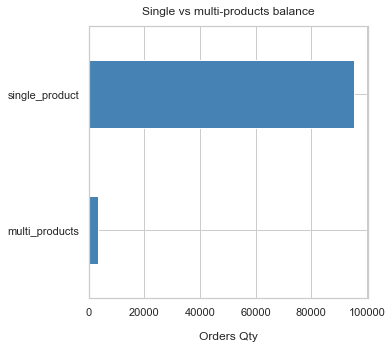

In [75]:
# observer la répartition des single et multi_product
df_items_count['products_qty'].value_counts().plot(
    kind='barh',
    color='steelblue',
    figsize=(5, 5)).invert_yaxis()
plt.xlabel('Orders Qty', labelpad=14)
plt.title('Single vs multi-products balance', y=1.02)

Text(0.5, 1.02, 'Single vs multi-items balance')

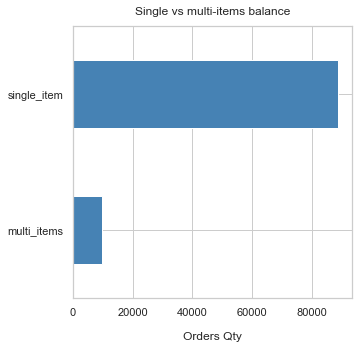

In [76]:
# observer la répartition des single et multi_item
df_items_count['items_qty'].value_counts().plot(
    kind='barh',
    color='steelblue',
    figsize=(5, 5)).invert_yaxis()
plt.xlabel('Orders Qty', labelpad=14)
plt.title('Single vs multi-items balance', y=1.02)

In [77]:
# aggréger aux commandes le nb d'articles
df_orders = df_orders.merge(
    df_items_count,
    how='left',
    left_on=['order_id'],
    right_on=['order_id'])

In [78]:
df_orders.shape

(94422, 19)

In [79]:
print(ref-df_orders.shape[0])
df_orders.sample(3)

5019


,order_id,customer_id,order_purchase_timestamp,order_purchase_year,order_purchase_month,order_purchase_day,order_purchase_dayofweek,order_purchase_hour,order_purchase_month_label,order_purchase_dayofweek_label,time_zone_hour,time_zone_day,purchase_time_zone_cat,estimated_delivery_time,effective_delivery_time,delivery_vs_estimated,delivery_vs_estimated_lvl,items_qty,products_qty
14283,e32ca528936e670ce37f0404d59ff5a1,eb99a8170945eb338e6511d467d5694f,2018-05-09 10:18:27,2018,5,9,2,10,May,Wed,AM,WD,AM-WD,20,8,12,Nominal_Delivery,single_item,single_product
11205,c63edca63dd5dca1b64cdb6576c9de37,9b38e97d68d9f6fb2f77f43e8645ccb1,2018-05-01 21:22:29,2018,5,1,1,21,May,Tue,Evening,WD,Evening-WD,28,7,20,Sooner_Delivery,single_item,single_product
26953,0e55af861e63530c56528012f41b7c6d,5403d5f310d90498102fd3a2345f16ef,2017-05-19 18:43:08,2017,5,19,4,18,May,Fri,Evening,WD,Evening-WD,24,10,13,Nominal_Delivery,single_item,single_product


### 5.1.1.  Article principal de la commande

Au vu du faible de nombre de commandes multi-items, et encore plus faible de commandes multi-articles , l'idée est de résumer une commande à l'article le plus important, plutôt que de perdre le sens en fusionnant les caractéristiques des articles à ce stade. <br/>
On retient comme article le pus important, celui correspondant à la plus grosse dépense.

In [80]:
#  garder l'article le plus cher pour chaque commande
df_items_mip = df_items[['order_id', 'product_id']].drop_duplicates(
    subset='order_id',
    keep='first').copy()
# renommer le feature désignant le produit le plus important
df_items_mip = df_items_mip.rename(columns={'product_id': 'most_important_product'})

In [81]:
# vérifier un résultat
df_items_mip[df_items_mip['order_id'] == '8272b63d03f5f79c56e9e4120aec44ef']

,order_id,most_important_product
57317,8272b63d03f5f79c56e9e4120aec44ef,79ce45dbc2ea29b22b5a261bbb7b7ee7


In [82]:
# aggréger aux commandes l'article le plus cher
df_orders = df_orders.merge(
    df_items_mip,
    how='left',
    left_on=['order_id'],
    right_on=['order_id'])

In [83]:
# contrôler le résultat
print(ref-df_orders.shape[0])
df_orders.sample(7)

5019


,order_id,customer_id,order_purchase_timestamp,order_purchase_year,order_purchase_month,order_purchase_day,order_purchase_dayofweek,order_purchase_hour,order_purchase_month_label,order_purchase_dayofweek_label,time_zone_hour,time_zone_day,purchase_time_zone_cat,estimated_delivery_time,effective_delivery_time,delivery_vs_estimated,delivery_vs_estimated_lvl,items_qty,products_qty,most_important_product
6697,214f01607529c68623e62bcf73e8397f,fb65e7429ceb4c0bce607da14ff61422,2017-10-20 14:08:15,2017,10,20,4,14,Oct,Fri,PM,WD,PM-WD,11,5,6,Later_Delivery,single_item,single_product,63085bb4366ded27bcb63cbb59b4103a
54287,06f40352396b73ac65b6a2059d70441c,521593e76eab8070e2cb4c1a090f7c5a,2018-02-12 17:21:08,2018,2,12,0,17,Feb,Mon,PM,WD,PM-WD,24,9,14,Nominal_Delivery,single_item,single_product,385a33a408e9c35c9fbc2025c12f3784
84965,7d1815eb5b915c108c7cd16f13c41a37,5fb8085de28030617a63b8c24dcb3ab9,2018-06-27 09:10:30,2018,6,27,2,9,Jun,Wed,AM,WD,AM-WD,41,9,32,Sooner_Delivery,single_item,single_product,aa70c29cc4b519f080d45ba24d79e144
17442,df5a7fca987728c4c3c6295f26ba20d0,385e4db32b7b3de3980a3bbb4173eeab,2018-02-02 17:15:48,2018,2,2,4,17,Feb,Fri,PM,WD,PM-WD,26,13,13,Nominal_Delivery,multi_items,single_product,96d1c06692244e2fed6e1f9aa9552770
56459,bd4e7bc5d050cfab04d0b18702b654d7,57020ab4930fda0c90292f4c4d7b6d25,2018-03-29 12:52:04,2018,3,29,3,12,Mar,Thu,AM,WD,AM-WD,21,15,6,Later_Delivery,single_item,single_product,53ea9da485f6aed8a6f03a85831fe021
44101,91d38275ca75e585338637cc73deeec1,475498fb1a9473fd095e2c52e91ddc46,2017-11-04 15:04:25,2017,11,4,5,15,Nov,Sat,PM,WE,WE,31,12,19,Sooner_Delivery,single_item,single_product,8712db6af2dd7ce2e4a97137859a86ec
31084,6ffb3f1686bceae3466facf7e02ce3fb,0bb18eb234e80c2f203cac31f9b03078,2018-01-23 20:15:12,2018,1,23,1,20,Jan,Tue,Evening,WD,Evening-WD,27,21,5,Later_Delivery,single_item,single_product,c39071c6647a7c3e20d61989ec98c305


In [84]:
df_orders[df_orders['order_id'] == '00143d0f86d6fbd9f9b38ab440ac16f5']

,order_id,customer_id,order_purchase_timestamp,order_purchase_year,order_purchase_month,order_purchase_day,order_purchase_dayofweek,order_purchase_hour,order_purchase_month_label,order_purchase_dayofweek_label,time_zone_hour,time_zone_day,purchase_time_zone_cat,estimated_delivery_time,effective_delivery_time,delivery_vs_estimated,delivery_vs_estimated_lvl,items_qty,products_qty,most_important_product
34445,00143d0f86d6fbd9f9b38ab440ac16f5,2e45292979b9b2700ea09560eeb0f803,2017-10-16 15:29:43,2017,10,16,0,15,Oct,Mon,PM,WD,PM-WD,20,11,9,Nominal_Delivery,multi_items,single_product,e95ee6822b66ac6058e2e4aff656071a


In [85]:
df_orders[df_orders['order_id'] == '8272b63d03f5f79c56e9e4120aec44ef']

,order_id,customer_id,order_purchase_timestamp,order_purchase_year,order_purchase_month,order_purchase_day,order_purchase_dayofweek,order_purchase_hour,order_purchase_month_label,order_purchase_dayofweek_label,time_zone_hour,time_zone_day,purchase_time_zone_cat,estimated_delivery_time,effective_delivery_time,delivery_vs_estimated,delivery_vs_estimated_lvl,items_qty,products_qty,most_important_product
84371,8272b63d03f5f79c56e9e4120aec44ef,fc3d1daec319d62d49bfb5e1f83123e9,2017-07-16 18:19:25,2017,7,16,6,18,Jul,Sun,Evening,WE,WE,11,14,-4,Later_Delivery,multi_items,multi_products,79ce45dbc2ea29b22b5a261bbb7b7ee7


Le cas de commandes multi_items et single_product invite à reconsidérer le prix affiché et le coût de livraison :
- le prix "visible" est celui de la quantité d'un même article (à aggréger en un total_price).
- le coût de livraison est, conformément aux indications kaggle, réparti sur les exemplaires d'un même article, et peut en conséquence être re-aggrégé.
- l'aggrégation est compromise dans le cas marginal des commandes multi_items et multi_products. <br/>
On décide de : 
- retirer les commandes multi-products,
- conserver une seule occurence de chaque commande multi-items, donc appliquant au produit son "total_price" selon la quantité. <br/>

Cela implique de dégrader l'information du nombre d'items, mais cela consiste simplement à considérer plusieurs valeurs pour un même produit selon la quantité achetée, c'est donc une opération valable pour une donnée centrée client. <br/>
Cela a pour autre conséquence d'expérimenter le calcul du charm price sur le total_price, qui est celui finalement affiché pour le client et non celui rattaché à chaque occurence des articles de la commande (idem pour le coût de livraison).

In [86]:
# retirer les commandes multi-products
print(df_orders.shape)
df_orders = df_orders[df_orders['products_qty'] == 'single_product'].copy()
print(df_orders.shape)

(94422, 20)
(91294, 20)


### 5.1.2. Coûts totaux et part du coût de transport

On a observé que les coûts totaux (prix, transport) ont plus de sens sous réserve de ne garder que les commandes mono-produit. <br/>

In [87]:
# renommer en product_x pour ne pas confondre avec le total_x
df_items = df_items.rename(columns={
    'freight_value': 'product_freight',
    'price': 'product_price'})

In [88]:
# retirer les colonnes inutiles
df_items = df_items.drop(
    columns=['shipping_limit_date',
             'order_item_id'])

C:\Users\etien\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


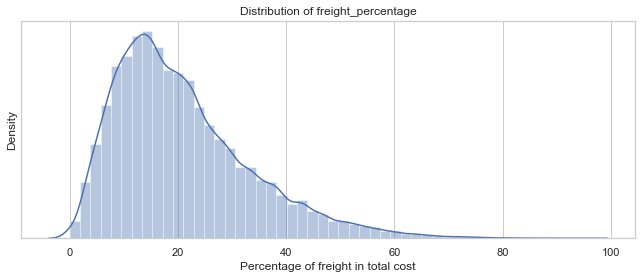

Pourcentage moyen du coût de livraison : 20


In [89]:
# calculer les coûts totaux produits et livraison
df_cart_costs = df_items.groupby(
    'order_id',
    as_index=False).agg({'product_price': ['sum'],
                         'product_freight': ['sum']})
df_cart_costs.columns = ['order_id',
                         'total_price',
                         'total_freight']
# déterminer la proportion du coût de livraison
df_cart_costs['freight_percentage'] = \
    100 * df_cart_costs['total_freight'] / \
    (df_cart_costs['total_freight'] + df_cart_costs['total_price'])
# afficher la distribution de la proportion du coût de livraison
distribution(df_cart_costs,
             'freight_percentage',
             'Percentage of freight in total cost',
             'dist')
print('Pourcentage moyen du coût de livraison : %d'
      % df_cart_costs['freight_percentage'].mean())

C:\Users\etien\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


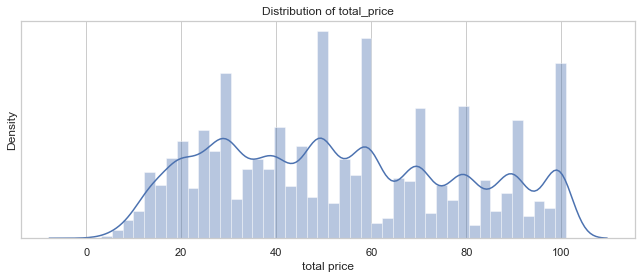

In [90]:
# afficher la distribution du total_price
distribution(df_cart_costs[df_cart_costs['total_price'] < 101],
             'total_price',
             'total price',
             'dist')

C:\Users\etien\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


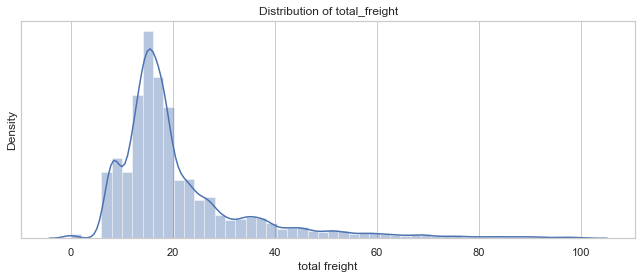

In [91]:
# afficher la distribution du total_freight
distribution(df_cart_costs[df_cart_costs['total_freight'] < 101],
             'total_freight',
             'total freight',
             'dist')

In [92]:
# scruter les commandes sans frais de livraison
df_cart_costs[df_cart_costs['total_freight'] == 0].shape

(338, 4)

In [93]:
# contrôler la pertinence des valeurs limites des niveaux
pd.qcut(df_cart_costs['freight_percentage'], 3)

0        (13.727, 23.682]
1        (-0.001, 13.727]
2        (-0.001, 13.727]
3        (23.682, 95.545]
4        (-0.001, 13.727]
               ...       
98661    (-0.001, 13.727]
98662    (-0.001, 13.727]
98663    (13.727, 23.682]
98664    (-0.001, 13.727]
98665    (13.727, 23.682]
Name: freight_percentage, Length: 98666, dtype: category
Categories (3, interval[float64]): [(-0.001, 13.727] < (13.727, 23.682] < (23.682, 95.545]]

In [94]:
# découper le pourcentage en 3 niveaux
df_cart_costs['freight_percentage_lvl'] = pd.qcut(
    df_cart_costs['freight_percentage'],
    3,
    labels=['Low_FreightCost',
            'Nominal_FreightCost',
            'High_FreightCost'])

Text(0.5, 1.02, 'Freight Levels')

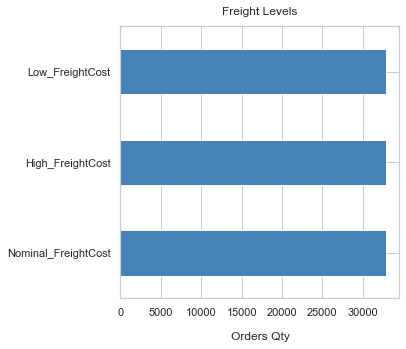

In [95]:
# observer la répartition par niveaux des commandes par cout de livraison
df_cart_costs['freight_percentage_lvl'].value_counts().plot(
    kind='barh',
    color='steelblue',
    figsize=(5, 5)).invert_yaxis()
plt.xlabel('Orders Qty', labelpad=14)
plt.title('Freight Levels', y=1.02)

In [96]:
# Observer les features créés
df_cart_costs

,order_id,total_price,total_freight,freight_percentage,freight_percentage_lvl
0,00010242fe8c5a6d1ba2dd792cb16214,58.90,13.29,18.409752,Nominal_FreightCost
1,00018f77f2f0320c557190d7a144bdd3,239.90,19.93,7.670400,Low_FreightCost
2,000229ec398224ef6ca0657da4fc703e,199.00,17.87,8.239959,Low_FreightCost
3,00024acbcdf0a6daa1e931b038114c75,12.99,12.79,49.612102,High_FreightCost
4,00042b26cf59d7ce69dfabb4e55b4fd9,199.90,18.14,8.319574,Low_FreightCost
...,...,...,...,...,...
98661,fffc94f6ce00a00581880bf54a75a037,299.99,43.41,12.641235,Low_FreightCost
98662,fffcd46ef2263f404302a634eb57f7eb,350.00,36.53,9.450754,Low_FreightCost
98663,fffce4705a9662cd70adb13d4a31832d,99.90,16.95,14.505777,Nominal_FreightCost
98664,fffe18544ffabc95dfada21779c9644f,55.99,8.72,13.475506,Low_FreightCost


In [97]:
# aggréger aux commandes les coûts totaux et pourcentage du coût de livraison
df_orders = df_orders.merge(
    df_cart_costs,
    how='left',
    left_on=['order_id'],
    right_on=['order_id'])

In [98]:
# contrôler le résultat
print(ref-df_orders.shape[0])
df_orders.sample(3)

8147


,order_id,customer_id,order_purchase_timestamp,order_purchase_year,order_purchase_month,order_purchase_day,order_purchase_dayofweek,order_purchase_hour,order_purchase_month_label,order_purchase_dayofweek_label,time_zone_hour,time_zone_day,purchase_time_zone_cat,estimated_delivery_time,effective_delivery_time,delivery_vs_estimated,delivery_vs_estimated_lvl,items_qty,products_qty,most_important_product,total_price,total_freight,freight_percentage,freight_percentage_lvl
21538,441ab430a31f0c3424c85496c65bc8f2,ef0a53a3dc977bf493065ebf09ab4d93,2018-07-28 14:47:32,2018,7,28,5,14,Jul,Sat,PM,WE,WE,11,6,5,Later_Delivery,single_item,single_product,3c1907ae45ee32709a71b67f20f65814,129.9,13.57,9.458423,Low_FreightCost
60108,427d0f687214f83a79eb0b0d33d32d28,7919c98d539dbe20896f917500ffdba6,2018-08-04 23:34:24,2018,8,4,5,23,Aug,Sat,Evening,WE,WE,10,8,1,Later_Delivery,single_item,single_product,f8b624d4e475bb8d1bddf1b65c6a64f6,179.0,19.48,9.814591,Low_FreightCost
16700,358062b4847c9e2ce76ba4895d0f6625,e139948a02a65f3d63dca4169cd990b8,2018-06-18 09:30:44,2018,6,18,0,9,Jun,Mon,AM,WD,AM-WD,28,4,24,Sooner_Delivery,single_item,single_product,5f3a6b9196dde7e3702ec07bbdd34fab,117.0,23.62,16.797042,Nominal_FreightCost


In [99]:
df_orders[df_orders['order_id'] == '00143d0f86d6fbd9f9b38ab440ac16f5']

,order_id,customer_id,order_purchase_timestamp,order_purchase_year,order_purchase_month,order_purchase_day,order_purchase_dayofweek,order_purchase_hour,order_purchase_month_label,order_purchase_dayofweek_label,time_zone_hour,time_zone_day,purchase_time_zone_cat,estimated_delivery_time,effective_delivery_time,delivery_vs_estimated,delivery_vs_estimated_lvl,items_qty,products_qty,most_important_product,total_price,total_freight,freight_percentage,freight_percentage_lvl
33339,00143d0f86d6fbd9f9b38ab440ac16f5,2e45292979b9b2700ea09560eeb0f803,2017-10-16 15:29:43,2017,10,16,0,15,Oct,Mon,PM,WD,PM-WD,20,11,9,Nominal_Delivery,multi_items,single_product,e95ee6822b66ac6058e2e4aff656071a,63.99,45.3,41.449355,High_FreightCost


In [100]:
# conserver une seule occurence de chaque commande multi-items
print(df_orders.shape)
df_orders = df_orders.drop_duplicates(
    subset='order_id',
    keep='first').copy()
print(df_orders.shape)

(91294, 24)
(91294, 24)


In [101]:
# créer / actualiser les commandes répartes par année
orders_2017 = df_orders[(df_orders['order_purchase_year'] == 2017) |
                        (df_orders['order_purchase_year'] == 2016)]
orders_2018 = df_orders[(df_orders['order_purchase_year'] == 2018)]

In [102]:
# observer la variation éventuelle entre 2017 et 2018
print('Variation freight_percentage entre 2017 (ref) et 2018 : ' +
      str(round(orders_2017['freight_percentage'].mean() - orders_2018['freight_percentage'].mean())))

Variation freight_percentage entre 2017 (ref) et 2018 : 0


### 5.1.3.  Repérage du type de prix affiché avec terminaison "9", dit "charm price".

Le prix visible est plutôt le total_price, qui correspond au product_price dans le cas d'une commande single_item, et du product_price x qty dans le cas d'une commande multi_items.

In [103]:
# détecter le charm price sur le prix total
charm_price(df_orders, 'total_price')

,order_id,customer_id,order_purchase_timestamp,order_purchase_year,order_purchase_month,order_purchase_day,order_purchase_dayofweek,order_purchase_hour,order_purchase_month_label,order_purchase_dayofweek_label,time_zone_hour,time_zone_day,purchase_time_zone_cat,estimated_delivery_time,effective_delivery_time,delivery_vs_estimated,delivery_vs_estimated_lvl,items_qty,products_qty,most_important_product,total_price,total_freight,freight_percentage,freight_percentage_lvl,charm_price
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,2017,10,2,0,10,Oct,Mon,AM,WD,AM-WD,15,8,7,Later_Delivery,single_item,single_product,87285b34884572647811a353c7ac498a,29.99,8.72,22.526479,Nominal_FreightCost,1
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-24 20:41:37,2018,7,24,1,20,Jul,Tue,Evening,WD,Evening-WD,19,13,5,Later_Delivery,single_item,single_product,595fac2a385ac33a80bd5114aec74eb8,118.70,22.76,16.089354,Nominal_FreightCost,0
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,2018-08-08 08:38:49,2018,8,8,2,8,Aug,Wed,AM,WD,AM-WD,26,9,17,Sooner_Delivery,single_item,single_product,aa4383b373c6aca5d8797843e5594415,159.90,19.22,10.730237,Low_FreightCost,1
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,2017-11-18 19:28:06,2017,11,18,5,19,Nov,Sat,Evening,WE,WE,26,13,12,Nominal_Delivery,single_item,single_product,d0b61bfb1de832b15ba9d266ca96e5b0,45.00,27.20,37.673130,High_FreightCost,0
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,2018-02-13 21:18:39,2018,2,13,1,21,Feb,Tue,Evening,WD,Evening-WD,12,2,9,Nominal_Delivery,single_item,single_product,65266b2da20d04dbe00c5c2d3bb7859e,19.90,8.72,30.468204,High_FreightCost,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91289,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,2017-03-09 09:54:05,2017,3,9,3,9,Mar,Thu,AM,WD,AM-WD,18,8,10,Nominal_Delivery,single_item,single_product,ac35486adb7b02598c182c2ff2e05254,72.00,13.08,15.373766,Nominal_FreightCost,0
91290,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,2018-02-06 12:58:58,2018,2,6,1,12,Feb,Tue,AM,WD,AM-WD,23,22,1,Later_Delivery,single_item,single_product,f1d4ce8c6dd66c47bbaa8c6781c2a923,174.90,20.10,10.307692,Low_FreightCost,1
91291,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,2017-08-27 14:46:43,2017,8,27,6,14,Aug,Sun,PM,WE,WE,30,24,5,Later_Delivery,single_item,single_product,b80910977a37536adeddd63663f916ad,205.99,65.02,23.991735,High_FreightCost,1
91292,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,2018-01-08 21:28:27,2018,1,8,0,21,Jan,Mon,Evening,WD,Evening-WD,37,17,20,Sooner_Delivery,multi_items,single_product,d1c427060a0f73f6b889a5c7c61f2ac4,359.98,81.18,18.401487,Nominal_FreightCost,1


In [104]:
# prix total moyens avec ou sans Charm price
df_total_price_charm = df_orders.groupby(
    'charm_price',
    as_index=False).agg({'order_id': ['count'],
                         'total_price': ['mean']})
df_total_price_charm.columns = ['charm_price',
                                'count',
                                'mean_price']
df_total_price_charm.set_index('charm_price')

,count,mean_price
charm_price,,
0,27576,150.175946
1,63718,127.079837


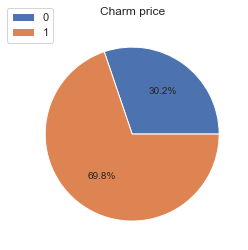

In [105]:
# observer la répartition du charm pricing à travers les produits
plt.title('Charm price', y=1.02)
plt.pie(df_total_price_charm['count'], autopct='%1.1f%%')
plt.legend(df_total_price_charm.index, loc='center left', bbox_to_anchor=(-0.1, 1.))

Tandis qu'il y a plus de références en Charm Price, on observe qu'il s'agit en moyenne d'articles moins coûteux, cela reletivisera l'impact du Charm Price sur les ventes.

In [106]:
# découper le prix total en classe
bins = [0, 10, 20, 50, 100, 200, 500, 1000, np.inf]
values = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']
df_orders['total_price_class'] = pd.cut(df_orders['total_price'], bins, labels=values)

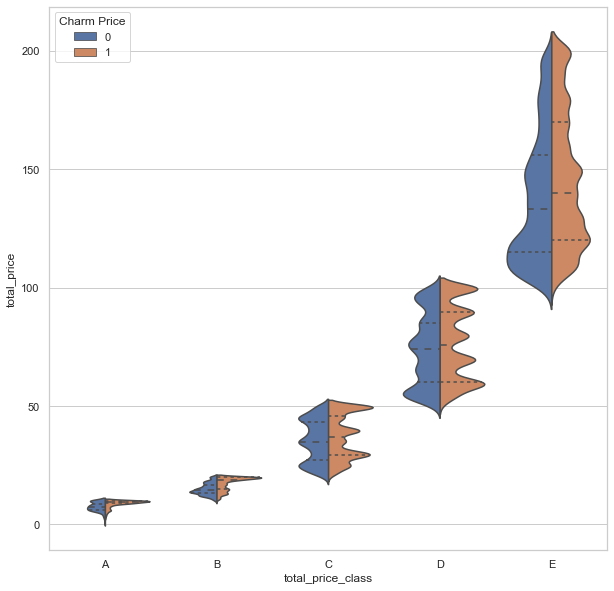

In [107]:
fig, ax = plt.subplots(figsize=(10, 10))
ax = sns.violinplot(x='total_price_class',
                    y='total_price',
                    hue='charm_price',
                    data=df_orders[df_orders['total_price'] < 200],
                    order=['A', 'B', 'C', 'D', 'E'],
                    split=True,
                    inner='quartile')
plt.legend(title='Charm Price', loc='upper left')

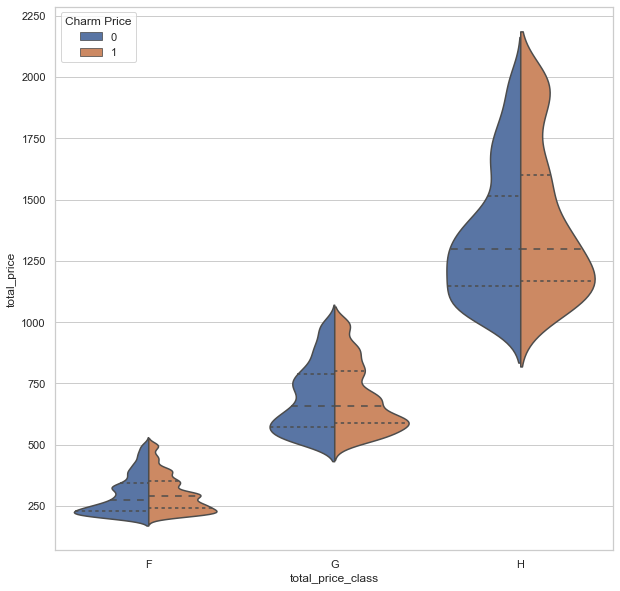

In [108]:
fig, ax = plt.subplots(figsize=(10, 10))
ax = sns.violinplot(x='total_price_class',
                    y='total_price',
                    hue='charm_price',
                    data=df_orders[df_orders['total_price'] < 2000],
                    order=['F', 'G', 'H'],
                    split=True,
                    inner='quartile')
plt.legend(title='Charm Price', loc='upper left')

Au delà des effets de seuils naturels s'agissant de prix proches des plafonds, on observe que le charm price a pour effet de relever le prix moyens d'articles bon marché, et que cet effet s'atténue voire s'inverse pour les articles plus chers.


In [109]:
# prix total moyens avec ou sans Charm price
df_total_low_price_charm = df_orders[df_orders['total_price'] < 200].groupby(
    'charm_price',
    as_index=False).agg({'order_id': ['count'],
                         'total_price': ['mean']})
df_total_low_price_charm.columns = ['charm_price',
                                    'count',
                                    'mean_price']
df_total_low_price_charm.set_index('charm_price')

,count,mean_price
charm_price,,
0,22491,80.242703
1,55617,80.203538


On relève plusieurs points d'équilibre des prix moyens, (ici [0, 200]), qui confirment cette observation.

In [110]:
# dériver un feature purement catégoriel pour le Charm Price
df_orders['charmed_price_cat'] =\
    df_orders['charm_price'].map(
    lambda x: 'Charmed_Price' if x == 1 else 'Uncharmed_Price')

Cela pourrait justifier d'adopter stratégie différente en fonction de la classe de prix des produits, et que 200 reals pourrait constituer une limite de prix exploitable.

Il reste à explorer si les classes de prix produit ont un sens pour, notamment, le seuil de 200 Reals, en fonction des revenus générés.

[Text(0, 0.5, 'Price levels'),
 Text(0.5, 0, 'Sales Revenue'),
 Text(0.5, 1.0, 'Sales by Price levels')]

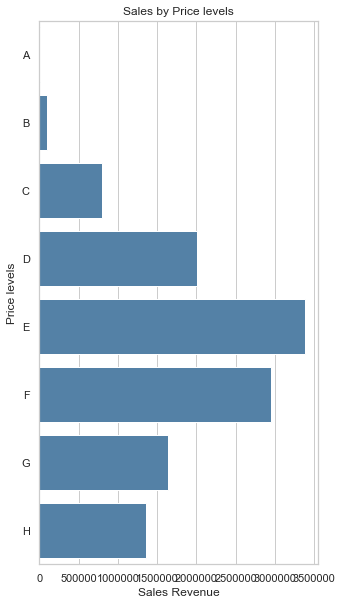

In [111]:
# répartition des revenus par catégorie de prix
df_sales_price_lvl = df_orders.groupby(
    'total_price_class',
    as_index=False).agg({'total_price': ['sum']})
df_sales_price_lvl.columns = ['total_price_class',
                              'sales']
df_sales_price_lvl = df_sales_price_lvl.sort_values(by=['sales'],
                                                    ascending=False)
fig, ax = plt.subplots(figsize=(5, 10))
ax = sns.barplot(y='total_price_class',
                 x='sales',
                 color='Steelblue',
                 data=df_sales_price_lvl)
ax.set(xlabel='Sales Revenue',
       ylabel='Price levels',
       title='Sales by Price levels')

De ce point de vue, 4 classes de prix dont le niveau de revenu généré serait équivalent, consisterait en les regroupements : 
- A, B, C, D
- E, 
- F, 
- G, H

on insiste sur le fait qu'il est plus judicieux de raisonner en total_price, afin que le prix affiché conserve un sens.

## 5.2. Products

Ce dataset permet d'accéder aux caractéristiques des produits achetés.

In [112]:
# aperçu des données Products
print(df_products.shape)
df_products.head(3)

(32951, 9)


,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0


In [113]:
# retirer les valeurs manquantes et controler la taille résultante
df_products = df_products.dropna().copy()
print(df_products.shape)

(32340, 9)


In [114]:
# renommer les colonnes lenght -> length
df_products = df_products.rename(columns={
    'product_name_lenght': 'product_name_length',
    'product_description_lenght': 'product_description_length'})

### 5.2.1.  Taille de l'article (volume)

In [115]:
# simplifier la taille des produits (volume)
df_products['product_size'] = df_products['product_length_cm'] * \
    df_products['product_height_cm'] * df_products['product_width_cm']
# retirer le détail
df_products = df_products.drop(
    columns=['product_length_cm',
             'product_height_cm',
             'product_width_cm'])

In [116]:
# observer les valeurs numériques
df_products.describe()

,product_name_length,product_description_length,product_photos_qty,product_weight_g,product_size
count,32340.000000,32340.000000,32340.000000,32340.000000,32340.000000
mean,48.476592,771.492393,2.188961,2276.956586,16577.961286
std,10.245699,635.124831,1.736787,4279.291845,27062.978147
min,5.000000,4.000000,1.000000,0.000000,168.000000
25%,42.000000,339.000000,1.000000,300.000000,2880.000000
50%,51.000000,595.000000,1.000000,700.000000,6860.000000
75%,57.000000,972.000000,3.000000,1900.000000,18522.750000
max,76.000000,3992.000000,20.000000,40425.000000,296208.000000


In [117]:
# compter les valeurs manquantes
df_products.isna().sum()

product_id                    0
product_category_name         0
product_name_length           0
product_description_length    0
product_photos_qty            0
product_weight_g              0
product_size                  0
dtype: int64

In [118]:
# retirer les valeurs manquantes
df_products = df_products.dropna().copy()
print(df_products.shape[0])

32340


### 5.2.2.  Catégorisation des produits par type de description : taille de description, de nom, nombre de photos

#### Product Description Length

C:\Users\etien\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


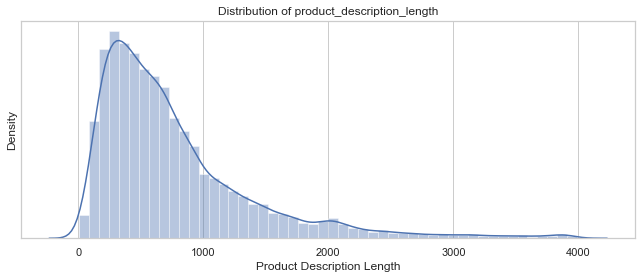

Taille moyenne de la description produit : 771


In [119]:
# observer le product_description_length
distribution(df_products,
             'product_description_length',
             'Product Description Length',
             'dist')
print('Taille moyenne de la description produit : %d'
      % df_products['product_description_length'].mean())

#### Product Name Length

C:\Users\etien\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


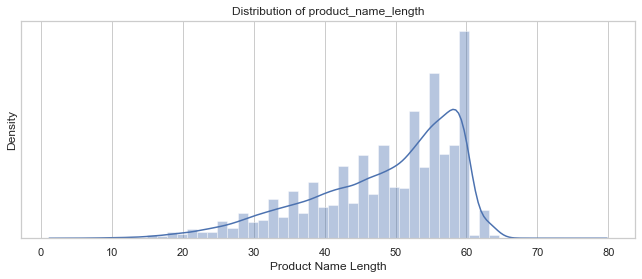

Taille moyenne nom du produit : 48


In [120]:
# observer le taille du nom de produit
distribution(df_products,
             'product_name_length',
             'Product Name Length',
             'dist')
print('Taille moyenne nom du produit : %d'
      % df_products['product_name_length'].mean())

#### Photo Quantity

Text(0.5, 1.02, 'Photos Qty Levels')

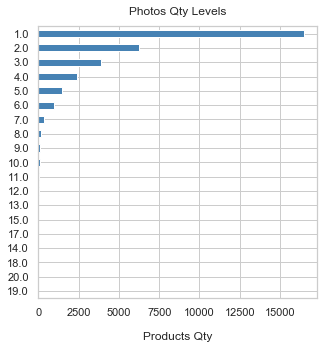

In [121]:
# observer la répartition des nb de photos
df_products['product_photos_qty'].value_counts().plot(
    kind='barh',
    color='steelblue',
    figsize=(5, 5)).invert_yaxis()
plt.xlabel('Products Qty', labelpad=14)
plt.title('Photos Qty Levels', y=1.02)

Le site Olist présente en premier plan 5 aperçu des contenus photo. Au delà, ce n'est donc plus une information aussi attractive pour le client que l'absence de photo ne peut avoir l'effet contraire.

In [122]:
# simplifier en aggrégeant au delà de 6 photos
bins = [0, 1, 2, 3, 4, 5, np.inf]
values = [1, 2, 3, 4, 5, 6]
df_products['product_photos_qty'] = pd.cut(df_products['product_photos_qty'], bins, labels=values)

Text(0.5, 1.02, 'Photos Qty Levels')

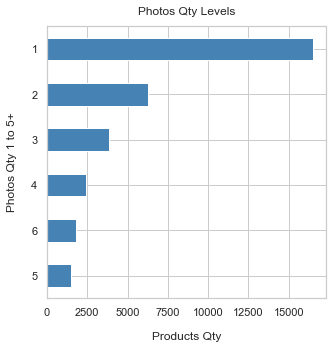

In [123]:
# observer la répartition des nb de photos
df_products['product_photos_qty'].value_counts().plot(
    kind='barh',
    color='steelblue',
    figsize=(5, 5)).invert_yaxis()
plt.xlabel('Products Qty', labelpad=14)
plt.ylabel('Photos Qty 1 to 5+', labelpad=14)
plt.title('Photos Qty Levels', y=1.02)

In [124]:
df_products['product_photos_qty'].astype('int64').var()

2.2266156823537884

A ce stade, un feature en trois niveaux pourrait être envisagé afin de rééquilibrer ce feature. Toutefois, il semble trop précis pour résumer la qualité de description d'un produit.

### Description quality

Un autre axe d'engineering pour ces features, consiterait à déduire un index de "qualité" de description des produits. On chercherait à construire un index "normalisable", c'est à dire dont le preprocessing sera gage d'une bonne prise en compte dans les modèles qui y sont sensibles.

In [125]:
# appliquer le rankgauss aux features de description
for i in ['product_photos_qty', 'product_name_length', 'product_description_length']:
    df_products = rankgauss(df_products, i)

2:80: E501 line too long (85 > 79 characters)


In [126]:
df_products.sample(3)

,product_id,product_category_name,product_name_length,product_description_length,product_photos_qty,product_weight_g,product_size,RG_product_photos_qty,RG_product_name_length,RG_product_description_length
443,ce8a29973a1fed3f8d22ea5514d9ea07,eletronicos,56.0,505.0,2,200.0,8000.0,0.269066,0.544847,-0.202221
4537,2e274768896aa2c7635b9689423a5d34,esporte_lazer,42.0,1404.0,1,3313.0,23200.0,-5.199338,-0.682458,1.126738
30965,a64fc2f46aef1e68dc0bdc591c84832c,esporte_lazer,52.0,1099.0,6,3100.0,27060.0,5.199338,0.076032,0.816627


In [127]:
for i in ['RG_product_photos_qty', 'RG_product_name_length', 'RG_product_description_length']:
    max = df_products[i].max()
    min = df_products[i].min()
    df_products[i] = (df_products[i] - min) / (max - min)

1:80: E501 line too long (94 > 79 characters)


In [128]:
df_products['product_qlty_index'] = (df_products['RG_product_photos_qty'] +
                             df_products['RG_product_name_length'] +
                             df_products['RG_product_description_length']) / 3

2:30: E128 continuation line under-indented for visual indent
3:30: E128 continuation line under-indented for visual indent


In [129]:
# retirer l'ancienne colonne product_category_name
df_products = df_products.drop(
    columns=['RG_product_photos_qty', 'RG_product_name_length', 'RG_product_description_length'])

C:\Users\etien\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


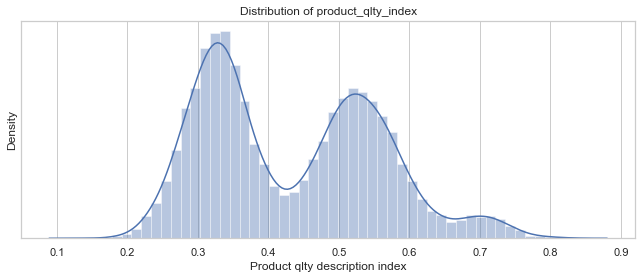

In [130]:
distribution(df_products,
             'product_qlty_index',
             'Product qlty description index',
             'dist')

On distingue 2 pics de valeurs avec cette formule, pouvant conduire à une séparation en 2 niveaux : 
- low < premier min local < high

In [131]:
# déterminer le seuil pour 2 niveaux
from scipy.signal import argrelextrema
# lister les minima locaux
x = np.histogram(df_products['product_qlty_index'], 100)
minInd = argrelextrema(x[0], np.less)
minInd

(array([27, 42, 52, 56, 74, 76, 78, 80, 83, 91, 94, 98], dtype=int64),)

In [132]:
# valeur de l'index correspondante
x = pd.DataFrame(x)
x[42]

0    206.000000
1      0.428971
Name: 42, dtype: float64

In [133]:
# comparaison avec le seuil coupant l'effectif en 2
pd.qcut(df_products['product_qlty_index'], 2)

0        (0.135, 0.413]
1        (0.135, 0.413]
2        (0.135, 0.413]
3        (0.135, 0.413]
4        (0.413, 0.833]
              ...      
32946    (0.413, 0.833]
32947    (0.135, 0.413]
32948    (0.135, 0.413]
32949    (0.413, 0.833]
32950    (0.135, 0.413]
Name: product_qlty_index, Length: 32340, dtype: category
Categories (2, interval[float64]): [(0.135, 0.413] < (0.413, 0.833]]

In [134]:
# découper le l'index en 2 niveaux low - high
bins = [0, 0.43, np.inf]
values = ['Low_QltyIdx', 'High_QltyIdx']
df_products['product_qlty_index_lvl'] = pd.cut(
    df_products['product_qlty_index'],
    bins,
    labels=values)

Text(0.5, 1.02, 'Product Description quality index level')

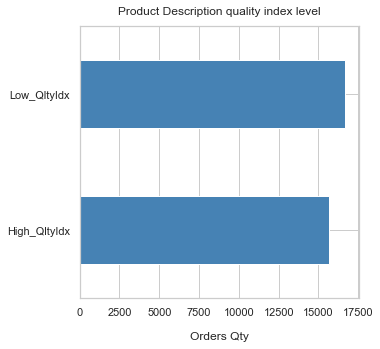

In [135]:
# observer la répartition par niveaux des commandes par cout de livraison
df_products['product_qlty_index_lvl'].value_counts().plot(
    kind='barh',
    color='steelblue',
    figsize=(5, 5)).invert_yaxis()
plt.xlabel('Orders Qty', labelpad=14)
plt.title('Product Description quality index level', y=1.02)

### 5.2.3.   Catégorisation des produits par caractéristique volume, poids et densité

#### Volume

C:\Users\etien\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


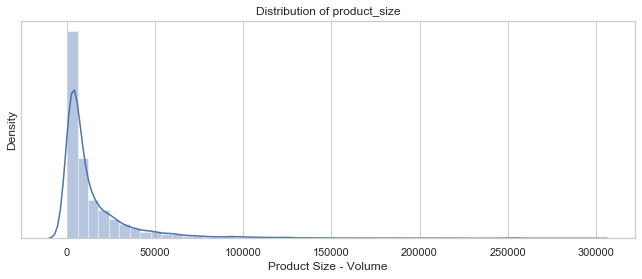

Taille moyenne des produits : 16577


In [136]:
# observer la taille des produits
distribution(df_products,
             'product_size',
             'Product Size - Volume',
             'dist')
print('Taille moyenne des produits : %d'
      % df_products['product_size'].mean())

#### Poids

C:\Users\etien\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


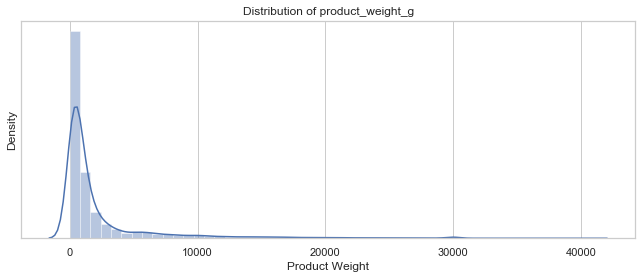

Poids moyen des produits : 2276


In [137]:
# observer le poids
distribution(df_products,
             'product_weight_g',
             'Product Weight',
             'dist')
print('Poids moyen des produits : %d'
      % df_products['product_weight_g'].mean())

#### Densité

In [138]:
# calculer la densité (formule de calcul de freight class unités impériales)
df_products['product_density'] =\
    10**6 * df_products['product_weight_g'] * 2.20462 /\
    10**3 * df_products['product_size'] * 35.3147

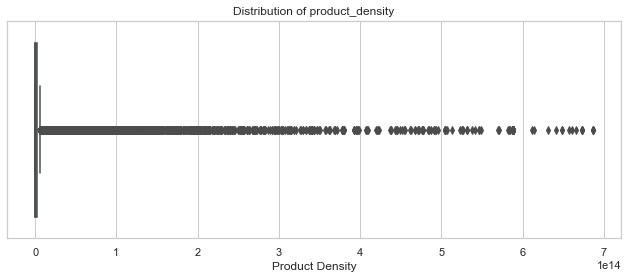

In [139]:
# observer la taille des produits
distribution(df_products,
             'product_density',
             'Product Density',
             'box')

#### Catégories de vente des produits

La seule indication qualitative de la nature des articles est contenue dans le nom de sa catégorie de vente. On privilégie la version anglaise pour améliorer la lisibilité.

In [140]:
# exploiter la version anglaise des catégories
df_translation.sample(3)

,product_category_name,product_category_name_english
3,cama_mesa_banho,bed_bath_table
45,alimentos,food
39,livros_tecnicos,books_technical


In [141]:
# améliorer la lisibilité des product category
df_translation['product_category_name_english'] =\
    df_translation['product_category_name_english'].str.replace('_', ' ')
df_translation['product_category_name_english'] =\
    df_translation['product_category_name_english'].str.title()

In [142]:
# aggréger aux produits la version anglaise des catégories
df_products = df_products.merge(
    df_translation,
    how='left',
    left_on=['product_category_name'],
    right_on=['product_category_name'])
df_products.sample(3)

,product_id,product_category_name,product_name_length,product_description_length,product_photos_qty,product_weight_g,product_size,product_qlty_index,product_qlty_index_lvl,product_density,product_category_name_english
17395,0ec09d10ef472b982d230612dbd5bd16,cama_mesa_banho,54.0,289.0,1,3250.0,12600.0,0.314727,Low_QltyIdx,3.188182e+12,Bed Bath Table
14645,801e1758675639e98967a271d92f4054,moveis_cozinha_area_de_servico_jantar_e_jardim,38.0,1163.0,4,2000.0,23625.0,0.532465,High_QltyIdx,3.678672e+12,Kitchen Dining Laundry Garden Furniture
6442,c0d133f59b1b9482e5b66b398ea60a69,cama_mesa_banho,54.0,235.0,1,1900.0,8704.0,0.306733,Low_QltyIdx,1.287543e+12,Bed Bath Table


### 5.2.4.   Rationnalisation des catégories de produits

Le classement des produits par catégorie est largement perfectible. On déplore ici non seulement des écritures erronées, mais également :
- l'absence de niveau de décomposition (macro-catégorie),
- qui correspondrait aux possibilité de recherche et navigation des clients sur le site.


In [143]:
# décompter et lister les catégories
print(df_products['product_category_name_english'].unique().size)
df_products['product_category_name_english'].unique()

72


array(['Perfumery', 'Art', 'Sports Leisure', 'Baby', 'Housewares',
       'Musical Instruments', 'Cool Stuff', 'Furniture Decor',
       'Home Appliances', 'Toys', 'Bed Bath Table',
       'Construction Tools Safety', 'Computers Accessories',
       'Health Beauty', 'Luggage Accessories', 'Garden Tools',
       'Office Furniture', 'Auto', 'Electronics', 'Fashion Shoes',
       'Telephony', 'Stationery', 'Fashion Bags Accessories', 'Computers',
       'Home Construction', 'Watches Gifts',
       'Construction Tools Construction', 'Pet Shop', 'Small Appliances',
       'Agro Industry And Commerce', 'Furniture Living Room',
       'Signaling And Security', 'Air Conditioning', 'Consoles Games',
       'Books General Interest', 'Costruction Tools Tools',
       'Fashion Underwear Beach', 'Fashion Male Clothing',
       'Kitchen Dining Laundry Garden Furniture',
       'Industry Commerce And Business', 'Fixed Telephony',
       'Construction Tools Lights', 'Books Technical',
       'Home App

In [144]:
# denombrer les produits non catégorisés inconnues
df_products['product_category_name_english'].isna().sum()

13

In [145]:
df_products.isna().sum()

product_id                        0
product_category_name             0
product_name_length               0
product_description_length        0
product_photos_qty                0
product_weight_g                  0
product_size                      0
product_qlty_index                0
product_qlty_index_lvl            0
product_density                   0
product_category_name_english    13
dtype: int64

In [146]:
df_products.describe()

,product_name_length,product_description_length,product_weight_g,product_size,product_qlty_index,product_density
count,32340.000000,32340.000000,32340.000000,32340.000000,32340.000000,3.234000e+04
mean,48.476592,771.492393,2276.956586,16577.961286,0.433378,1.016884e+13
std,10.245699,635.124831,4279.291845,27062.978147,0.124730,4.392084e+13
min,5.000000,4.000000,0.000000,168.000000,0.136042,0.000000e+00
25%,42.000000,339.000000,300.000000,2880.000000,0.325733,7.586239e+10
50%,51.000000,595.000000,700.000000,6860.000000,0.412835,3.738504e+11
75%,57.000000,972.000000,1900.000000,18522.750000,0.532954,2.321242e+12
max,76.000000,3992.000000,40425.000000,296208.000000,0.833492,6.866855e+14


#### Effectifs des produits dans chaque catégorie de vente

In [147]:
# calculer la quantité de produits dans chaque catégorie
rows = [[i, df_products[df_products['product_category_name_english'] ==
                        i].shape[0]]
        for i in df_products['product_category_name_english'].unique()]
df_category_qty = pd.DataFrame(rows, columns=['category', 'qty'])
# trier par nb de produits décroissant
df_category_qty = df_category_qty.sort_values(by='qty',
                                              ascending=False)

In [148]:
# top 5 des catégories par nb de produits
df_category_qty[:5]

,category,qty
10,Bed Bath Table,3029
2,Sports Leisure,2867
7,Furniture Decor,2657
13,Health Beauty,2444
4,Housewares,2335


In [149]:
# aggreger aux items les produits
df_items = df_items.merge(
    df_products,
    how='left',
    left_on=['product_id'],
    right_on=['product_id'])
print(df_items.shape[0])
df_items.sample(3)

112650


,order_id,product_id,seller_id,product_price,product_freight,product_category_name,product_name_length,product_description_length,product_photos_qty,product_weight_g,product_size,product_qlty_index,product_qlty_index_lvl,product_density,product_category_name_english
28197,bfdc8cc8e1e3a146d1adb471208f0a72,e30a07181e238b29af319577b9bb22fe,d566c37fa119d5e66c4e9052e83ee4ea,56.9,11.42,beleza_saude,48.0,1250.0,2,1100.0,4000.0,0.531849,High_QltyIdx,3.425642e+11,Health Beauty
12799,e26f52b2a37b0ce41ba38979221bf39d,4c3ae5db49258df0784827bdacf3b396,d98eec89afa3380e14463da2aabaea72,20.0,16.05,bebes,44.0,304.0,1,100.0,1280.0,0.290722,Low_QltyIdx,9.965503e+09,Baby
51781,8ab912e617d7f994f6483cba8dfe66f5,4f46469cc5558e5021c7051b5c2447d4,d57e18d5f73c7ccb7f7339b61166898d,27.9,15.79,fashion_bolsas_e_acessorios,56.0,356.0,3,500.0,18576.0,0.520563,High_QltyIdx,7.231218e+11,Fashion Bags Accessories


#### Quantité de produits vendus dans chaque catégorie de vente

In [150]:
# décompter les produits commandés par catégorie
df_categ_qty = df_items.groupby('product_category_name_english',
                                as_index=False).agg({'order_id': ['count']})
df_categ_qty.columns = ['product_category_name_english',
                        'count']
df_categ_qty = df_categ_qty.sort_values(by='count',
                                        ascending=False)

In [151]:
# top 5 des catégories par décompte des commandes
df_categ_qty[:5]

,product_category_name_english,count
7,Bed Bath Table,11115
43,Health Beauty,9670
65,Sports Leisure,8641
39,Furniture Decor,8334
15,Computers Accessories,7827


In [152]:
# aggreger les décompte de produits et produits commandés
df_category_qty = df_category_qty.merge(
    df_categ_qty,
    how='left',
    left_on=['category'],
    right_on=['product_category_name_english'])
df_category_qty = df_category_qty.sort_values(by='count',
                                              ascending=False)

In [153]:
# afficher les 2 quantités
pd.set_option('display.max_rows', df_category_qty.shape[0]+1)
df_category_qty

,category,qty,product_category_name_english,count
0,Bed Bath Table,3029,Bed Bath Table,11115.0
3,Health Beauty,2444,Health Beauty,9670.0
1,Sports Leisure,2867,Sports Leisure,8641.0
2,Furniture Decor,2657,Furniture Decor,8334.0
6,Computers Accessories,1639,Computers Accessories,7827.0
4,Housewares,2335,Housewares,6964.0
8,Watches Gifts,1329,Watches Gifts,5991.0
9,Telephony,1134,Telephony,4545.0
15,Garden Tools,753,Garden Tools,4347.0
5,Auto,1900,Auto,4235.0


L'ordre des quantités de produits par catégories est similaire à l'ordre des quantités de commandes effectuées dans ces catégories 

In [154]:
# rationaliser les catégories
category_mapping = {
    'Watches Gifts': 'Watches Gifts Toys',
    'Toys': 'Watches Gifts Toys',
    'Food Drink': 'Food Drink & Pets',
    'Food': 'Food Drink & Pets',
    'Drinks': 'Food Drink & Pets',
    'Flowers': 'Food Drink & Pets',
    'Pet Shop': 'Food Drink & Pets',
    'Baby': 'Health Beauty Baby',
    'Health Beauty': 'Health Beauty Baby',
    'Perfumery': 'Health Beauty Baby',
    'Diapers And Hygiene': 'Health Beauty Baby',
    'Bed Bath Table': 'Home Accessories',
    'Home Confort': 'Home Accessories',
    'Home Comfort 2': 'Home Accessories',
    'La Cuisine': 'Home Accessories',
    'Housewares': 'Home Appliances',
    'Small Appliances': 'Home Appliances',
    'Home Appliances 2': 'Home Appliances',
    'Small Appliances Home Oven And Coffee': 'Home Appliances',
    'Air Conditioning': 'Home Appliances',
    'Consoles Games': 'Entertainement',
    'Art': 'Entertainement',
    'Cine Photo': 'Entertainement',
    'Books General Interest': 'Entertainement',
    'Cds Dvds Musicals': 'Entertainement',
    'Music': 'Entertainement',
    'Books Technical': 'Entertainement',
    'Audio': 'Entertainement',
    'Dvds Blu Ray': 'Entertainement',
    'Books Imported': 'Entertainement',
    'Arts And Craftmanship': 'Entertainement',
    'Musical Instruments': 'Entertainement',
    'Fashion Male Clothing': 'Fashion',
    'Fashion Sport': 'Fashion',
    'Fashion Underwear Beach': 'Fashion',
    'Fashion Bags Accessories': 'Fashion',
    'Fashio Female Clothing': 'Fashion',
    'Fashion Shoes': 'Fashion',
    'Fashion Childrens Clothes': 'Fashion',
    'Luggage Accessories': 'Fashion',
    'Kitchen Dining Laundry Garden Furniture': 'Furniture',
    'Furniture Decor': 'Furniture',
    'Office Furniture': 'Furniture',
    'Furniture Living Room': 'Furniture',
    'Furniture Bedroom': 'Furniture',
    'Furniture Mattress And Upholstery': 'Furniture',
    'Costruction Tools Tools': 'Construction & Tools',
    'Construction Tools Safety': 'Construction & Tools',
    'Garden Tools': 'Construction & Tools',
    'Construction Tools Lights': 'Construction & Tools',
    'Construction Tools Construction': 'Construction & Tools',
    'Costruction Tools Garden': 'Construction & Tools',
    'Home Construction': 'Construction & Tools',
    'Computers Accessories': 'Electronics Computers & Accessories',
    'Computers': 'Electronics Computers & Accessories',
    'Fixed Telephony': 'Telephony',
    'Tablets Printing Image': 'Electronics Computers & Accessories',
    'Electronics': 'Electronics Computers & Accessories',
    'Agro Industry And Commerce': 'Corporate',
    'Signaling And Security': 'Corporate',
    'Security And Services': 'Corporate',
    'Industry Commerce And Business': 'Corporate',
    'Market Place': 'Corporate',
    'Stationery': 'Supplies',
    'Cool Stuff': 'Supplies',
    'Party Supplies': 'Supplies',
    'Christmas Supplies': 'Supplies'}

In [155]:
# renommer le feature des regroupement de catégories
df_category_qty = df_category_qty.rename(columns={'product_category_name_english': 'product_cat'})

In [156]:
# vérifier l'application de la correspondance
df_category_qty['product_cat'] = df_category_qty['product_cat'].replace(category_mapping)

In [157]:
# décompter les produits référencés par categorie
df_rat_categ_qty_ref = df_category_qty.groupby(
    'product_cat',
    as_index=False).agg({'qty': ['sum']})
df_rat_categ_qty_ref.columns = ['product_cat',
                                'new_qty']
df_rat_categ_qty_ref = df_rat_categ_qty_ref.sort_values(by='new_qty',
                                                        ascending=False)

[Text(0, 0.5, 'Categories'),
 Text(0.5, 0, 'Products Qty'),
 Text(0.5, 1.0, 'Products by Category')]

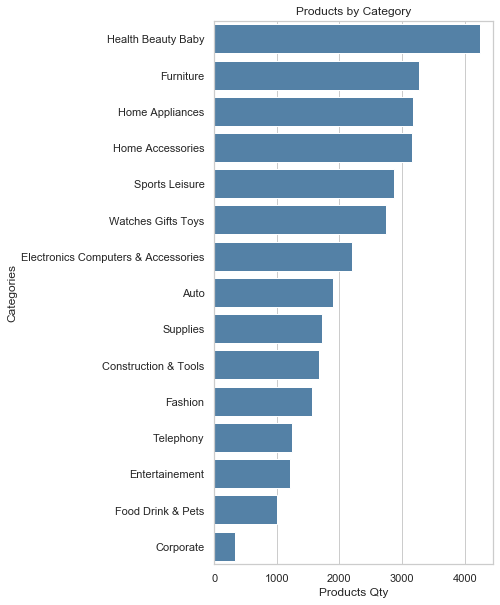

In [158]:
# contrôler la nouvelle répartition des produits référencés
fig, ax = plt.subplots(figsize=(5, 10))
ax = sns.barplot(y='product_cat',
                 x='new_qty',
                 color='Steelblue',
                 data=df_rat_categ_qty_ref)
ax.set(xlabel='Products Qty',
       ylabel='Categories',
       title='Products by Category')

In [159]:
# décompter les produits commandés par product_cat
df_rat_categ_qty = df_category_qty.groupby(
    'product_cat',
    as_index=False).agg({'count': ['sum']})
df_rat_categ_qty.columns = ['product_cat',
                            'new_count']
df_rat_categ_qty = df_rat_categ_qty.sort_values(by='new_count',
                                                ascending=False)

[Text(0, 0.5, 'Categories'),
 Text(0.5, 0, 'Orders Qty'),
 Text(0.5, 1.0, 'Orders by Category')]

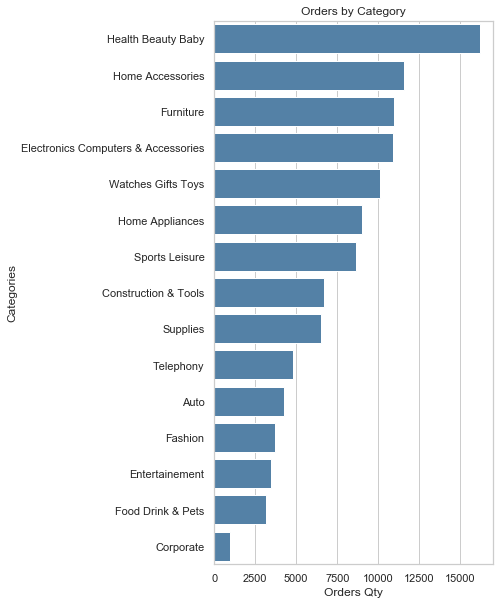

In [160]:
# contrôler la nouvelle répartition par regroupement de catégories
fig, ax = plt.subplots(figsize=(5, 10))
ax = sns.barplot(y='product_cat',
                 x='new_count',
                 color='Steelblue',
                 data=df_rat_categ_qty)
ax.set(xlabel='Orders Qty',
       ylabel='Categories',
       title='Orders by Category')

In [161]:
# renommer le feature des regroupement de catégories
df_items = df_items.rename(
    columns={'product_category_name_english': 'product_cat'})

# appliquer la correspondance sur le dataset des produits
df_items['product_cat'] =\
    df_items['product_cat'].replace(category_mapping)

# retirer l'ancienne colonne product_category_name
df_items = df_items.drop(
    columns=['product_category_name'])

In [162]:
df_items.sample(3)

,order_id,product_id,seller_id,product_price,product_freight,product_name_length,product_description_length,product_photos_qty,product_weight_g,product_size,product_qlty_index,product_qlty_index_lvl,product_density,product_cat
89343,35253375b48f367b1d654e9b1d762ea7,e4a559e4d11658f9979148efee14c535,25e6ffe976bd75618accfe16cefcbd0d,35.0,15.23,29.0,635.0,2,200.0,3000.0,0.458899,High_QltyIdx,4.671330e+10,Health Beauty Baby
55321,82779777675c9ae6f1e10c9385572ca6,2016dc27f7cc30f18815b34170e0ce98,82bd0703a4aefd6b599e5bfdaed378fb,388.0,17.83,46.0,1343.0,3,3267.0,17825.0,0.544270,High_QltyIdx,4.533858e+12,Health Beauty Baby
37580,ab0440479873dd65da01b76ae53ec3c0,4df96b4c5286321b71834691e8defd53,8cbac7e12637ed9cffa18c7875207478,22.5,15.10,57.0,571.0,1,400.0,4704.0,0.354547,Low_QltyIdx,1.464929e+11,Watches Gifts Toys


In [163]:
df_items[df_items['product_id'] == 'ceb43e52119b25c8f2b6049a5534c339']

,order_id,product_id,seller_id,product_price,product_freight,product_name_length,product_description_length,product_photos_qty,product_weight_g,product_size,product_qlty_index,product_qlty_index_lvl,product_density,product_cat
21403,cf2159bbc127ae7a92a057266d687260,ceb43e52119b25c8f2b6049a5534c339,6b243f80ed07b10f0e8aa0f21a205f3c,64.9,16.42,55.0,1392.0,1,750.0,4096.0,0.38201,Low_QltyIdx,2.391721e+11,Sports Leisure
60975,7585d4e21b02da91dd6b9dae232f96f8,ceb43e52119b25c8f2b6049a5534c339,6b243f80ed07b10f0e8aa0f21a205f3c,64.9,15.21,55.0,1392.0,1,750.0,4096.0,0.38201,Low_QltyIdx,2.391721e+11,Sports Leisure
84799,3f60c18dceaa348eb8891eea71a53dc1,ceb43e52119b25c8f2b6049a5534c339,6b243f80ed07b10f0e8aa0f21a205f3c,64.9,23.60,55.0,1392.0,1,750.0,4096.0,0.38201,Low_QltyIdx,2.391721e+11,Sports Leisure
85688,3d5651800efaa81c9c96808ded6f145e,ceb43e52119b25c8f2b6049a5534c339,6b243f80ed07b10f0e8aa0f21a205f3c,64.9,15.21,55.0,1392.0,1,750.0,4096.0,0.38201,Low_QltyIdx,2.391721e+11,Sports Leisure


In [164]:
df_items.shape[0]

112650

In [165]:
# calculer la quantité de produits référencés dans chaque nouvelle catégorie
rows = [[i, df_products[df_products['product_category_name_english'] ==
                        i].shape[0]]
        for i in df_products['product_category_name_english'].unique()]
df_category_qty = pd.DataFrame(rows, columns=['category', 'qty'])
# trier par nb de produits décroissant
df_category_qty = df_category_qty.sort_values(by='qty',
                                              ascending=False)

## 5.3. Simplification au produit le plus cher d'une commande

La stratégie est d'aggréger les informations produits aux commandes sur le produit "phare" most_important_product

In [166]:
print(ref-df_orders.shape[0])
df_orders.sample(3)

8147


,order_id,customer_id,order_purchase_timestamp,order_purchase_year,order_purchase_month,order_purchase_day,order_purchase_dayofweek,order_purchase_hour,order_purchase_month_label,order_purchase_dayofweek_label,time_zone_hour,time_zone_day,purchase_time_zone_cat,estimated_delivery_time,effective_delivery_time,delivery_vs_estimated,delivery_vs_estimated_lvl,items_qty,products_qty,most_important_product,total_price,total_freight,freight_percentage,freight_percentage_lvl,charm_price,total_price_class,charmed_price_cat
66332,0644bbc829f241622c4c83b08436c465,2333b5eb4c77379b280aa26a66016020,2018-06-24 21:04:15,2018,6,24,6,21,Jun,Sun,Evening,WE,WE,30,4,26,Sooner_Delivery,single_item,single_product,6f46359e56f51d5deded13adcd1c255c,31.9,15.32,32.443880,High_FreightCost,1,C,Charmed_Price
83861,61c3073707aeb0763a028eb696085d02,e7db0530c950f6fb98b796f0d2ff3757,2018-07-02 18:10:34,2018,7,2,0,18,Jul,Mon,Evening,WD,Evening-WD,23,9,14,Nominal_Delivery,single_item,single_product,78efe838c04bbc568be034082200ac20,99.9,27.00,21.276596,Nominal_FreightCost,1,D,Charmed_Price
50262,eac8032acefa88ddda1fa3dffba07365,7b9b63711b487f3208a31fdbc16c8019,2018-03-18 23:01:08,2018,3,18,6,23,Mar,Sun,Evening,WE,WE,28,24,3,Later_Delivery,single_item,single_product,fb1c85ab4adb8f0fd63d3e2156e51f4b,59.9,18.30,23.401535,Nominal_FreightCost,1,D,Charmed_Price


In [167]:
df_orders['most_important_product'].unique().size

29703

In [168]:
df_orders.shape[0]

91294

In [169]:
df_orders[df_orders['most_important_product'] == 'ceb43e52119b25c8f2b6049a5534c339']

,order_id,customer_id,order_purchase_timestamp,order_purchase_year,order_purchase_month,order_purchase_day,order_purchase_dayofweek,order_purchase_hour,order_purchase_month_label,order_purchase_dayofweek_label,time_zone_hour,time_zone_day,purchase_time_zone_cat,estimated_delivery_time,effective_delivery_time,delivery_vs_estimated,delivery_vs_estimated_lvl,items_qty,products_qty,most_important_product,total_price,total_freight,freight_percentage,freight_percentage_lvl,charm_price,total_price_class,charmed_price_cat
2918,cf2159bbc127ae7a92a057266d687260,79986e17c3a038cb24355365fc78a0e9,2018-04-13 07:50:12,2018,4,13,4,7,Apr,Fri,Night,WD,Night,27,6,21,Sooner_Delivery,single_item,single_product,ceb43e52119b25c8f2b6049a5534c339,64.9,16.42,20.191835,Nominal_FreightCost,1,D,Charmed_Price
8636,3d5651800efaa81c9c96808ded6f145e,2a882786bc3a3af530ed3405b171b09b,2017-09-16 19:36:06,2017,9,16,5,19,Sep,Sat,Evening,WE,WE,18,5,12,Nominal_Delivery,single_item,single_product,ceb43e52119b25c8f2b6049a5534c339,64.9,15.21,18.986394,Nominal_FreightCost,1,D,Charmed_Price
18267,7585d4e21b02da91dd6b9dae232f96f8,d106918f73f119d9ebf155a753135f40,2017-10-19 22:15:23,2017,10,19,3,22,Oct,Thu,Evening,WD,Evening-WD,19,5,13,Nominal_Delivery,single_item,single_product,ceb43e52119b25c8f2b6049a5534c339,64.9,15.21,18.986394,Nominal_FreightCost,1,D,Charmed_Price
72429,3f60c18dceaa348eb8891eea71a53dc1,7b0e5d9d1949bce0504d928d8897dead,2018-08-01 20:48:00,2018,8,1,2,20,Aug,Wed,Evening,WD,Evening-WD,20,7,12,Nominal_Delivery,single_item,single_product,ceb43e52119b25c8f2b6049a5534c339,64.9,23.60,26.666667,High_FreightCost,1,D,Charmed_Price


In [170]:
df_items.shape

(112650, 14)

In [171]:
# aggréger aux commandes les informations détaillées des produits
df_orders = df_orders.merge(
    df_items,
    how='left',
    left_on=['order_id',
             'most_important_product'],
    right_on=['order_id',
              'product_id'])
print(ref-df_orders.shape[0])
df_orders.sample(3)


-905


,order_id,customer_id,order_purchase_timestamp,order_purchase_year,order_purchase_month,order_purchase_day,order_purchase_dayofweek,order_purchase_hour,order_purchase_month_label,order_purchase_dayofweek_label,time_zone_hour,time_zone_day,purchase_time_zone_cat,estimated_delivery_time,effective_delivery_time,delivery_vs_estimated,delivery_vs_estimated_lvl,items_qty,products_qty,most_important_product,total_price,total_freight,freight_percentage,freight_percentage_lvl,charm_price,total_price_class,charmed_price_cat,product_id,seller_id,product_price,product_freight,product_name_length,product_description_length,product_photos_qty,product_weight_g,product_size,product_qlty_index,product_qlty_index_lvl,product_density,product_cat
57094,486c57abefde2c75d496af33eade014c,91d4f4a4af43fac2d39ee94f9b3a9e72,2017-03-19 20:28:56,2017,3,19,6,20,Mar,Sun,Evening,WE,WE,17,2,14,Nominal_Delivery,single_item,single_product,425a12d4dd8e5e7ba3be5c4157f1fafc,189.00,11.93,5.937391,Low_FreightCost,1,E,Charmed_Price,425a12d4dd8e5e7ba3be5c4157f1fafc,fa1c13f2614d7b5c4749cbc52fecda94,189.00,11.93,53.0,657.0,2,246.0,2574.0,0.51861,High_QltyIdx,4.929841e+10,Watches Gifts Toys
76112,415163634b075446172210d1b9717e2a,b0b272dcb47a51eace14ac2dcf4b5ec5,2018-06-21 11:54:06,2018,6,21,3,11,Jun,Thu,AM,WD,AM-WD,35,8,27,Sooner_Delivery,single_item,single_product,154e7e31ebfa092203795c972e5804a6,23.99,15.27,38.894549,High_FreightCost,1,C,Charmed_Price,154e7e31ebfa092203795c972e5804a6,cc419e0650a3c5ba77189a1882b7556a,23.99,15.27,48.0,575.0,1,100.0,4500.0,0.32375,Low_QltyIdx,3.503497e+10,Health Beauty Baby
61162,b53a3bae66c300d0757b9e094b326264,f80399585626ce586b63e4afaf6ade7d,2017-12-11 16:33:31,2017,12,11,0,16,Dec,Mon,PM,WD,PM-WD,28,17,10,Nominal_Delivery,single_item,single_product,542b3d80712d51eefe3a3cd1c5f4e8fe,35.90,15.11,29.621643,High_FreightCost,1,C,Charmed_Price,542b3d80712d51eefe3a3cd1c5f4e8fe,537eb890efff034a88679788b647c564,35.90,15.11,49.0,223.0,1,400.0,36000.0,0.28992,Low_QltyIdx,1.121119e+12,Supplies


In [172]:
# retirer les valeurs manquantes et controler la taille résultante
df_orders = df_orders.dropna().copy()
print(df_orders.shape)

(98892, 40)


In [173]:
df_orders.columns

Index(['order_id', 'customer_id', 'order_purchase_timestamp',
       'order_purchase_year', 'order_purchase_month', 'order_purchase_day',
       'order_purchase_dayofweek', 'order_purchase_hour',
       'order_purchase_month_label', 'order_purchase_dayofweek_label',
       'time_zone_hour', 'time_zone_day', 'purchase_time_zone_cat',
       'estimated_delivery_time', 'effective_delivery_time',
       'delivery_vs_estimated', 'delivery_vs_estimated_lvl', 'items_qty',
       'products_qty', 'most_important_product', 'total_price',
       'total_freight', 'freight_percentage', 'freight_percentage_lvl',
       'charm_price', 'total_price_class', 'charmed_price_cat', 'product_id',
       'seller_id', 'product_price', 'product_freight', 'product_name_length',
       'product_description_length', 'product_photos_qty', 'product_weight_g',
       'product_size', 'product_qlty_index', 'product_qlty_index_lvl',
       'product_density', 'product_cat'],
      dtype='object')

# 6. Paiements

Un client peut choisir de payer à l'aide de plusieurs payment_type ce qui ouvre un payment_sequential >1. <br/> 
Il peut également choisir un étalement en n fois (valeur de payment_installments) dans le cas d'un paiement par carte de crédit.

In [174]:
# montrer un aperçu des données de paiement
df_payments.sample(3)

,order_id,payment_sequential,payment_type,payment_installments,payment_value
7521,18ed2638b8a18b428d5f0cc575878eb1,1,credit_card,1,87.93
32295,6e15b44afc42ba31c4eb67e967a3bf4b,1,boleto,1,190.25
56121,1def2f4bb1690cbafbef93e9617b0c56,1,credit_card,1,98.22


In [175]:
df_payments.isna().sum()

order_id                0
payment_sequential      0
payment_type            0
payment_installments    0
payment_value           0
dtype: int64

## 6.1. Type de Paiement

In [176]:
# lister les type de paiement
df_payments['payment_type'].unique()

array(['credit_card', 'boleto', 'voucher', 'debit_card', 'not_defined'],
      dtype=object)

In [177]:
df_payments['payment_type'].value_counts()

credit_card    76795
boleto         19784
voucher         5775
debit_card      1529
not_defined        3
Name: payment_type, dtype: int64

In [178]:
# identifier les types non définis
cols = ['payment_sequential',
        'payment_type',
        'payment_installments',
        'payment_value']
mask = (df_payments['payment_type'] == 'not_defined')
print(df_payments[cols][mask].shape)
df_payments[cols][mask].sample(3)

(3, 4)


,payment_sequential,payment_type,payment_installments,payment_value
57411,1,not_defined,1,0.0
94427,1,not_defined,1,0.0
51280,1,not_defined,1,0.0


In [179]:
# retirer les paiements indéfinis
df_payments = df_payments[df_payments['payment_type'] != 'not_defined']
print(df_payments.shape)

(103883, 5)


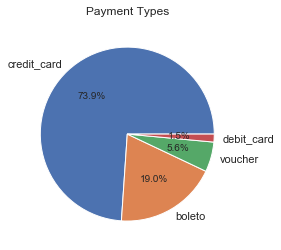

In [180]:
# observer la répartition des types de payment
plt.title('Payment Types', y=1.02)
plt.pie(df_payments['payment_type'].value_counts(),
        labels=df_payments['payment_type'].value_counts().index,
        autopct='%1.1f%%')
plt.show()

In [181]:
# ordonner les paiements par valeur décroissante
df_payments = df_payments.sort_values(by=['order_id', 'payment_value'],
                                      ascending=False)

# retenir la taille de la séquence de paiement
df_payments_details = df_payments.groupby(
    'order_id',
    as_index=False).agg({'payment_sequential': 'max',
                         'payment_installments': 'max',
                         'payment_value': 'sum'})
df_payments_details.columns = ['order_id',
                               'payment_sequence_size',
                               'payment_installments_size',
                               'payment_total']

# aggreger les détails
df_payments = df_payments.merge(
    df_payments_details,
    how='left',
    left_on=['order_id'],
    right_on=['order_id'])

# vérifier le résultat
df_payments.sample(3)

,order_id,payment_sequential,payment_type,payment_installments,payment_value,payment_sequence_size,payment_installments_size,payment_total
72380,4d2280f2d019f91aa6cb3e4e4188d984,1,credit_card,2,115.92,1,2,115.92
62243,665d50e18511ae7a38d58eded8c03b60,1,credit_card,3,92.50,1,3,92.50
17680,d40516d201a6c180696f31d77ca651ac,1,credit_card,3,168.59,1,3,168.59


In [182]:
# retirer les doublons en gardant le paiement le plus important
df_payments.drop_duplicates(subset='order_id', keep='first', inplace=True)

In [183]:
# renommer les colonnes
df_payments = df_payments.rename(columns={
    'payment_type': 'main_payment_type',
    'payment_value': 'main_payment_value'})
# retirer les colonnes obsolètes
df_payments = df_payments.drop(
    columns=['payment_sequential',
             'payment_installments'])

In [184]:
# vérfier le résultat
df_payments.sample(3)

,order_id,main_payment_type,main_payment_value,payment_sequence_size,payment_installments_size,payment_total
60330,6afcda277482fc479e9abc6f6bbdd355,credit_card,144.40,1,2,144.40
5959,f16010e0add047ba483e2b3eefa7c60e,credit_card,69.61,1,6,69.61
44428,9322826079b5b7b78e112e63cb587022,credit_card,128.95,1,8,128.95


C:\Users\etien\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


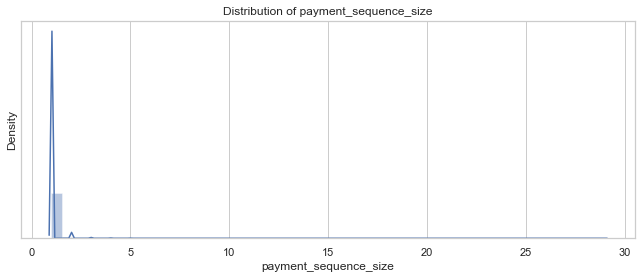

taille moyenne de la séquence de paiement : 1


In [185]:
# observer la distribution des séquences de paiement
distribution(df_payments,
             'payment_sequence_size',
             'payment_sequence_size',
             'dist')
print('taille moyenne de la séquence de paiement : %d'
      % df_payments['payment_sequence_size'].mean())

In [186]:
# dériver un feature réduits à mono_payment ou multi_payment
df_payments['payment_sequence_size_cat'] =\
    df_payments['payment_sequence_size'].map(
    lambda x: 'mono_payment' if x == 1 else 'multi_payment')

In [187]:
df_payments['payment_installments_size'].unique()

array([ 1,  3,  7,  4, 10,  2,  5,  6,  8,  9, 24, 20, 13, 15, 12, 21, 18,
       17, 22, 14, 11, 16,  0, 23], dtype=int64)

C:\Users\etien\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


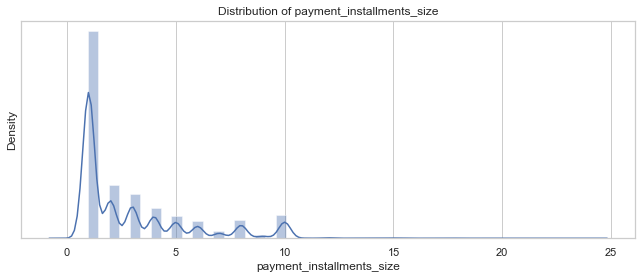

nb de versement moyens : 2


In [188]:
# observer la distribution des versements
distribution(df_payments,
             'payment_installments_size',
             'payment_installments_size',
             'dist')
print('nb de versement moyens : %d'
      % df_payments['payment_installments_size'].mean())

In [189]:
# retirer les valeurs outliers
df_payments = df_payments[df_payments['payment_installments_size'] != 0]

C:\Users\etien\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


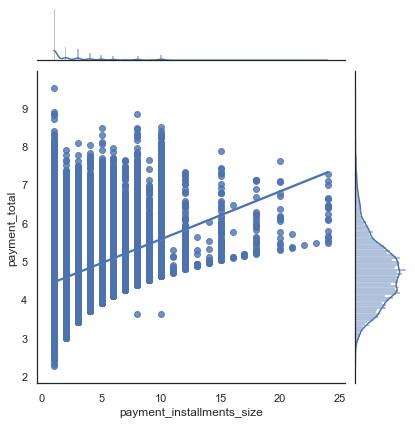

In [190]:
# évolution des nb de versements selon le montant de la commande (au log)
with sns.axes_style('white'):
    sns.jointplot(df_payments['payment_installments_size'],
                  np.log(df_payments['payment_total']),
                  data=df_payments,
                  kind='reg')
    plt.show()

sans surprise, le nb de versements augmente avec le montant, et on observe également que la possibilité de paiement en plusieurs fois est ouverte en fonction d'un seuil sur le montant commandé. 

In [191]:
# dériver un feature réduits à single_payment ou installed_payment
df_payments['payment_installment_size_cat'] =\
    df_payments['payment_sequence_size'].map(
    lambda x: 'single_payment' if x == 1 else 'installed_payment')

In [192]:
# contrôler les valeurs manquantes
df_payments.isna().sum()

order_id                        0
main_payment_type               0
main_payment_value              0
payment_sequence_size           0
payment_installments_size       0
payment_total                   0
payment_sequence_size_cat       0
payment_installment_size_cat    0
dtype: int64

In [193]:
# dériver un feature réduits à 2 moyens de paiement
df_payments['main_payment_type_cat'] =\
    df_payments['main_payment_type'].map(
    lambda x: 'Credit_Card_PayType' if x == 'credit_card' else 'Other_PayType')

In [194]:
# aggreger les paiements à la commande
df_orders = df_orders.merge(
    df_payments,
    how='left',
    left_on=['order_id'],
    right_on=['order_id'])

In [195]:
# retirer les valeurs manquantes et controler la taille résultante
df_orders = df_orders.dropna().copy()
print(df_orders.shape)

(98889, 48)


## 6.2. Ventes par catégorie de produit 

[Text(0, 0.5, 'Products Categories'),
 Text(0.5, 0, 'Sales Revenue'),
 Text(0.5, 1.0, 'Sales by Category')]

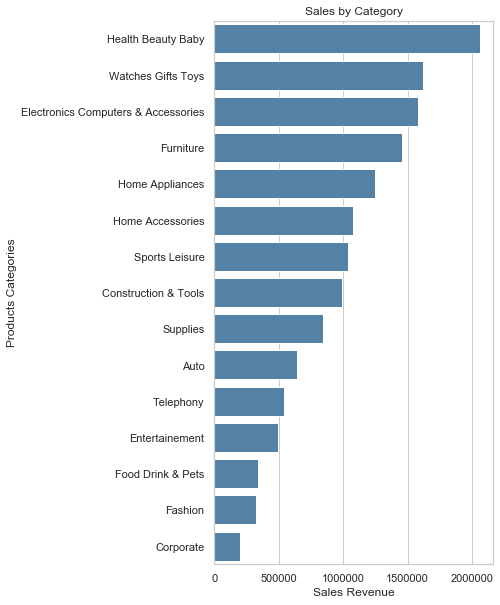

In [196]:
# répartition des ventes par catégorie de produit
df_sales_categ = df_orders.groupby(
    'product_cat',
    as_index=False).agg({'total_price': ['sum']})
df_sales_categ.columns = ['product_cat',
                          'sales']
df_sales_categ = df_sales_categ.sort_values(by=['sales'],
                                            ascending=False)
fig, ax = plt.subplots(figsize=(5, 10))
ax = sns.barplot(y='product_cat',
                 x='sales',
                 color='Steelblue',
                 data=df_sales_categ)
ax.set(xlabel='Sales Revenue',
       ylabel='Products Categories',
       title='Sales by Category')

In [197]:
df_orders.columns

Index(['order_id', 'customer_id', 'order_purchase_timestamp',
       'order_purchase_year', 'order_purchase_month', 'order_purchase_day',
       'order_purchase_dayofweek', 'order_purchase_hour',
       'order_purchase_month_label', 'order_purchase_dayofweek_label',
       'time_zone_hour', 'time_zone_day', 'purchase_time_zone_cat',
       'estimated_delivery_time', 'effective_delivery_time',
       'delivery_vs_estimated', 'delivery_vs_estimated_lvl', 'items_qty',
       'products_qty', 'most_important_product', 'total_price',
       'total_freight', 'freight_percentage', 'freight_percentage_lvl',
       'charm_price', 'total_price_class', 'charmed_price_cat', 'product_id',
       'seller_id', 'product_price', 'product_freight', 'product_name_length',
       'product_description_length', 'product_photos_qty', 'product_weight_g',
       'product_size', 'product_qlty_index', 'product_qlty_index_lvl',
       'product_density', 'product_cat', 'main_payment_type',
       'main_payment_valu

In [198]:
# répartition des ventes en fonction du Charm price
df_sales_charm = df_orders[df_orders['total_price'] < 200].groupby(
    'charm_price',
    as_index=False).agg({'total_price': ['sum'],
                        'order_id': ['count']})
df_sales_charm.columns = ['charm_price',
                          'sales',
                          'qty']
df_sales_charm['avg_sale'] = df_sales_charm['sales'] / df_sales_charm['qty']
df_sales_charm = df_sales_charm.sort_values(by=['avg_sale'],
                                            ascending=False)
df_sales_charm

,charm_price,sales,qty,avg_sale
0,0,2.070694e+06,25121,82.428803
1,1,4.678155e+06,57482,81.384698


Le revenu généré par les articles Charm Price n'est que le double de celui sans Charm Price, cependant qu'il sont plus de 2 fois plus souvent achetés : cela conduit à un revenu moyen des articles en Charm Price inférieur à celui des autres articles.

In [199]:
df_orders[df_orders['items_qty'] == 'multi_items'].sample(7)

,order_id,customer_id,order_purchase_timestamp,order_purchase_year,order_purchase_month,order_purchase_day,order_purchase_dayofweek,order_purchase_hour,order_purchase_month_label,order_purchase_dayofweek_label,time_zone_hour,time_zone_day,purchase_time_zone_cat,estimated_delivery_time,effective_delivery_time,delivery_vs_estimated,delivery_vs_estimated_lvl,items_qty,products_qty,most_important_product,total_price,total_freight,freight_percentage,freight_percentage_lvl,charm_price,total_price_class,charmed_price_cat,product_id,seller_id,product_price,product_freight,product_name_length,product_description_length,product_photos_qty,product_weight_g,product_size,product_qlty_index,product_qlty_index_lvl,product_density,product_cat,main_payment_type,main_payment_value,payment_sequence_size,payment_installments_size,payment_total,payment_sequence_size_cat,payment_installment_size_cat,main_payment_type_cat
22409,a23760b9274db6304cc3cc0085583693,13b998c33df7f51c51078cf30c1ceed7,2017-09-10 15:36:39,2017,9,10,6,15,Sep,Sun,PM,WE,WE,30,36,-6,Later_Delivery,multi_items,single_product,83305c6ed635e62d461539dae8a11487,300.00,34.98,10.442414,Low_FreightCost,0,F,Uncharmed_Price,83305c6ed635e62d461539dae8a11487,4869f7a5dfa277a7dca6462dcf3b52b2,150.00,17.49,51.0,668.0,1,300.0,512.0,0.337953,Low_QltyIdx,1.195860e+10,Watches Gifts Toys,credit_card,334.98,1.0,8.0,334.98,mono_payment,single_payment,Credit_Card_PayType
79514,eef98923f3fe58345e2aa0ff71f97bd7,2f3f1e169a5eca20dac6c858857b99b4,2018-06-02 14:24:17,2018,6,2,5,14,Jun,Sat,PM,WE,WE,39,16,22,Sooner_Delivery,multi_items,single_product,b532349fe46b38fbc7bb3914c1bdae07,70.00,32.64,31.800468,High_FreightCost,0,D,Uncharmed_Price,b532349fe46b38fbc7bb3914c1bdae07,1025f0e2d44d7041d6cf58b6550e0bfa,35.00,16.32,49.0,829.0,1,850.0,10000.0,0.342325,Low_QltyIdx,6.617717e+11,Furniture,boleto,102.64,1.0,1.0,102.64,mono_payment,single_payment,Other_PayType
49130,169ec5c8e238376cc87f2984cb173f1e,51ea522afbbad2a724b932b9d58d3295,2018-08-03 10:56:56,2018,8,3,4,10,Aug,Fri,AM,WD,AM-WD,16,12,4,Later_Delivery,multi_items,single_product,1a3577790b3f28eb137b105c4d62ca17,57.26,30.60,34.828136,High_FreightCost,0,D,Uncharmed_Price,1a3577790b3f28eb137b105c4d62ca17,94b9108d4b637ba65bb4f1e53cfcf8d8,28.63,15.30,50.0,703.0,3,590.0,14688.0,0.527604,High_QltyIdx,6.746895e+11,Electronics Computers & Accessories,credit_card,87.86,1.0,1.0,87.86,mono_payment,single_payment,Credit_Card_PayType
68299,442c441e8e8588cbf0f462423f7d864b,eacdd50c53863a0addb2f31544628198,2018-07-09 10:22:48,2018,7,9,0,10,Jul,Mon,AM,WD,AM-WD,8,3,5,Later_Delivery,multi_items,single_product,fcda3a9193321b42d5b6177aa4f9e3ed,29.80,17.64,37.183811,High_FreightCost,1,C,Charmed_Price,fcda3a9193321b42d5b6177aa4f9e3ed,f8db351d8c4c4c22c6835c19a46f01b0,14.90,8.82,60.0,695.0,2,300.0,1536.0,0.566585,High_QltyIdx,3.587581e+10,Construction & Tools,boleto,47.44,1.0,1.0,47.44,mono_payment,single_payment,Other_PayType
72997,6215b65b1a79cc034605e477320e37c3,84309b932d949c30b561e2900fa86678,2017-11-29 11:11:52,2017,11,29,2,11,Nov,Wed,AM,WD,AM-WD,29,13,16,Sooner_Delivery,multi_items,single_product,921a192e87274fd48d2e395b0a4facea,37.80,68.30,64.373233,High_FreightCost,0,C,Uncharmed_Price,921a192e87274fd48d2e395b0a4facea,128639473a139ac0f3e5f5ade55873a5,18.90,34.15,42.0,214.0,1,300.0,5400.0,0.271753,Low_QltyIdx,1.261259e+11,Electronics Computers & Accessories,credit_card,106.10,1.0,1.0,106.10,mono_payment,single_payment,Credit_Card_PayType
47888,46a679ffe9f1dfbb33d7e6795a2ed65e,376b09019901a4e8c4006c34cdb0d154,2018-05-03 09:59:53,2018,5,3,3,9,May,Thu,AM,WD,AM-WD,21,7,14,Nominal_Delivery,multi_items,single_product,e4ca5b20cfe1a020e15e36fe14e880ee,39.80,26.94,40.365598,High_FreightCost,1,C,Charmed_Price,e4ca5b20cfe1a020e15e36fe14e880ee,128639473a139ac0f3e5f5ade55873a5,19.90,13.47,46.0,331.0,1,125.0,4680.0,0.297905,Low_QltyIdx,4.554546e+10,Electronics Computers & Accessories,credit_card,66.74,1.0,1.0,66.74,mono_payment,single_payment,Credit_Card_PayType
1907,b7a098563d93a0a1f918772c

## 6.3. Evolution mensuelle des ventes

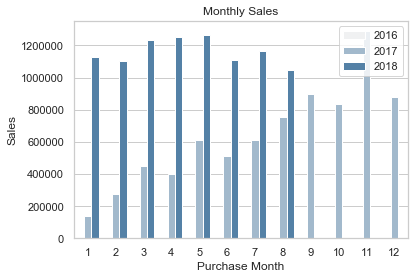

In [200]:
# évolution mensuelle des ventes
df_sales_month = df_orders.groupby(
    ['order_purchase_year', 'order_purchase_month'],
    as_index=False).agg({'payment_total': ['sum']})
df_sales_month.columns = ['order_purchase_year',
                          'order_purchase_month',
                          'sales']
ax = sns.barplot(x='order_purchase_month',
                 y='sales',
                 hue='order_purchase_year',
                 color='Steelblue',
                 data=df_sales_month)
ax.set(xlabel='Purchase Month',
       ylabel='Sales',
       title='Monthly Sales')
plt.legend(loc='upper right')

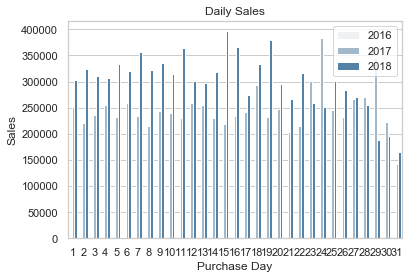

In [201]:
# évolution des ventes au cours du mois
df_sales_day = df_orders.groupby(
    ['order_purchase_year', 'order_purchase_day'],
    as_index=False).agg({'payment_total': ['sum']})
df_sales_day.columns = ['order_purchase_year',
                        'order_purchase_day',
                        'sales']
ax = sns.barplot(x='order_purchase_day',
                 y='sales',
                 hue='order_purchase_year',
                 color='Steelblue',
                 data=df_sales_day)
ax.set(xlabel='Purchase Day',
       ylabel='Sales',
       title='Daily Sales')
plt.legend(loc='upper right')

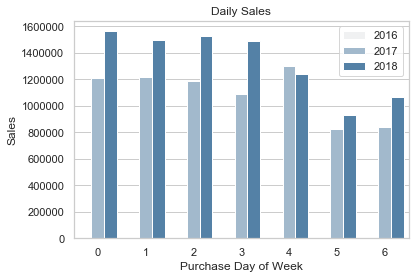

In [202]:
# évolution des ventes au cours de la semaine
df_sales_dayofweek = df_orders.groupby(
    ['order_purchase_year', 'order_purchase_dayofweek'],
    as_index=False).agg({'payment_total': ['sum']})
df_sales_dayofweek.columns = ['order_purchase_year',
                              'order_purchase_dayofweek',
                              'sales']
ax = sns.barplot(x='order_purchase_dayofweek',
                 y='sales',
                 hue='order_purchase_year',
                 color='Steelblue',
                 data=df_sales_dayofweek)
ax.set(xlabel='Purchase Day of Week',
       ylabel='Sales',
       title='Daily Sales')
plt.legend(loc='upper right')

In [203]:
df_orders['purchase_time_zone_cat']

0             AM-WD
1        Evening-WD
2             AM-WD
3                WE
4        Evening-WD
            ...    
98887         AM-WD
98888            WE
98889    Evening-WD
98890    Evening-WD
98891    Evening-WD
Name: purchase_time_zone_cat, Length: 98889, dtype: object

In [204]:
# niveau des ventes par purchase_time_zone
df_sales_time_zone = df_orders.groupby(
    ['purchase_time_zone_cat', 'order_purchase_year'],
    as_index=False).agg({'payment_total': ['sum']})
df_sales_time_zone.columns = ['purchase_time_zone_cat',
                              'order_purchase_year',
                              'sales']

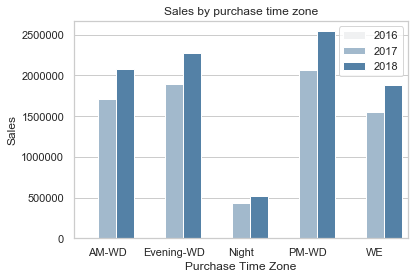

In [205]:
# afficher l'histogramme
ax = sns.barplot(x='purchase_time_zone_cat',
                 y='sales',
                 hue='order_purchase_year',
                 color='Steelblue',
                 data=df_sales_time_zone)
ax.set(xlabel='Purchase Time Zone',
       ylabel='Sales',
       title='Sales by purchase time zone')
plt.legend(loc='upper right')

## 6.4 Niveaux de paiements

C:\Users\etien\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


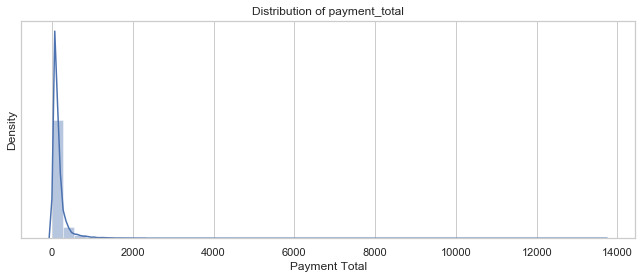

Paiements moyens  : 171


In [206]:
# observer les valeurs de paiements
distribution(df_orders,
             'payment_total',
             'Payment Total',
             'dist')
print('Paiements moyens  : %d'
      % df_orders['payment_total'].mean())

In [207]:
pd.qcut(df_orders['payment_total'], 4)

0            (9.589, 63.27]
1          (108.03, 184.56]
2          (108.03, 184.56]
3           (63.27, 108.03]
4            (9.589, 63.27]
                ...        
98887    (184.56, 13664.08]
98888    (184.56, 13664.08]
98889    (184.56, 13664.08]
98890    (184.56, 13664.08]
98891       (63.27, 108.03]
Name: payment_total, Length: 98889, dtype: category
Categories (4, interval[float64]): [(9.589, 63.27] < (63.27, 108.03] < (108.03, 184.56] < (184.56, 13664.08]]

In [208]:
# répartir en niveaux de payment
df_orders['payment_lvl'] = pd.qcut(
    df_orders['payment_total'],
    4,
    labels=['Light_Payment',
            'UnderMed_Payment',
            'OverMed_Payment',
            'Heavy_Payment'])

Text(0.5, 1.02, 'Payment Levels')

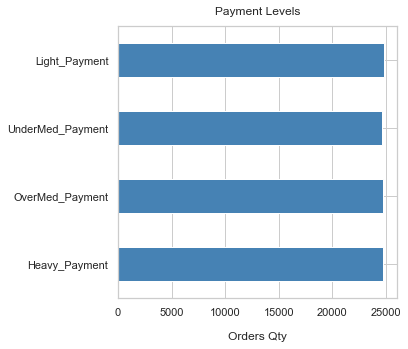

In [209]:
# observer la répartition des niveaux de payment
df_orders['payment_lvl'].value_counts(sort=False).plot(
    kind='barh',
    color='steelblue',
    figsize=(5, 5)).invert_yaxis()
plt.xlabel('Orders Qty', labelpad=14)
plt.title('Payment Levels', y=1.02)

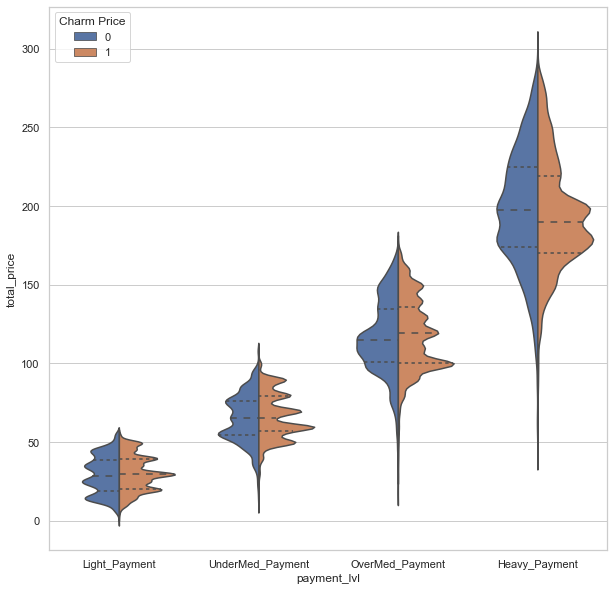

In [210]:
fig, ax = plt.subplots(figsize=(10, 10))
ax = sns.violinplot(x='payment_lvl',
                    y='total_price',
                    hue='charm_price',
                    data=df_orders[(df_orders['payment_total'] < 300)],
                    split=True,
                    inner='quartile')
plt.legend(title='Charm Price', loc='upper left')

Ce type d'investigation permet de nuancer l'intérêt du Charm Price, qui dans ce cas a une efficacité variable selon la plage de dépense. Les prix élevés ne sont pas en Charm Price, les effets de seuils doivent être pris en compte, car selon le cas les dépenses sont plus ou moins élevées.

Par ailleurs, deux observations émises précédemment sont à considérer pour définir un feature plus judicieusement : 
- d'une part, le payment_total en intégrant le freight cost, a perdu l'information du prix affiché contrairement au total_price,
- d'autre part, le découpage des prix sur la base des effectifs de commandes fait perdre la notion de revenu généré.

On décide de définir un feature product_price_level avec ces caractéristiques.

In [211]:
# découper le prix total en niveaux
bins = [0, 100, 200, 500, np.inf]
values = ['Light_Price', 'Medium_Price', 'High_Price', 'Heavy_Price']
df_orders['product_price_lvl'] = pd.cut(df_orders['total_price'], bins, labels=values)

[Text(0, 0.5, 'Price levels'),
 Text(0.5, 0, 'Sales Revenue'),
 Text(0.5, 1.0, 'Sales by Price levels')]

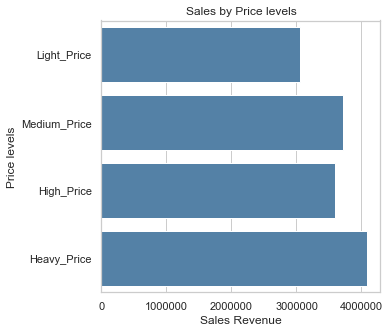

In [212]:
# répartition des revenus par catégorie de prix
df_sales_price_lvl = df_orders.groupby(
    'product_price_lvl',
    as_index=False).agg({'total_price': ['sum']})
df_sales_price_lvl.columns = ['product_price_lvl',
                              'sales']
df_sales_price_lvl = df_sales_price_lvl.sort_values(by=['sales'],
                                                    ascending=False)
fig, ax = plt.subplots(figsize=(5, 5))
ax = sns.barplot(y='product_price_lvl',
                 x='sales',
                 color='Steelblue',
                 data=df_sales_price_lvl)
ax.set(xlabel='Sales Revenue',
       ylabel='Price levels',
       title='Sales by Price levels')

# 7. Données géographiques

Geolocation détaille toutes les paires {lat, lng}, associée à un zip_code_prefix, avec toute une diversité pour chaque {city, state}.
Pour conserver une exploitabilité et une signification marketing (zone géographiques, distances, etc.) on propose de préserver une donnée de localisation simple {lat mean, lng mean} qui sera associé à chaque ville {city, state}. <br/>
Pour dériver une distance entre le client et le vendeur, on propose de conserver les données précises.

In [213]:
# aperçu des données geolocation
df_geolocation.sample(3)

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
251748,11370,-23.950194,-46.383430,sao vicente,SP
123065,5326,-23.543410,-46.757322,sao paulo,SP
498848,26311,-22.713309,-43.568749,queimados,RJ


In [214]:
# observer la taille des données
df_geolocation.sample(3)

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
267752,12050,-23.016616,-45.571128,taubate,SP
678013,41720,-12.974199,-38.439558,salvador,BA
530203,29144,-20.345632,-40.390135,cariacica,ES


In [215]:
# observer les zip_code unique
len(df_geolocation['geolocation_zip_code_prefix'].unique())

19015

Cette table est surabondante et indique que pour un zip_code donnée, il existe des coordonnées différentes. On testera donc s'il vaut mieux fusionner à partir du zip_code ou du couple {city, state}, selon la qualité du résultat.

In [216]:
df_geolocation.isna().sum()

geolocation_zip_code_prefix    0
geolocation_lat                0
geolocation_lng                0
geolocation_city               0
geolocation_state              0
dtype: int64

In [217]:
# aperçu des données géographiques pour customers
df_customers.sample(3)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_count
52771,80cf670a331be31a70e4c0ea3cf582b7,32c4208a5e9c5043b971d31e4a21c8d4,3027,sao paulo,SP,1
56622,f018c56ce8780824e560b3d4ce8486ac,1e0fa0cd18e9433132c10ff7df409dc3,35164,ipatinga,MG,1
63911,762ead3b312e57a6b06819bcfdafb241,f70229d801bae97a123d6330122228ee,12903,braganca paulista,SP,1


In [218]:
df_customers.isna().sum()

customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
order_count                 0
dtype: int64

In [219]:
# aperçu des données géographiques pour sellers
df_sellers.sample(3)

,seller_id,seller_zip_code_prefix,seller_city,seller_state
2492,2235cf78d3e2073a88146a9cb60f0dd0,4547,sao paulo,SP
2667,5566627eab3fe93fd6ee08798226101a,83005,sao jose dos pinhais,PR
1606,e628d4a53c109f09ca88098338b3a3f5,30170,belo horizonte,MG


In [220]:
df_sellers.isna().sum()

seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

## 7.1. Rationalisation des données géographiques

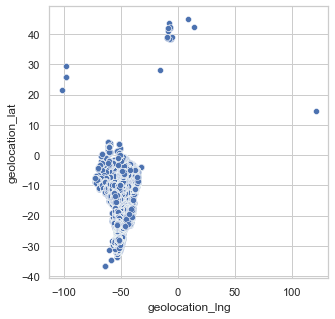

In [221]:
# afficher la répartion des localisations détaillées
fig, ax = plt.subplots(figsize=(5, 5))
ax = sns.scatterplot(x='geolocation_lng',
                     y='geolocation_lat',
                     data=df_geolocation)

In [222]:
# identifier les localisations hors Brésil
cols = ['geolocation_city',
        'geolocation_state',
        'geolocation_lat',
        'geolocation_lng']
mask = (df_geolocation['geolocation_lat'] > 10)
print(df_geolocation[cols][mask].shape)
df_geolocation[cols][mask].sample(7)

(26, 4)


,geolocation_city,geolocation_state,geolocation_lat,geolocation_lng
514429,raposo,RJ,38.381672,-6.328200
769351,porto trombetas,PA,42.166805,-6.898531
585260,santana do paraiso,MG,25.995245,-98.078533
538557,santo antonio do canaa,ES,21.657547,-101.466766
538512,santo antônio do canaã,ES,29.409252,-98.484121
769436,porto trombetas,PA,42.167251,-6.898559
769333,porto trombetas,PA,41.146203,-8.577855


In [223]:
# retirer les localisations marginales
df_geolocation = df_geolocation[df_geolocation['geolocation_lat'] < 10].copy()

In [224]:
# normaliser les noms de ville, et effet de la normalisation
print('geoloc cities : '
      + str(df_geolocation['geolocation_city'].unique().size))
df_geolocation['geolocation_city'] = df_geolocation['geolocation_city'].str\
    .normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
print('geoloc cities norm : '
      + str(df_geolocation['geolocation_city'].unique().size))
print('customers cities : '
      + str(df_customers['customer_city'].unique().size))
df_customers['customer_city'] = df_customers['customer_city'].str\
    .normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
print('customers cities norm : '
      + str(df_customers['customer_city'].unique().size))
print('sellers cities : '
      + str(df_sellers['seller_city'].unique().size))
df_sellers['seller_city'] = df_sellers['seller_city'].str\
    .normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
print('sellers cities norm : '
      + str(df_sellers['seller_city'].unique().size))
# améliorer la lisibilité en écriture type "title"
df_customers['customer_city'] = df_customers['customer_city'].str.title()
df_sellers['seller_city'] = df_sellers['seller_city'].str.title()
df_geolocation['geolocation_city'] = df_geolocation['geolocation_city'].str.title()

geoloc cities : 8007
geoloc cities norm : 5965
customers cities : 4119
customers cities norm : 4119
sellers cities : 611
sellers cities norm : 609


In [225]:
# simplifier par une latitude unique {ville, état}
df_geolocation['unique_city_geolocation_lat'] = df_geolocation.groupby(
    ['geolocation_city',
     'geolocation_state']
)['geolocation_lat'].transform(lambda x: x.mean())

In [226]:
# simplifier par une latitude unique {ville, état}
df_geolocation['unique_city_geolocation_lng'] = df_geolocation.groupby(
    ['geolocation_city',
     'geolocation_state']
)['geolocation_lng'].transform(lambda x: x.mean())

In [227]:
# simplifier par une latitude unique sur zip_code
df_geolocation['unique_zip_geolocation_lat'] = df_geolocation.groupby(
    ['geolocation_zip_code_prefix']
)['geolocation_lat'].transform(lambda x: x.mean())

In [228]:
# simplifier par une latitude unique sur zip_code
df_geolocation['unique_zip_geolocation_lng'] = df_geolocation.groupby(
    ['geolocation_zip_code_prefix']
)['geolocation_lng'].transform(lambda x: x.mean())

In [229]:
# observer le résultat des traitements
df_geolocation.sample(3)

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state,unique_city_geolocation_lat,unique_city_geolocation_lng,unique_zip_geolocation_lat,unique_zip_geolocation_lng
997652,99470,-28.461714,-52.814918,Nao-Me-Toque,RS,-28.461117,-52.819327,-28.461117,-52.819327
888607,86400,-23.152492,-49.987851,Jacarezinho,PR,-23.158367,-49.976621,-23.158367,-49.976621
518778,28610,-22.281195,-42.533460,Nova Friburgo,RJ,-22.279975,-42.526645,-22.284797,-42.531654


In [230]:
# conserver une seule localisation détaillée par zip_code
print('geoloc with duplicates shape : '
      + str(df_geolocation.shape))
df_unique_zip_geolocation =\
    df_geolocation.drop_duplicates(['geolocation_zip_code_prefix']).copy()
print('geoloc unique zip_code shape : '
      + str(df_unique_zip_geolocation.shape))

geoloc with duplicates shape : (1000137, 9)
geoloc unique zip_code shape : (19011, 9)


In [231]:
# conserver une seule localisation détaillée par {city, state}
print('geoloc with duplicates shape : '
      + str(df_geolocation.shape))
df_unique_city_geolocation =\
    df_geolocation.drop_duplicates(['geolocation_city',
                                    'geolocation_state']).copy()
print('geoloc unique city, state shape : '
      + str(df_unique_city_geolocation.shape))

geoloc with duplicates shape : (1000137, 9)
geoloc unique city, state shape : (6345, 9)


In [232]:
# aggréger la localisation unique pour customers sur {city, state}
df_customers = df_customers.merge(
    df_unique_city_geolocation,
    how='left',
    left_on=['customer_city', 'customer_state'],
    right_on=['geolocation_city', 'geolocation_state'])

In [233]:
df_customers.isna().sum()

customer_id                     0
customer_unique_id              0
customer_zip_code_prefix        0
customer_city                   0
customer_state                  0
order_count                     0
geolocation_zip_code_prefix    78
geolocation_lat                78
geolocation_lng                78
geolocation_city               78
geolocation_state              78
unique_city_geolocation_lat    78
unique_city_geolocation_lng    78
unique_zip_geolocation_lat     78
unique_zip_geolocation_lng     78
dtype: int64

In [234]:
# réagencer les colonnes customers
df_customers = df_customers.rename(columns={
    'unique_city_geolocation_lat': 'customer_lat',
    'unique_city_geolocation_lng': 'customer_lng'})
df_customers = df_customers.drop(
    columns=['customer_zip_code_prefix',
             'geolocation_zip_code_prefix',
             'unique_zip_geolocation_lng',
             'unique_zip_geolocation_lat',
             'geolocation_city',
             'geolocation_state',
             'geolocation_lat',
             'geolocation_lng'])

In [235]:
# retirer les valeurs manquantes et controler la taille résultante
print(df_customers.shape)
df_customers = df_customers.dropna().copy()
print(df_customers.shape)

(99441, 7)
(99363, 7)


In [236]:
# aggréger la localisation unique pour sellers sur zip_code
df_sellers = df_sellers.merge(
    df_unique_zip_geolocation,
    how='left',
    left_on=['seller_zip_code_prefix'],
    right_on=['geolocation_zip_code_prefix'])

In [237]:
# réagencer les colonnes sellers (idem customers)
df_sellers = df_sellers.rename(columns={
    'unique_zip_geolocation_lat': 'seller_lat',
    'unique_zip_geolocation_lng': 'seller_lng'})
df_sellers = df_sellers.drop(
    columns=['seller_zip_code_prefix',
             'unique_city_geolocation_lat',
             'unique_city_geolocation_lng',
             'geolocation_zip_code_prefix',
             'geolocation_city',
             'geolocation_state',
             'geolocation_lat',
             'geolocation_lng'])

In [238]:
# contrôler les valeurs manquantes
df_sellers.isna().sum()

seller_id       0
seller_city     0
seller_state    0
seller_lat      7
seller_lng      7
dtype: int64

In [239]:
# retirer les valeurs manquantes et controler la taille résultante
print(df_sellers.shape)
df_sellers = df_sellers.dropna().copy()
print(df_sellers.shape)

(3095, 5)
(3088, 5)


In [240]:
# observer le résultat pour sellers
df_sellers.sample(3)

,seller_id,seller_city,seller_state,seller_lat,seller_lng
440,cb8bcce248bb1fb274ba762d8b971456,Santa Rita Do Sapucai,MG,-22.247211,-45.707521
2860,c9d2ba8dde44a275ae06475ed1d2fafc,Uberlandia,MG,-18.913248,-48.278212
933,74bafed391319577bce6f4d2acc0589a,Sao Paulo,SP,-23.564505,-46.652793


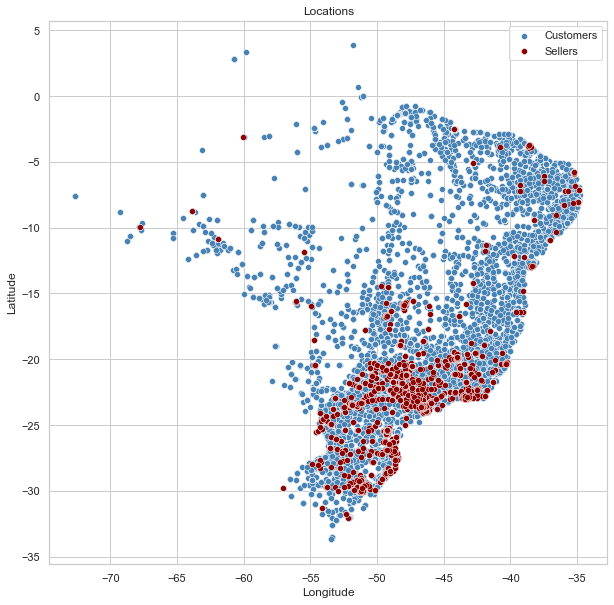

In [241]:
# affichier la nouvelle répartion (carte)
fig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(x='customer_lng',
                y='customer_lat',
                color='steelblue',
                data=df_customers,
                label='Customers')
sns.scatterplot(x='seller_lng',
                y='seller_lat',
                color='darkred',
                data=df_sellers,
                label='Sellers')
plt.title('Locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [242]:
# retirer les colonnes obsolètes ?
df_sellers.columns

Index(['seller_id', 'seller_city', 'seller_state', 'seller_lat', 'seller_lng'], dtype='object')

In [243]:
# aggréger aux commandes les localisations customers et sellers
df_orders = df_orders.merge(
    df_sellers,
    how='left',
    left_on=['seller_id'],
    right_on=['seller_id'])
df_orders = df_orders.merge(
    df_customers,
    how='left',
    left_on=['customer_id'],
    right_on=['customer_id'])

In [244]:
df_orders.isna().sum()

order_id                            0
customer_id                         0
order_purchase_timestamp            0
order_purchase_year                 0
order_purchase_month                0
order_purchase_day                  0
order_purchase_dayofweek            0
order_purchase_hour                 0
order_purchase_month_label          0
order_purchase_dayofweek_label      0
time_zone_hour                      0
time_zone_day                       0
purchase_time_zone_cat              0
estimated_delivery_time             0
effective_delivery_time             0
delivery_vs_estimated               0
delivery_vs_estimated_lvl           0
items_qty                           0
products_qty                        0
most_important_product              0
total_price                         0
total_freight                       0
freight_percentage                  0
freight_percentage_lvl              0
charm_price                         0
total_price_class                   0
charmed_pric

cette aggrégation minimise les données manquantes, mais de nouvelles données sont perdues du fait de l'absence de données de géolocalisation pour les id de clients et vendeurs.

In [245]:
# retirer les valeurs manquantes et controler la taille résultante
print(df_orders.shape)
df_orders = df_orders.dropna().copy()
print(df_orders.shape)

(98889, 60)
(98589, 60)


In [246]:
df_orders.sample(7)

,order_id,customer_id,order_purchase_timestamp,order_purchase_year,order_purchase_month,order_purchase_day,order_purchase_dayofweek,order_purchase_hour,order_purchase_month_label,order_purchase_dayofweek_label,time_zone_hour,time_zone_day,purchase_time_zone_cat,estimated_delivery_time,effective_delivery_time,delivery_vs_estimated,delivery_vs_estimated_lvl,items_qty,products_qty,most_important_product,total_price,total_freight,freight_percentage,freight_percentage_lvl,charm_price,total_price_class,charmed_price_cat,product_id,seller_id,product_price,product_freight,product_name_length,product_description_length,product_photos_qty,product_weight_g,product_size,product_qlty_index,product_qlty_index_lvl,product_density,product_cat,main_payment_type,main_payment_value,payment_sequence_size,payment_installments_size,payment_total,payment_sequence_size_cat,payment_installment_size_cat,main_payment_type_cat,payment_lvl,product_price_lvl,seller_city,seller_state,seller_lat,seller_lng,customer_unique_id,customer_city,customer_state,order_count,customer_lat,customer_lng
47061,84484948cf71be13d3b7d3ce0898f403,6c21ff098ffce3eae8a87154b57de236,2018-03-08 16:02:02,2018,3,8,3,16,Mar,Thu,PM,WD,PM-WD,24,6,17,Sooner_Delivery,multi_items,single_product,ed7ba72ce7a0ce3d9b60d543329b1fa2,73.98,36.46,33.013401,High_FreightCost,1,D,Charmed_Price,ed7ba72ce7a0ce3d9b60d543329b1fa2,669ae81880e08f269a64487cfb287169,36.99,18.23,23.0,449.0,1,200.0,8000.0,0.256688,Low_QltyIdx,1.245688e+11,Sports Leisure,credit_card,110.44,1.0,1.0,110.44,mono_payment,single_payment,Credit_Card_PayType,OverMed_Payment,Light_Price,Rio Do Sul,SC,-27.214587,-49.637725,65de74a177ce142743628fc814d0ea64,Rondon,PR,1.0,-23.417472,-52.772676
29849,62dd396ac0abf39a27c18f75a5952fca,41ef6a2ec2be4d4d42ac9becc45dc57e,2017-05-04 09:02:38,2017,5,4,3,9,May,Thu,AM,WD,AM-WD,20,5,15,Sooner_Delivery,single_item,single_product,16ed6a6e3fce23b741650437fe58d65b,89.18,9.61,9.727705,Low_FreightCost,1,D,Charmed_Price,16ed6a6e3fce23b741650437fe58d65b,e5a38146df062edaf55c38afa99e42dc,89.18,9.61,49.0,1226.0,1,750.0,18375.0,0.358253,Low_QltyIdx,1.072946e+12,Home Appliances,credit_card,98.79,1.0,1.0,98.79,mono_payment,single_payment,Credit_Card_PayType,UnderMed_Payment,Light_Price,Sao Paulo,SP,-23.536247,-46.661665,9362cbd9f51b9558657af21b896aa6f7,Sao Paulo,SP,1.0,-23.571253,-46.633911
12222,e72e22dce48aaee824371b8e02641f15,d1ea8164411774eb6b46718f894eaace,2017-10-16 10:31:44,2017,10,16,0,10,Oct,Mon,AM,WD,AM-WD,17,9,8,Later_Delivery,single_item,single_product,588531f8ec37e7d5ff5b7b22ea0488f8,1437.00,34.51,2.345210,Low_FreightCost,0,H,Uncharmed_Price,588531f8ec37e7d5ff5b7b22ea0488f8,53243585a1d6dc2643021fd1853d8905,1437.00,34.51,55.0,3611.0,4,2750.0,19344.0,0.629019,High_QltyIdx,4.141601e+12,Electronics Computers & Accessories,credit_card,1471.51,1.0,12.0,1471.51,mono_payment,single_payment,Credit_Card_PayType,Heavy_Payment,Heavy_Price,Lauro De Freitas,BA,-12.893167,-38.337875,8d2fb66164a84b76626513d628bee2da,Rio De Janeiro,RJ,1.0,-22.914911,-43.312877
34789,47476a4cdc9f6c8f0fb1517e2e557c5e,4d3549e2ac2a97c5f787e4c1f557173d,2018-02-25 22:36:17,2018,2,25,6,22,Feb,Sun,Evening,WE,WE,14,4,9,Nominal_Delivery,single_item,single_product,98ec655119c24de03b804696821f3955,49.90,8.27,14.216950,Nominal_FreightCost,1,C,Charmed_Price,98ec655119c24de03b804696821f3955,620c87c171fb2a6dd6e8bb4dec959fc6,49.90,8.27,46.0,586.0,1,200.0,12000.0,0.319803,Low_QltyIdx,1.868532e+11,Health Beauty Baby,credit_card,58.17,1.0,2.0,58.17,mono_payment,single_payment,Credit_Card_PayType,Light_Payment,Light_Price,Petropolis,RJ,-22.540797,-43.201235,9b6611989bb4797e0343e5340e20963a,Rio De Janeiro,RJ,1.0,-22.914911,-43.312877
65044,5c88e946e28e122cbb26c630e2f67f58,aabad376799f97beacc0d8b52a9bfa84,2018-06-03 20:27:39,2018,6,3,6,20,Jun,Sun,Evening,WE,WE,45,12,33,Sooner_Delivery,single_item,single_product,d6c084a3a3efeccb338446b39dd37316,141.09,23.49,14.272694,Nominal_FreightCost,0,E,Uncharmed_Price,d6c084a3a3efeccb338446b39dd37316,d1b9d4be4b6f9ebd85f

## 7.2. Distance Customer - Seller

Au vu de la virtualisation apportée par le e-commerce, on peut se demander si la notion distance est transparente pour les clients. On émet ici l'hypothèse que la localisation d'un vendeur correspond à celle de ses marchandises.

In [247]:
# calculer une distance entre customer et seller
df_orders['cust_sell_dist'] = \
    haversine(df_orders['customer_lat'],
              df_orders['customer_lng'],
              df_orders['seller_lat'],
              df_orders['seller_lng'])

C:\Users\etien\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


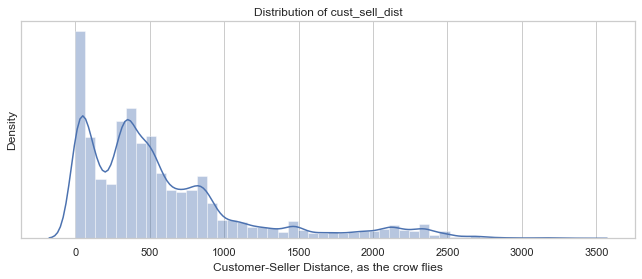

Distance moyenne entre Client et Vendeur : 589


In [248]:
# afficher la distribution de la distance sellers - customers
distribution(df_orders,
             'cust_sell_dist',
             'Customer-Seller Distance, as the crow flies',
             'dist')
print('Distance moyenne entre Client et Vendeur : %d'
      % df_orders['cust_sell_dist'].mean())

In [249]:
# créer / actualiser les commandes répartes par année
orders_2017 = df_orders[(df_orders['order_purchase_year'] == 2017) |
                        (df_orders['order_purchase_year'] == 2016)]
orders_2018 = df_orders[(df_orders['order_purchase_year'] == 2018)]

In [250]:
# observer la variation éventuelle entre 2017 et 2018
print('Variation distance acheteur-vendeur entre 2017 (ref) et 2018 : ' +
      str(round(orders_2017['cust_sell_dist'].mean() - orders_2018['cust_sell_dist'].mean())))

Variation distance acheteur-vendeur entre 2017 (ref) et 2018 : 49


on observe un éloignement géographique, peut-être lié à la popularité de la market-place au dela des zones d'origine : clients ou vendeurs plus éloignés des centres économiques.

In [251]:
# variation de la distance client - vendeur
df_orders['cust_sell_dist'].describe()

count    98589.000000
mean       589.652729
std        580.514935
min          0.000000
25%        177.367814
50%        428.863777
75%        786.518723
max       3397.283980
Name: cust_sell_dist, dtype: float64

In [252]:
# limites en cas de découpage en 3 niveaux
pd.qcut(df_orders['cust_sell_dist'], 3)

0          (-0.001, 302.391]
1        (617.392, 3397.284]
2         (302.391, 617.392]
3        (617.392, 3397.284]
4          (-0.001, 302.391]
                ...         
98884     (302.391, 617.392]
98885    (617.392, 3397.284]
98886     (302.391, 617.392]
98887     (302.391, 617.392]
98888    (617.392, 3397.284]
Name: cust_sell_dist, Length: 98589, dtype: category
Categories (3, interval[float64]): [(-0.001, 302.391] < (302.391, 617.392] < (617.392, 3397.284]]

In [253]:
# découper en 3 niveaux de distance
df_orders['cust_sell_dist_lvl'] = pd.qcut(
    df_orders['cust_sell_dist'],
    3,
    labels=['Near_Dist',
            'AroundMed_Dist',
            'Far_Dist'])

Text(0.5, 1.02, 'Customer-Seller Distance Levels')

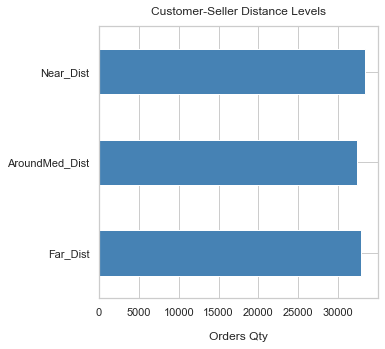

In [254]:
# contrôler la répartition des niveaux de distance
df_orders['cust_sell_dist_lvl'].value_counts(sort=False).plot(
    kind='barh',
    color='steelblue',
    figsize=(5, 5)).invert_yaxis()
plt.xlabel('Orders Qty', labelpad=14)
plt.title('Customer-Seller Distance Levels', y=1.02)

# 8. Review

Une review permet de remonter à la commande, mais pas au produit évalué, ce qui compromet l'exploitation détaillée.

In [255]:
# montrer un aperçu des review
df_reviews.sample(3)

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
49206,5f1862ed5ba89c82b7e1c2f3c68aee3b,8b5c910ccad3b27e2876ad9eb90bbb53,5,NaN,NaN,2017-10-24 00:00:00,2017-10-24 20:47:30
46952,1cd103c2f387996baba4064a51c0bc25,25a35f3ddac45387a6140eefc740d2a5,4,NaN,Produto comprado entregue dentro do prazo e se...,2017-08-25 00:00:00,2017-08-26 01:00:02
57128,a013ee5603aec964bd3d60cfb203ab73,7e1c037b1854670dd27cda995f9b11e2,1,Não Entregou o Combinado,Comprei este nobreak com 6 tomadas e me entreg...,2018-07-12 00:00:00,2018-07-12 18:00:35


In [256]:
df_reviews.isna().sum()

review_id                      0
order_id                       0
review_score                   0
review_comment_title       88285
review_comment_message     58247
review_creation_date           0
review_answer_timestamp        0
dtype: int64

In [257]:
# valeur possible des review score
df_reviews['review_score'].unique()

array([4, 5, 1, 3, 2], dtype=int64)

On ne dispose que des produits (bien) évalués !

In [258]:
# nb de commandes unique dans les données de review
df_reviews['order_id'].unique().size

99441

C:\Users\etien\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


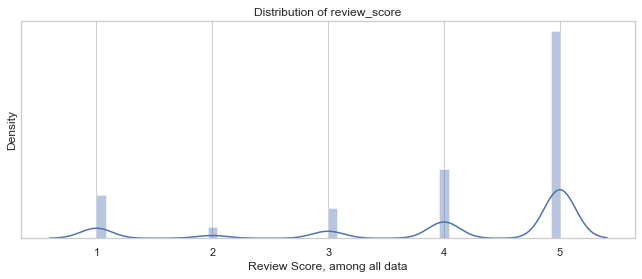

Average Review Score : 4


In [259]:
# afficher la distribution des review_score
distribution(df_reviews,
             'review_score',
             'Review Score, among all data',
             'dist')
print('Average Review Score : %d'
      % df_reviews['review_score'].mean())

Text(0.5, 1.02, 'review_score')

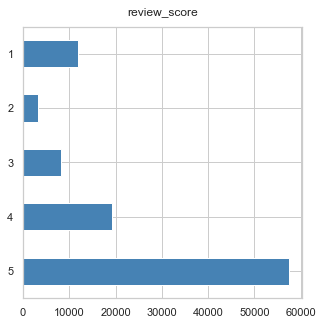

In [260]:
# observer la répartition des review scores
df_reviews['review_score'].value_counts(sort=False).plot(
    kind='barh',
    color='steelblue',
    figsize=(5, 5)).invert_yaxis()
plt.title('review_score', y=1.02)

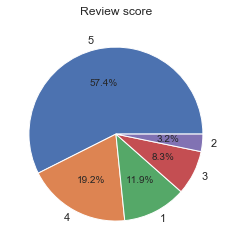

In [261]:
# observer la répartition des types de payment
plt.title('Review score', y=1.02)
plt.pie(df_reviews['review_score'].value_counts(),
        labels=df_reviews['review_score'].value_counts().index,
        autopct='%1.1f%%')
plt.show()

Une exploitation plus fine consisterait à valoriser la longueur du titre et du commentaire pour un aspect plus qualitatif.

## 8.1. Délai de réponse suite à une demande de review
Comportement évaluateur d'un client : délai de réponse.

In [262]:
# formater les champs date
for col in ['review_creation_date', 'review_answer_timestamp']:
    df_reviews[col] = pd.to_datetime(df_reviews[col], format='%Y-%m-%d %H:%M:%S')

In [263]:
df_reviews.isna().sum()

review_id                      0
order_id                       0
review_score                   0
review_comment_title       88285
review_comment_message     58247
review_creation_date           0
review_answer_timestamp        0
dtype: int64

In [264]:
# ordonner les reviews par valeur décroissante de dates
df_reviews = df_reviews.sort_values(by=['order_id', 'review_answer_timestamp'],
                                    ascending=False)

In [265]:
# retirer les doublons en gardant la review la plus récente
df_reviews.drop_duplicates(subset='order_id', keep='first', inplace=True)

In [266]:
# contrôler le traitement
print(df_reviews.shape[0] - df_reviews['order_id'].unique().size)

0


In [267]:
# calculer le délai de réponse (demande d'ajout d'une review)
df_reviews['review_answer_delay'] =\
    (df_reviews['review_answer_timestamp'] - df_reviews['review_creation_date']).dt.days

In [268]:
# retirer les colonnes obsolètes
df_reviews = df_reviews.drop(
    columns=['review_id',
             'review_comment_title',
             'review_comment_message',
             'review_answer_timestamp',
             'review_creation_date'])

In [269]:
# vérification du résultat
df_reviews.sample(3)

,order_id,review_score,review_answer_delay
72498,5bb7f13d8996f3b384e2820e7f7e8659,5,1
89753,6de9eb6ce81fb0d838d9d38e5f0b3b13,2,1
78085,fd6f101a1afb677198cf40cb3feb147d,5,3


In [270]:
df_reviews.isna().sum()

order_id               0
review_score           0
review_answer_delay    0
dtype: int64

In [271]:
df_reviews.describe()

,review_score,review_answer_delay
count,99441.000000,99441.000000
mean,4.070796,2.584186
std,1.359783,9.884802
min,1.000000,0.000000
25%,4.000000,1.000000
50%,5.000000,1.000000
75%,5.000000,3.000000
max,5.000000,518.000000


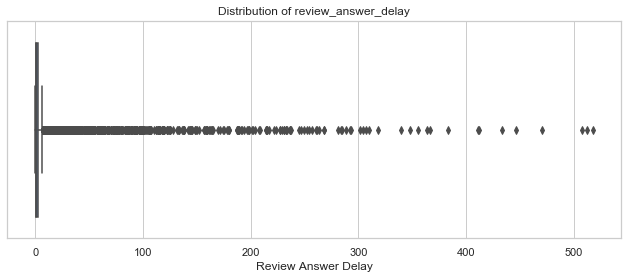

Average Review Answer Delay : 2


In [272]:
# afficher la distribution des délais de réponse
distribution(df_reviews,
             'review_answer_delay',
             'Review Answer Delay',
             'box')
print('Average Review Answer Delay : %d'
      % df_reviews['review_answer_delay'].mean())

In [273]:
# split en 3 niveaux de délais
df_reviews['review_answer_delay_lvl'] = pd.qcut(
    df_reviews['review_answer_delay'],
    3,
    labels=['Early_Answer',
            'Nominal_Answer',
            'Late_Answer'])

Text(0.5, 1.02, 'Review Delay ')

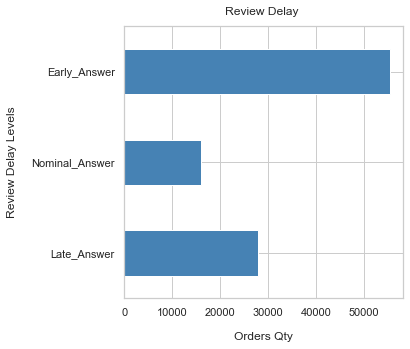

In [274]:
# nouvelle répartition des délais de réponse
df_reviews['review_answer_delay_lvl'].value_counts(sort=False).plot(
    kind='barh',
    color='steelblue',
    figsize=(5, 5)).invert_yaxis()
plt.xlabel('Orders Qty', labelpad=14)
plt.ylabel('Review Delay Levels', labelpad=14)
plt.title('Review Delay ', y=1.02)

In [275]:
# aggreger aux orders les reviews
df_orders = df_orders.merge(
    df_reviews,
    how='left',
    left_on=['order_id'],
    right_on=['order_id'])

## 8.2. Note moyenne donnée à chaque produit
Influence possible de la note d'un produit sur le comportement client (décompte et note moyenne)

In [276]:
# créer la note (décompte et moyenne)
df_prod_mean_score =\
    df_orders.groupby('product_id',
                      as_index=False).agg({'review_score': ['count',
                                                            'mean']})
df_prod_mean_score.columns = ['product_id',
                              'count',
                              'mean']

# afficher les 10 produits les plus notés
df_prod_mean_score = df_prod_mean_score.sort_values(by='count',
                                                    ascending=False)
df_prod_mean_score[:10]

,product_id,count,mean
19531,aca2eb7d00ea1a7b8ebd4e68314663af,515,4.046602
7634,422879e10f46682990de24d770e7f83d,437,4.002288
17426,99a4788cb24856965c36a24e339b6058,421,3.973872
6528,389d119b48cf3043d311335e499d9c6b,354,4.169492
6276,368c6c730842d78016ad823897a372db,341,4.058651
9562,53759a2ecddad2bb87a079a1f1519f73,327,3.984709
23861,d1c427060a0f73f6b889a5c7c61f2ac4,312,4.381410
9584,53b36df67ebb7c41585e8d54d6772e08,309,4.262136
2469,154e7e31ebfa092203795c972e5804a6,267,4.363296
7143,3dd2a17168ec895c781a9191c1e95ad7,265,4.245283


In [277]:
# retirer les colonnes obsolètes
df_orders = df_orders.drop(
    columns=['product_id'])

In [278]:
# renommer la colonne
df_prod_mean_score = df_prod_mean_score.rename(columns={
    'mean': 'product_review_mean',
    'count': 'product_review_count'})
# rattacher aux commandes la note moyenne
df_orders = df_orders.merge(
    df_prod_mean_score,
    how='left',
    left_on=['most_important_product'],
    right_on=['product_id'])

In [279]:
# retirer les colonnes redondantes
df_orders = df_orders.drop(
    columns=['product_id'])

C:\Users\etien\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


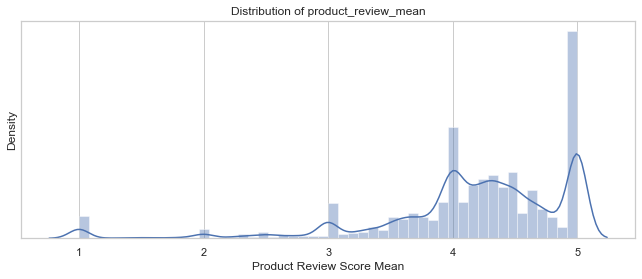

Average Product Review Score : 4


In [280]:
# afficher la distribution des product_review_mean
distribution(df_orders,
             'product_review_mean',
             'Product Review Score Mean',
             'dist')
print('Average Product Review Score : %d'
      % df_orders['product_review_mean'].mean())

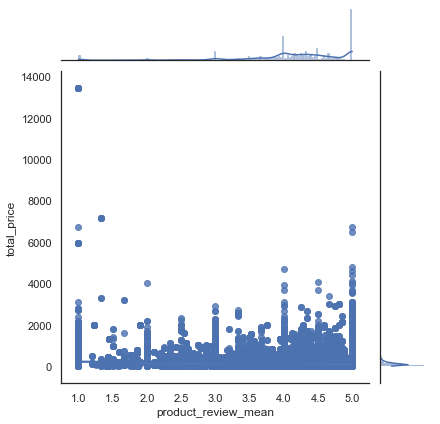

In [281]:
# évolution des dépense en fonction de la note du produit
with sns.axes_style('white'):
    sns.jointplot(data=df_orders,
                  x='product_review_mean',
                  y='total_price',
                  kind='reg')
plt.show()

In [282]:
# split en 3 niveaux de score
df_orders['product_review_mean_lvl'] = pd.qcut(
    df_orders['product_review_mean'],
    3,
    labels=['Low_Score',
            'Medium_Score',
            'Top_Score'])

Text(0.5, 1.02, 'Score Levels')

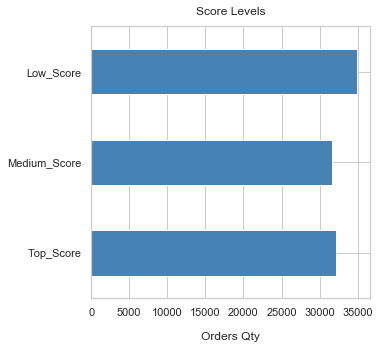

In [283]:
# Contrôler la répartition des niveaux de score
df_orders['product_review_mean_lvl'].value_counts(sort=False).plot(
    kind='barh',
    color='steelblue',
    figsize=(5, 5)).invert_yaxis()
plt.xlabel('Orders Qty', labelpad=14)
plt.title('Score Levels', y=1.02)

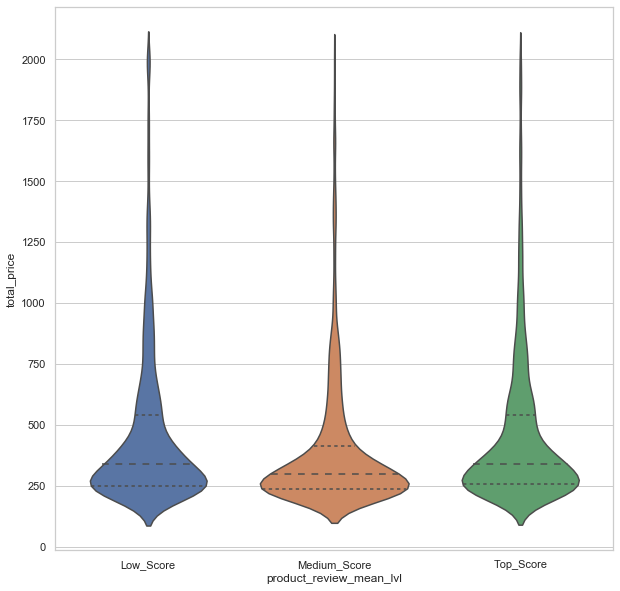

5:80: E501 line too long (80 > 79 characters)


In [284]:
fig, ax = plt.subplots(figsize=(10, 10))
ax = sns.violinplot(x='product_review_mean_lvl',
                    y='total_price',
                    order=['Low_Score', 'Medium_Score', 'Top_Score'],
                    data=df_orders[df_orders['total_price'].between(200, 2000)],
                    split=True,
                    inner='quartile')

In [285]:
# créer / actualiser les commandes répartes par année
orders_2017 = df_orders[(df_orders['order_purchase_year'] == 2017) |
                        (df_orders['order_purchase_year'] == 2016)]
orders_2018 = df_orders[(df_orders['order_purchase_year'] == 2018)]

In [286]:
# observer la variation éventuelle entre 2017 et 2018
print('Variation product_review_mean entre 2017 (ref) et 2018 : ' +
      str(round(orders_2017['product_review_mean'].mean() - orders_2018['product_review_mean'].mean(), 2)))

Variation product_review_mean entre 2017 (ref) et 2018 : 0.0


## 8.3. Note moyenne donnée par chaque client
Comportement évaluateur d'un client : décompte et note moyenne.

In [287]:
# créer la note (décompte et moyenne)
df_cust_mean_score = df_orders.groupby(
    'customer_unique_id',
    as_index=False).agg({'review_score': ['count',
                                          'mean']})
df_cust_mean_score.columns = ['customer_unique_id',
                              'count',
                              'mean']

# afficher les 10 clients donnant les meilleurs notes
df_cust_mean_score = df_cust_mean_score.sort_values(by='count',
                                                    ascending=False)
df_cust_mean_score[:10]

,customer_unique_id,count,mean
68252,c8460e4251689ba205045f3ea17884a1,24,4.0
36033,698e1cf81d01a3d389d96145f7fa6df8,20,1.0
66811,c402f431464c72e27330a67f7b94d4fb,20,1.0
5264,0f5ac8d5c31de21d2f25e24be15bbffb,18,5.0
6196,11f97da02237a49c8e783dfda6f50e8e,15,5.0
17060,31e412b9fb766b6794724ed17a41dfa6,14,1.0
84391,f7ea4eef770a388bd5b225acfc546604,14,1.0
48028,8d50f5eadf50201ccdcedfb9e2ac8455,14,5.0
40085,7582a5a77fc2976628f46a13ec91b375,13,3.0
45942,86df00dc5fd68f4dd5d5945ca19f3ed6,12,5.0


In [288]:
# rattacher au df via le customer_unique_id
df_cust_mean_score = df_cust_mean_score.rename(columns={
    'count': 'customer_review_count',
    'mean': 'customer_review_mean'})
# rattacher aux clients leur note moyenne
df_orders = df_orders.merge(
    df_cust_mean_score,
    how='left',
    left_on=['customer_unique_id'],
    right_on=['customer_unique_id'])

C:\Users\etien\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


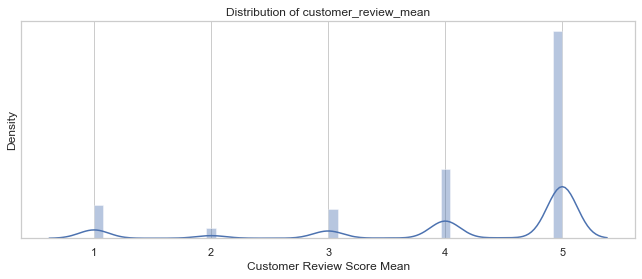

Average Customer Review Score : 4


In [289]:
# afficher la distribution des customer_review_mean
distribution(df_orders,
             'customer_review_mean',
             'Customer Review Score Mean',
             'dist')
print('Average Customer Review Score : %d'
      % df_orders['customer_review_mean'].mean())

In [290]:
# créer / actualiser les commandes répartes par année
orders_2017 = df_orders[(df_orders['order_purchase_year'] == 2017) |
                        (df_orders['order_purchase_year'] == 2016)]
orders_2018 = df_orders[(df_orders['order_purchase_year'] == 2018)]

In [291]:
# observer la variation éventuelle entre 2017 et 2018
print('Variation customer_review_mean entre 2017 (ref) et 2018 : ' +
      str(round(orders_2017['customer_review_mean'].mean() - orders_2018['customer_review_mean'].mean(), 2)))

Variation customer_review_mean entre 2017 (ref) et 2018 : 0.03


## 8.4 Ecart d'évaluation

Le Client évalue-t-il mieux ou moins bien les produits que la moyenne des autres évaluations effectuées pour un produit donné.

In [292]:
# calculer l'écart entre les évaluation moyennes client et globale
df_orders['review_gap'] = df_orders['customer_review_mean'] - df_orders['product_review_mean']

C:\Users\etien\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


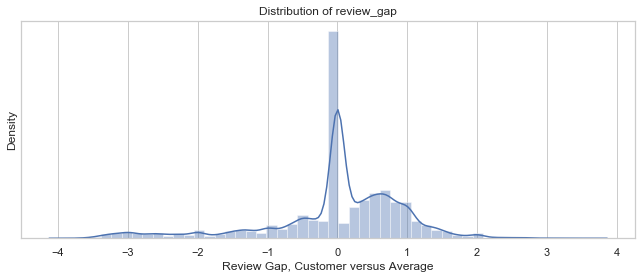

Average Review Gap : 0


In [293]:
# afficher la distribution du review_gap
distribution(df_orders,
             'review_gap',
             'Review Gap, Customer versus Average',
             'dist')
print('Average Review Gap : %d'
      % df_orders['review_gap'].mean())

In [294]:
# créer / actualiser les commandes répartes par année
orders_2017 = df_orders[(df_orders['order_purchase_year'] == 2017) |
                        (df_orders['order_purchase_year'] == 2016)]
orders_2018 = df_orders[(df_orders['order_purchase_year'] == 2018)]

In [295]:
# observer la variation éventuelle entre 2017 et 2018
print('Variation review_gap entre 2017 (ref) et 2018 : ' +
      str(round(orders_2017['review_gap'].mean() - orders_2018['review_gap'].mean(), 2)))

Variation review_gap entre 2017 (ref) et 2018 : 0.03


L'écart moyen est logiquement nul du fait que ce sont les notes des clients qui sont prises en compte pour le même scope de commandes, en revanche l'étalement de l'écart introduit une appréciation différente.

In [296]:
# catégoriser les écart de notation


def note(val):
    if (val == 0):
        return 'Same_Review'
    elif (val < 0):
        return 'Worst_Review'
    else:
        return 'Better_Review'


# dériver un feature identifiant qu'il y a plus de 3 usages
df_orders['review_gap_lvl'] = df_orders['review_gap'].apply(note)

# transformer en feature catégoriel
df_orders['review_gap_lvl'] = df_orders['review_gap_lvl'].astype('category')

Text(0.5, 1.02, 'Review Gap Levels Customers versus Average')

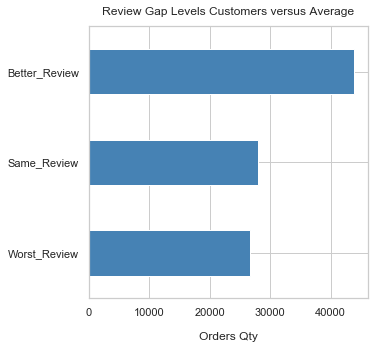

In [297]:
# observer la répartition écarts de score
df_orders['review_gap_lvl'].value_counts(sort=False).plot(
    kind='barh',
    color='steelblue',
    figsize=(5, 5)).invert_yaxis()
plt.xlabel('Orders Qty', labelpad=14)
plt.title('Review Gap Levels Customers versus Average', y=1.02)

Analyse de l'influence des délais de réception sur l'évaluation

In [298]:
df_orders.sample(3)

,order_id,customer_id,order_purchase_timestamp,order_purchase_year,order_purchase_month,order_purchase_day,order_purchase_dayofweek,order_purchase_hour,order_purchase_month_label,order_purchase_dayofweek_label,time_zone_hour,time_zone_day,purchase_time_zone_cat,estimated_delivery_time,effective_delivery_time,delivery_vs_estimated,delivery_vs_estimated_lvl,items_qty,products_qty,most_important_product,total_price,total_freight,freight_percentage,freight_percentage_lvl,charm_price,total_price_class,charmed_price_cat,seller_id,product_price,product_freight,product_name_length,product_description_length,product_photos_qty,product_weight_g,product_size,product_qlty_index,product_qlty_index_lvl,product_density,product_cat,main_payment_type,main_payment_value,payment_sequence_size,payment_installments_size,payment_total,payment_sequence_size_cat,payment_installment_size_cat,main_payment_type_cat,payment_lvl,product_price_lvl,seller_city,seller_state,seller_lat,seller_lng,customer_unique_id,customer_city,customer_state,order_count,customer_lat,customer_lng,cust_sell_dist,cust_sell_dist_lvl,review_score,review_answer_delay,review_answer_delay_lvl,product_review_count,product_review_mean,product_review_mean_lvl,customer_review_count,customer_review_mean,review_gap,review_gap_lvl
79263,b6230773d920876bc61d03d8b93263a9,cfd7ec5aba91084c10b80fa03a128a20,2018-05-16 11:07:08,2018,5,16,2,11,May,Wed,AM,WD,AM-WD,22,20,2,Later_Delivery,single_item,single_product,3dd2a17168ec895c781a9191c1e95ad7,149.90,10.61,6.610180,Low_FreightCost,1,E,Charmed_Price,de722cd6dad950a92b7d4f82673f8833,149.90,10.61,48.0,894.0,1,533.0,4840.0,0.343091,Low_QltyIdx,2.008454e+11,Electronics Computers & Accessories,credit_card,160.51,1.0,2.0,160.51,mono_payment,single_payment,Credit_Card_PayType,OverMed_Payment,Medium_Price,Recife,PE,-8.135891,-34.932536,30f332e3c2918624115cf18e5ca3bc3e,Feliz Deserto,AL,1.0,-10.294195,-36.308552,283.555872,Near_Dist,5,2,Nominal_Answer,265,4.245283,Medium_Score,1,5.0,0.754717,Better_Review
90474,317f677073cd35ced91d8e59ce483b0e,f89c1a6b9c966869e441e55bc14acddc,2018-04-30 01:37:30,2018,4,30,0,1,Apr,Mon,Night,WD,Night,21,7,14,Nominal_Delivery,single_item,single_product,063d853b6d570a9a5d06e8e044658c21,139.00,19.94,12.545615,Low_FreightCost,1,E,Charmed_Price,0cbcee27c791afa0cdcb08587a2013a8,139.00,19.94,63.0,1777.0,6,900.0,6600.0,0.786917,High_QltyIdx,4.624616e+11,Sports Leisure,credit_card,158.94,1.0,2.0,158.94,mono_payment,single_payment,Credit_Card_PayType,OverMed_Payment,Medium_Price,Tres Coracoes,MG,-21.693371,-45.259769,809353196a0456095716566dd226bb48,Sao Carlos,SP,1.0,-22.012121,-47.893275,274.088083,Near_Dist,3,2,Nominal_Answer,4,3.250000,Low_Score,1,3.0,-0.250000,Worst_Review
12037,8c007d0c7bfabe041dd7bc0514210ed9,e9a8ec739f5a59dece9f715ef4c8aa3d,2018-04-16 17:24:04,2018,4,16,0,17,Apr,Mon,PM,WD,PM-WD,29,24,5,Later_Delivery,single_item,single_product,1fce7b244f4a45431713165a869f5f32,145.77,51.52,26.113843,High_FreightCost,0,E,Uncharmed_Price,8629c241b3622ac12cd4118afdc8d394,145.77,51.52,56.0,1420.0,2,575.0,5632.0,0.562693,High_QltyIdx,2.521272e+11,Health Beauty Baby,credit_card,197.29,1.0,6.0,197.29,mono_payment,single_payment,Credit_Card_PayType,Heavy_Payment,Medium_Price,Ribeirao Preto,SP,-21.179893,-47.788429,4f74deed8a65a5db0b1f5d82eb79d723,Imperatriz,MA,1.0,-5.519378,-47.477291,1741.692781,Far_Dist,5,0,Early_Answer,7,3.571429,Low_Score,1,5.0,1.428571,Better_Review


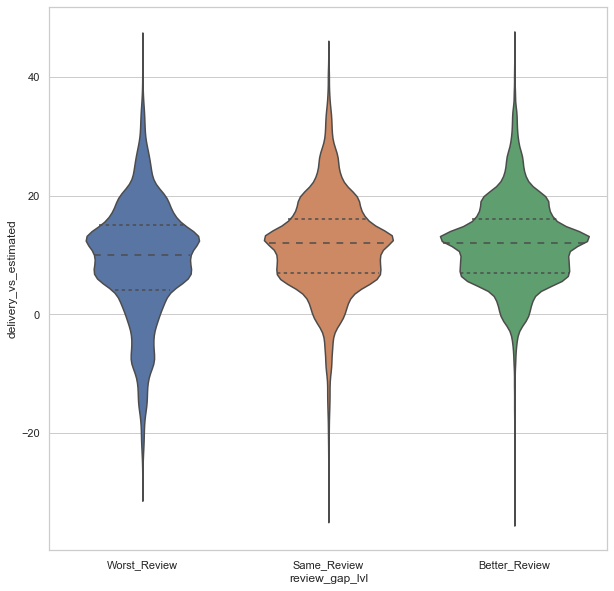

In [299]:
fig, ax = plt.subplots(figsize=(10, 10))
ax = sns.violinplot(x='review_gap_lvl',
                    y='delivery_vs_estimated',
                    order=['Worst_Review', 'Same_Review', 'Better_Review'],
                    data=df_orders,
                    split=True,
                    inner='quartile')

On observe une distribution des notes défavorables principalement lorsque la commande est arrivée en retard.

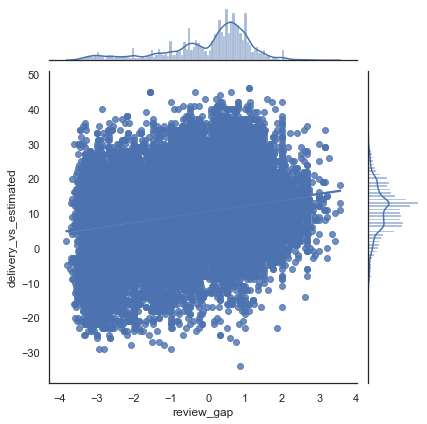

In [300]:
# évolution des écarts de notation en fonction de l'écart de délai de livraison
with sns.axes_style('white'):
    sns.jointplot(data=df_orders[df_orders['review_gap'] != 0],
                  x='review_gap',
                  y='delivery_vs_estimated',
                  kind='reg')
plt.show()

corrélation entre la dépense et l'écart d'évaluation

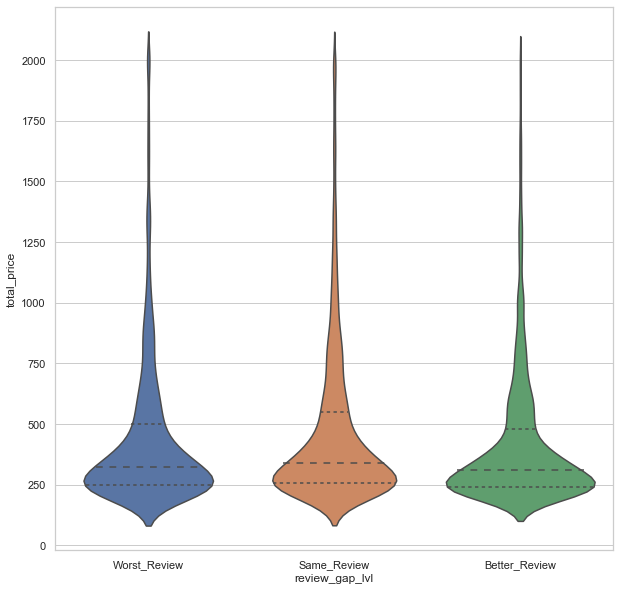

5:80: E501 line too long (80 > 79 characters)


In [301]:
fig, ax = plt.subplots(figsize=(10, 10))
ax = sns.violinplot(x='review_gap_lvl',
                    y='total_price',
                    order=['Worst_Review', 'Same_Review', 'Better_Review'],
                    data=df_orders[df_orders['total_price'].between(200, 2000)],
                    split=True,
                    inner='quartile')

## 9. Popularité des vendeurs et des produits

Au sein de ce dataset consolidé il est possible de déterminer la popularité des vendeurs et celle des produits.

### Popularité des vendeurs

In [302]:
# nb de vendeurs référencés
df_orders['seller_id'].unique().size

2836

In [303]:
# compter le nb de vente, le revenu, et le prix moyen par vendeur
df_sellers_sales = df_orders.groupby(
    'seller_id',
    as_index=False).agg({'order_id': ['count'],
                         'total_price': ['sum'],
                         'product_price': ['mean'],
                         'charm_price': ['mean']})

In [304]:
# identifier la catégorie principale des produits de chaque vendeur
df_sellers_best_cat = pd.DataFrame(df_orders.groupby(
        'seller_id').product_cat.apply(lambda x: x.mode()))
df_sellers_best_cat.columns = ['seller_main_product_cat']

In [305]:
# aggréger aux ventes la catégorie principale du vendeur
df_sellers_sales = df_sellers_sales.merge(
    df_sellers_best_cat,
    how='left',
    left_on=['seller_id'],
    right_on=['seller_id'])

C:\Users\etien\Anaconda3\lib\site-packages\pandas\core\reshape\merge.py:617: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


In [306]:
# renommer et épurer les colonnes
df_sellers_sales.columns = ['seller_id',
                            'to_drop',
                            'seller_sales_count',
                            'seller_revenue',
                            'mean_seller_product_price',
                            'mean_seller_charm_price',
                            'seller_main_product_cat']
df_sellers_sales = df_sellers_sales.drop(columns=['to_drop'])

In [307]:
# afficher les 10 plus gros vendeurs
df_sellers_sales = df_sellers_sales.sort_values(by='seller_revenue',
                                                ascending=False)
df_sellers_sales[:10]

,seller_id,seller_sales_count,seller_revenue,mean_seller_product_price,mean_seller_charm_price,seller_main_product_cat
1464,7c67e1448b00f6e969d365cea6b010ab,1139,304313.45,139.417954,0.949078,Furniture
973,53243585a1d6dc2643021fd1853d8905,392,256589.22,541.475867,0.372449,Telephony
830,4869f7a5dfa277a7dca6462dcf3b52b2,1086,221828.02,199.042762,0.645488,Watches Gifts Toys
188,1025f0e2d44d7041d6cf58b6550e0bfa,1276,200009.29,96.932547,0.094828,Furniture
854,4a3ca9315b744ce9f8e9374361493884,1673,193066.87,101.504764,0.719665,Home Accessories
1734,955fee9216a65b617aa5c0531780ce60,1446,191328.81,89.269191,0.470954,Furniture
2872,fa1c13f2614d7b5c4749cbc52fecda94,553,184595.29,333.807034,0.877034,Watches Gifts Toys
356,1f50f920176fa81dab994f9023523100,1684,163236.44,55.085748,0.851544,Construction & Tools
1487,7e93a43ef30c4f03f38b393420bc753a,309,159069.28,513.758188,0.724919,Watches Gifts Toys
2511,da8622b14eb17ae2831f4ac5b9dab84a,1249,152104.66,102.703507,0.991193,Home Accessories


Au passage et à destination du vendeur en tant que client de la plateforme Olist, on observe des stratégies de Charm Price différentes selon les vendeurs. Une idée d'action marketing consisterait à proposer aux vendeurs de les accompagner dans l'amélioration de leur rentabilité, et en conséquence, celle du site. L'exemple du Charm Price serait d'affiner l'observation selon laquelle les prix bas ont intérêt à être en Charm Price afin d'accroitre le revenu global.

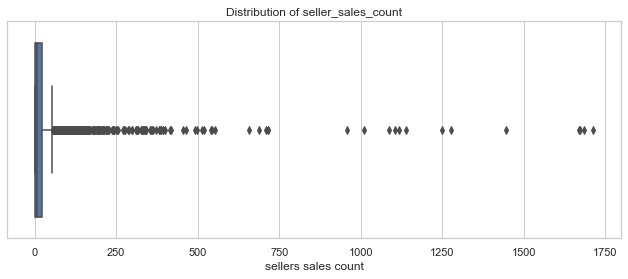

Nb de ventes moyenne par vendeur référencé 34


In [308]:
# afficher la distribution des ventes par vendeur
distribution(df_sellers_sales,
             'seller_sales_count',
             'sellers sales count',
             'box')
print('Nb de ventes moyenne par vendeur référencé ' +
      str(round(df_sellers_sales['seller_sales_count'].mean())))

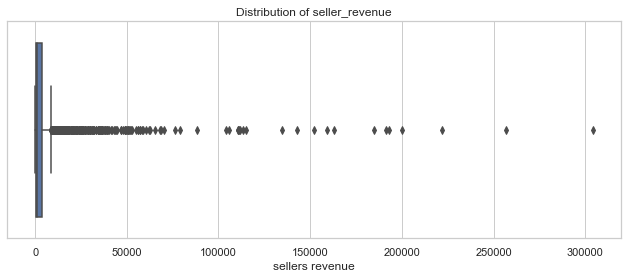

revenu moyen par vendeur référencé 4939


In [309]:
# afficher la distribution des revenus par vendeur
distribution(df_sellers_sales,
             'seller_revenue',
             'sellers revenue',
             'box')
print('revenu moyen par vendeur référencé ' +
      str(round(df_sellers_sales['seller_revenue'].mean())))

In [310]:
# compter le nb de vente par produit
df_product_sales = df_orders.groupby(
    'most_important_product',
    as_index=False).agg({'order_id': ['count'],
                         'total_price': ['sum']})
df_product_sales.columns = ['product_id',
                            'product_sales_count',
                            'product_revenue']

In [311]:
# afficher les 10 produits générant le plus gros revenu
df_product_sales = df_product_sales.sort_values(by='product_revenue',
                                                ascending=False)
df_product_sales[:10]

,product_id,product_sales_count,product_revenue
10005,5769ef0a239114ac3a854af00df129e4,8,107520.00
21263,bb50f2e236e5eea0100680137654686c,187,74460.00
7634,422879e10f46682990de24d770e7f83d,437,54173.85
12417,6cdd53843498f92890544667809f1595,139,53675.00
18819,a62e25e09e05e6faf31d90c6ec1aa3d1,217,52551.00
19531,aca2eb7d00ea1a7b8ebd4e68314663af,515,52529.80
24304,d5991653e037ccb7af6ed7d94246b249,94,48981.73
7143,3dd2a17168ec895c781a9191c1e95ad7,265,48427.70
23861,d1c427060a0f73f6b889a5c7c61f2ac4,312,47583.59
24371,d6160fb7873f184099d9bc95e30376af,33,45949.35


In [312]:
# afficher les 10 produits les plus fréquemment vendus
df_product_sales = df_product_sales.sort_values(by='product_sales_count',
                                                ascending=False)
df_product_sales[:10]

,product_id,product_sales_count,product_revenue
19531,aca2eb7d00ea1a7b8ebd4e68314663af,515,52529.80
7634,422879e10f46682990de24d770e7f83d,437,54173.85
17426,99a4788cb24856965c36a24e339b6058,421,40937.86
6528,389d119b48cf3043d311335e499d9c6b,354,30750.89
6276,368c6c730842d78016ad823897a372db,341,30942.50
9562,53759a2ecddad2bb87a079a1f1519f73,327,28469.50
23861,d1c427060a0f73f6b889a5c7c61f2ac4,312,47583.59
9584,53b36df67ebb7c41585e8d54d6772e08,309,43311.53
2469,154e7e31ebfa092203795c972e5804a6,267,6824.99
7143,3dd2a17168ec895c781a9191c1e95ad7,265,48427.70


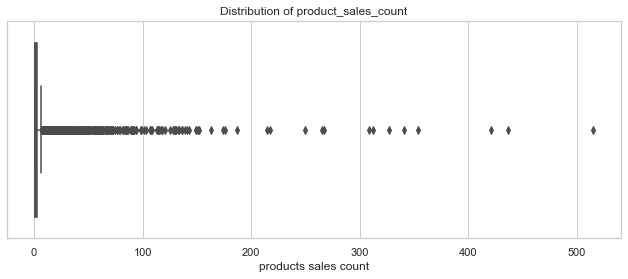

Nb de ventes moyenne par produit référencé 3


In [313]:
# afficher la distribution des quantités vendues par produit
distribution(df_product_sales,
             'product_sales_count',
             'products sales count',
             'box')
print('Nb de ventes moyenne par produit référencé ' +
      str(round(df_product_sales['product_sales_count'].mean())))

In [314]:
# aggréger aux commandes les nouvelles données vendeurs
df_orders = df_orders.merge(
    df_sellers_sales,
    how='left',
    left_on=['seller_id'],
    right_on=['seller_id'])

In [315]:
# aggréger aux commandes les nouvelles données produit
df_orders = df_orders.merge(
    df_product_sales,
    how='left',
    left_on=['most_important_product'],
    right_on=['product_id'])
df_orders = df_orders.drop(columns=['product_id'])

Une idée de feature pertinente si elle peut être valorisée sur la market place, est de déterminer les rangs des vendeurs et des produits par catégorie et non sur l'ensemble des données. Cela impliquerait néanmoins une actualisation dynamique. Le jeu de données étant tronqué par ailleurs, il est difficile d'obtenir des informations pertinentes sur cet axe.

# 10. Données consolidées et Orientation Retenue

Du fait d'être marginales, les commandes multiples ne permettent pas une approche RFM (Recency et Frequency sont affectés).
Nous avons retenu les commandes mono-produits et il reste donc à choisir de retenir une commande par client, en partant du principe que l'on ne peut pas reconstruire une liste de clients ayant fait une seule commande parmis les 97 %, d'autant qu'on ne sait pas quel est l'équilibre des données initiales.  <br/>
Nous allons consolider sur une simplification à la commande la plus récente.  <br/>

D'autre part, L'EDA a révélé de nombreux features et leurs dérivés, nous allons tenter de construire une méthode systématique permettant de déduire une pré-selection de ces features. Il s'agira des les catégoriser afin appliquer des traitements systématiques et de tester ultérieurement leur pertinence dans l'approche de segmentation. <br/>

## 10.1. Simplification à la commande la plus récente

In [316]:
df_orders.columns

Index(['order_id', 'customer_id', 'order_purchase_timestamp',
       'order_purchase_year', 'order_purchase_month', 'order_purchase_day',
       'order_purchase_dayofweek', 'order_purchase_hour',
       'order_purchase_month_label', 'order_purchase_dayofweek_label',
       'time_zone_hour', 'time_zone_day', 'purchase_time_zone_cat',
       'estimated_delivery_time', 'effective_delivery_time',
       'delivery_vs_estimated', 'delivery_vs_estimated_lvl', 'items_qty',
       'products_qty', 'most_important_product', 'total_price',
       'total_freight', 'freight_percentage', 'freight_percentage_lvl',
       'charm_price', 'total_price_class', 'charmed_price_cat', 'seller_id',
       'product_price', 'product_freight', 'product_name_length',
       'product_description_length', 'product_photos_qty', 'product_weight_g',
       'product_size', 'product_qlty_index', 'product_qlty_index_lvl',
       'product_density', 'product_cat', 'main_payment_type',
       'main_payment_value', 'payment_s

In [317]:
# contrôler l'aggrégation sur la base des coûts
cols = ['total_price',
        'total_freight',
        'payment_total']
df_orders[cols].sample(3)

,total_price,total_freight,payment_total
80097,216.0,31.04,247.04
23949,90.0,12.58,102.58
12955,67.9,17.69,85.59


In [318]:
# trier par date la plus récente
df_orders = df_orders.sort_values(by='order_purchase_timestamp',
                                  ascending=False)
df_orders.head(3)

,order_id,customer_id,order_purchase_timestamp,order_purchase_year,order_purchase_month,order_purchase_day,order_purchase_dayofweek,order_purchase_hour,order_purchase_month_label,order_purchase_dayofweek_label,time_zone_hour,time_zone_day,purchase_time_zone_cat,estimated_delivery_time,effective_delivery_time,delivery_vs_estimated,delivery_vs_estimated_lvl,items_qty,products_qty,most_important_product,total_price,total_freight,freight_percentage,freight_percentage_lvl,charm_price,total_price_class,charmed_price_cat,seller_id,product_price,product_freight,product_name_length,product_description_length,product_photos_qty,product_weight_g,product_size,product_qlty_index,product_qlty_index_lvl,product_density,product_cat,main_payment_type,main_payment_value,payment_sequence_size,payment_installments_size,payment_total,payment_sequence_size_cat,payment_installment_size_cat,main_payment_type_cat,payment_lvl,product_price_lvl,seller_city,seller_state,seller_lat,seller_lng,customer_unique_id,customer_city,customer_state,order_count,customer_lat,customer_lng,cust_sell_dist,cust_sell_dist_lvl,review_score,review_answer_delay,review_answer_delay_lvl,product_review_count,product_review_mean,product_review_mean_lvl,customer_review_count,customer_review_mean,review_gap,review_gap_lvl,seller_sales_count,seller_revenue,mean_seller_product_price,mean_seller_charm_price,seller_main_product_cat,product_sales_count,product_revenue
87817,35a972d7f8436f405b56e36add1a7140,898b7fee99c4e42170ab69ba59be0a8b,2018-08-29 15:00:37,2018,8,29,2,15,Aug,Wed,PM,WD,PM-WD,6,1,5,Later_Delivery,single_item,single_product,d04857e7b4b708ee8b8b9921163edba3,84.99,8.76,9.344000,Low_FreightCost,1,D,Charmed_Price,9f505651f4a6abe901a56cdc21508025,84.99,8.76,33.0,1127.0,2,450.0,1280.0,0.493951,High_QltyIdx,4.484476e+10,Electronics Computers & Accessories,credit_card,93.75,1.0,1.0,93.75,mono_payment,single_payment,Credit_Card_PayType,UnderMed_Payment,Light_Price,Sao Paulo,SP,-23.589847,-46.632614,24ac2b4327e25baf39f2119e4228976a,Limeira,SP,1.0,-22.573479,-47.408479,138.098069,Near_Dist,5,9,Late_Answer,82,4.353659,Medium_Score,1,5.0,0.646341,Better_Review,416,28033.08,61.470962,0.985577,Electronics Computers & Accessories,82,5931.16
69497,03ef5dedbe7492bdae72eec50764c43f,496630b6740bcca28fce9ba50d8a26ef,2018-08-29 14:52:00,2018,8,29,2,14,Aug,Wed,PM,WD,PM-WD,4,1,3,Later_Delivery,single_item,single_product,c7f27c5bef2338541c772b5776403e6a,24.90,8.33,25.067710,High_FreightCost,1,C,Charmed_Price,7d7866a99a8656a42c7ff6352a433410,24.90,8.33,54.0,429.0,1,450.0,4788.0,0.329824,Low_QltyIdx,1.677474e+11,Supplies,credit_card,33.23,1.0,1.0,33.23,mono_payment,single_payment,Credit_Card_PayType,Light_Payment,Light_Price,Sao Paulo,SP,-23.557955,-46.639347,b701bebbdf478f5500348f03aff62121,Sao Caetano Do Sul,SP,1.0,-23.626539,-46.565188,10.736211,Near_Dist,3,0,Early_Answer,1,3.000000,Low_Score,1,3.0,0.000000,Same_Review,5,147.89,29.578000,0.600000,Supplies,1,24.90
31504,168626408cb32af0ffaf76711caae1dc,6e353700bc7bcdf6ebc15d6de16d7002,2018-08-29 14:18:28,2018,8,29,2,14,Aug,Wed,PM,WD,PM-WD,12,1,11,Nominal_Delivery,single_item,single_product,bdcf6a834e8faa30dac3886c7a58e92e,45.90,15.39,25.110132,High_FreightCost,1,C,Charmed_Price,2a84855fd20af891be03bc5924d2b453,45.90,15.39,26.0,394.0,1,1614.0,13888.0,0.259380,Low_QltyIdx,1.745149e+12,Health Beauty Baby,voucher,61.29,1.0,1.0,61.29,mono_payment,single_payment,Other_PayType,Light_Payment,Light_Price,Belo Horizonte,MG,-19.917826,-43.942418,7febafa06d9d8f232a900a2937f04338,Paracatu,MG,1.0,-17.231034,-46.868966,429.397609,AroundMed_Dist,5,2,Nominal_Answer,29,4.172414,Medium_Score,1,5.0,0.827586,Better_Review,156,15443.60,93.937179,0.858974,Supplies,29,1146.90


In [319]:
# observer le nb de commandes multiples avant simplification
df_orders[df_orders['order_count'] > 1].shape[0]

6277

In [320]:
# ne garder que la dernière commande et surveiller la taille de dataset
print(df_orders.shape)
df_orders.drop_duplicates(subset='customer_unique_id',
                          keep='first',
                          inplace=True)
print(df_orders.shape)

(99102, 78)
(87086, 78)


In [321]:
# observer le nb de commandes multiples après simplification
df_orders[df_orders['order_count'] > 1].shape[0]

2911

In [322]:
# conditionner les données "customer-centric"
data = df_orders.copy()

In [323]:
# passer le customer_unique_id en index
data = data.rename(index=data['customer_unique_id'])

Le dataset customer-centric présente des features de différentes nature : numériques, catégoriels et ordinaux (i.e. l'ordre importe). Se pose la question du préprocessing adapté à ces features selon leur nature.

In [324]:
# features ordinaux
data.select_dtypes(include='category').columns

Index(['delivery_vs_estimated_lvl', 'freight_percentage_lvl',
       'total_price_class', 'product_photos_qty', 'product_qlty_index_lvl',
       'payment_lvl', 'product_price_lvl', 'cust_sell_dist_lvl',
       'review_answer_delay_lvl', 'product_review_mean_lvl', 'review_gap_lvl'],
      dtype='object')

On aurait pu généraliser les features en niveaux, homogénéiser en 3 niveaux, y compris pour la taille du nom et decription de produits. Attendu qu'on souhaite avant tout centrer sur les caractéristiques des clients, ce sera une action d'amélioration à envisager ultérieurement.

In [325]:
# autre façon de grouper les features ordinaux
lvl_features = data.columns[data.columns.str.contains('_lvl')].tolist()

In [326]:
# projeter et décrire les features ordinaux
data_lvl = data.filter(lvl_features)
data_lvl.describe()

,delivery_vs_estimated_lvl,freight_percentage_lvl,product_qlty_index_lvl,payment_lvl,product_price_lvl,cust_sell_dist_lvl,review_answer_delay_lvl,product_review_mean_lvl,review_gap_lvl
count,87086,87086,87086,87086,87086,87086,87086,87086,87086
unique,3,3,2,4,4,3,3,3,3
top,Later_Delivery,Low_FreightCost,High_QltyIdx,Light_Payment,Light_Price,Near_Dist,Early_Answer,Low_Score,Better_Review
freq,31310,29223,43960,23538,52182,29374,48410,29955,39554


In [327]:
# features catégoriels
cat_features = data.columns[data.columns.str.contains('_cat')].tolist()

In [328]:
# projeter et décrire les features catégoriels
data_cat = data.filter(cat_features)
data_cat.describe()

,purchase_time_zone_cat,charmed_price_cat,product_cat,payment_sequence_size_cat,payment_installment_size_cat,main_payment_type_cat,seller_main_product_cat
count,87086,87086,87086,87086,87086,87086,87086
unique,5,2,15,2,2,2,15
top,PM-WD,Charmed_Price,Health Beauty Baby,mono_payment,single_payment,Credit_Card_PayType,Health Beauty Baby
freq,22117,60779,13409,84471,84471,65671,12469


In [329]:
# definir le type catégoriel
for i in cat_features:
    data[i] = data[i].astype('category')

In [330]:
# features numériques
data.select_dtypes(include='number').columns

Index(['order_purchase_year', 'order_purchase_month', 'order_purchase_day',
       'order_purchase_dayofweek', 'order_purchase_hour',
       'estimated_delivery_time', 'effective_delivery_time',
       'delivery_vs_estimated', 'total_price', 'total_freight',
       'freight_percentage', 'charm_price', 'product_price', 'product_freight',
       'product_name_length', 'product_description_length', 'product_weight_g',
       'product_size', 'product_qlty_index', 'product_density',
       'main_payment_value', 'payment_sequence_size',
       'payment_installments_size', 'payment_total', 'seller_lat',
       'seller_lng', 'order_count', 'customer_lat', 'customer_lng',
       'cust_sell_dist', 'review_score', 'review_answer_delay',
       'product_review_count', 'product_review_mean', 'customer_review_count',
       'customer_review_mean', 'review_gap', 'seller_sales_count',
       'seller_revenue', 'mean_seller_product_price',
       'mean_seller_charm_price', 'product_sales_count', 'produc

In [331]:
# features numériques
data.select_dtypes(include='number').columns.size

43

In [332]:
# autres features
data.select_dtypes(include='object').columns

Index(['order_id', 'customer_id', 'order_purchase_month_label',
       'order_purchase_dayofweek_label', 'time_zone_hour', 'time_zone_day',
       'items_qty', 'products_qty', 'most_important_product', 'seller_id',
       'main_payment_type', 'seller_city', 'seller_state',
       'customer_unique_id', 'customer_city', 'customer_state'],
      dtype='object')

In [333]:
# feature temporel
data.select_dtypes(include='datetime64[ns]').columns

Index(['order_purchase_timestamp'], dtype='object')

## 10.2. Pré-sélection de features 

### Analyse multi-variée
L'analyse des corrélation entre features a ici pour but de définir des subsets de features dont on suspecte la possible redondance en vue d'opérer une segmentation. On opte en vertu de la théorie et d'observations réalisées (pearson, kendall, spearman), pour exploiter une corrélation de rang, celle de Spearman, afin de construire ces listes. <br/> 
Les observations peuvent être complétés par des pair-plot pour un aperçu plus qualitatif des features, mais la finalité est de ne retenir si possible qu'un feature pour exprimer chacune des caractéristiques de segmentation. 

In [334]:
# sur l'étendue des features dont le type le permet (number)
cols = data.select_dtypes(include='number').columns
len(cols)

43

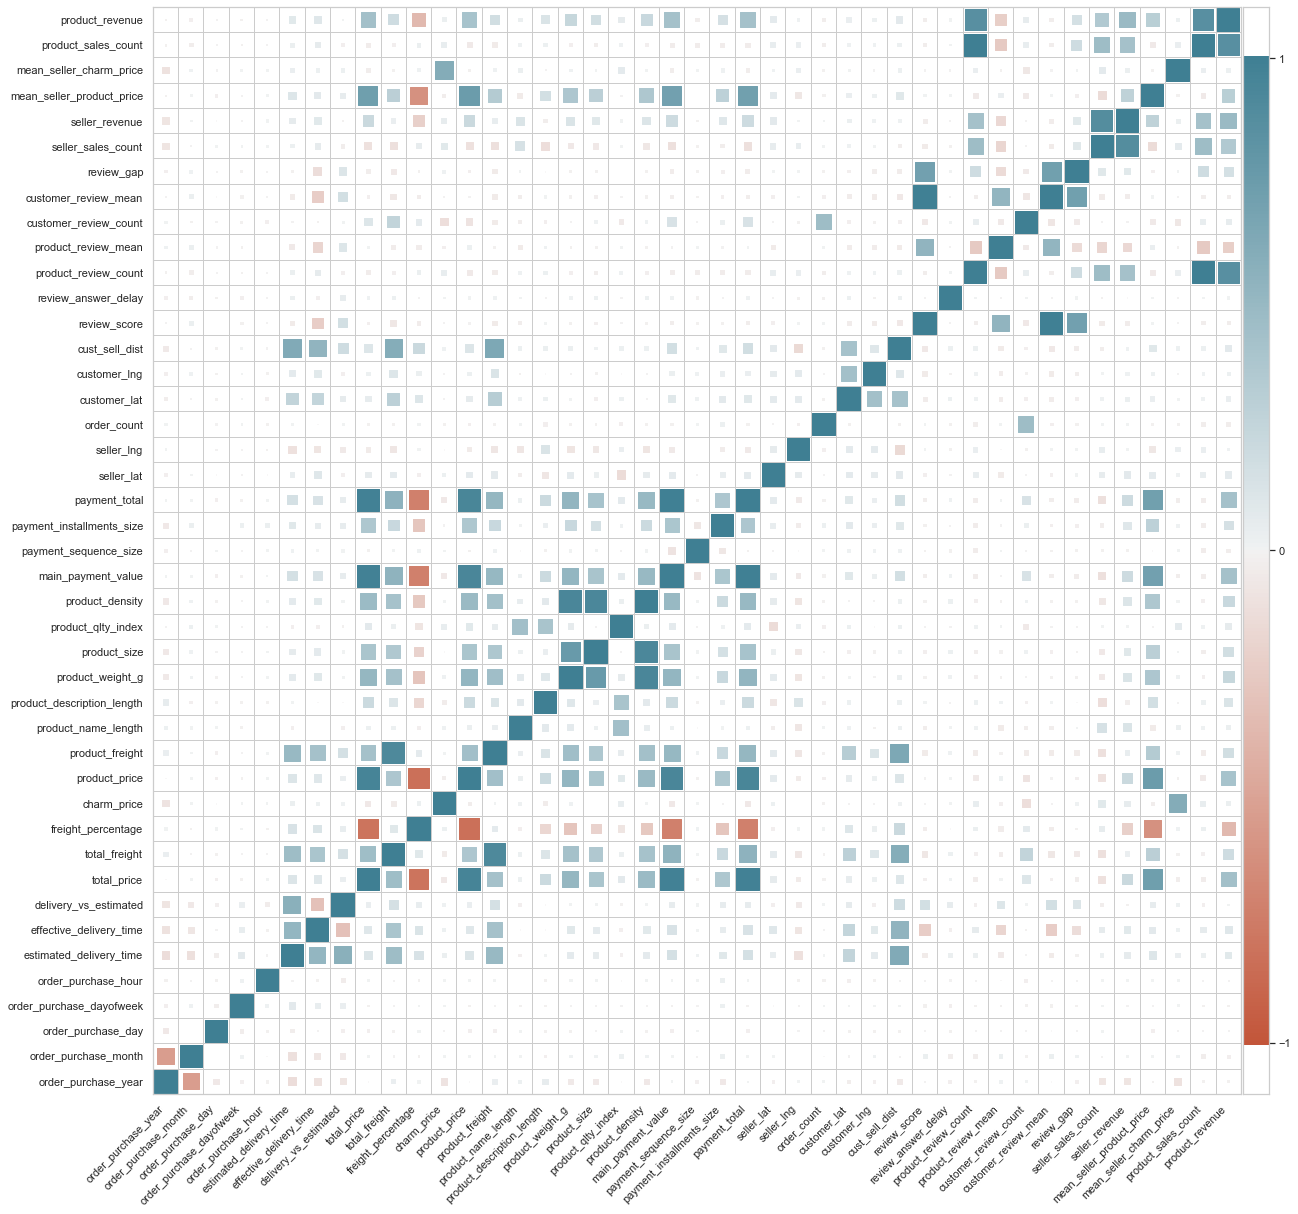

In [335]:
# calculer les corrélations entre features
corr = data[cols].corr(method='spearman')
corr = pd.melt(corr.reset_index(), id_vars='index')
corr.columns = ['x', 'y', 'value']
# visualiser les corrélations entre features
heatmap(
    x=corr['x'],
    y=corr['y'],
    size=corr['value'].abs(),
    color=corr['value']
)

In [336]:
# echantillonner (10%) les données pour produire des pairplots
data_sample = pd.DataFrame(data).sample(
    int(data.shape[0]/10),
    random_state=42)
data_sample.shape

(8708, 78)

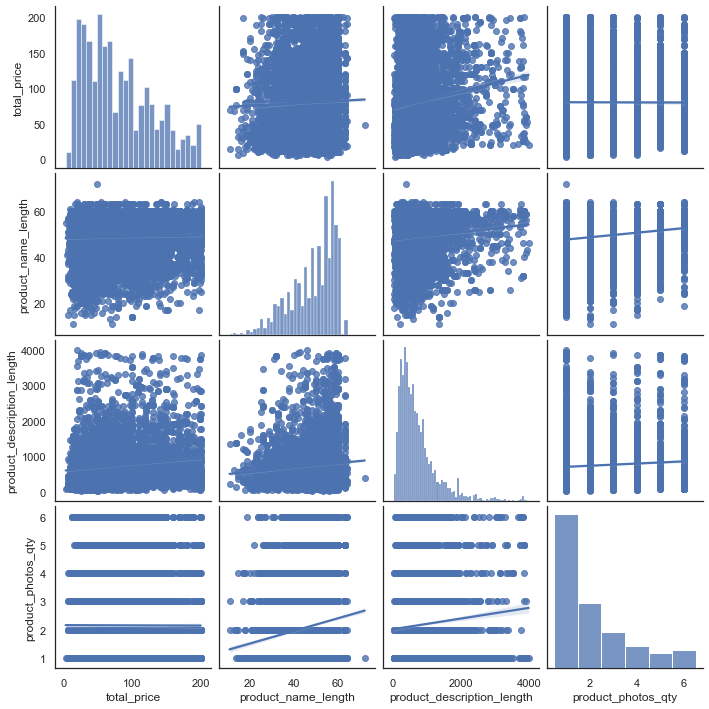

4:80: E501 line too long (113 > 79 characters)


In [337]:
# évolution des dépense en fonction de la description du produit
with sns.axes_style('white'):
    sns.pairplot(data_sample[data_sample['total_price'] <= 200],
                 vars=['total_price', 'product_name_length', 'product_description_length', 'product_photos_qty'],
                 kind='reg')
plt.show()

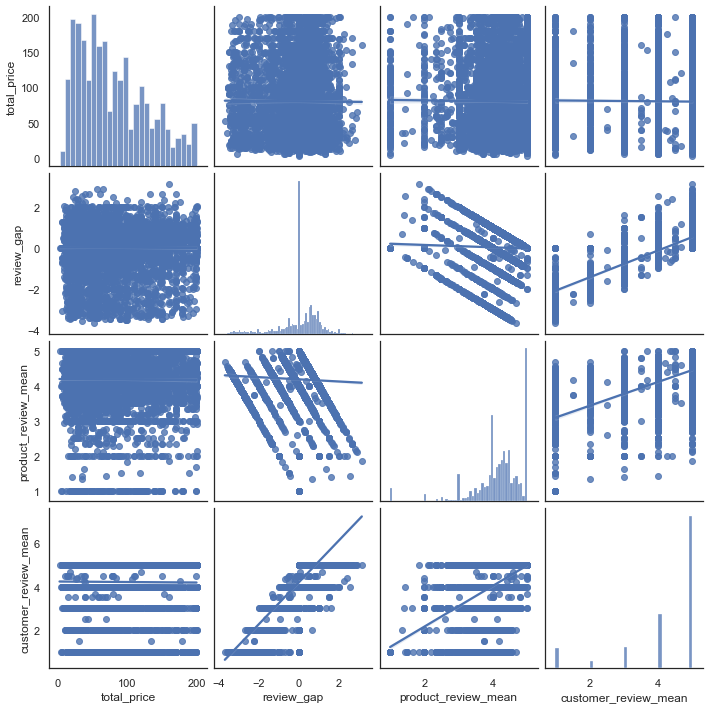

4:80: E501 line too long (99 > 79 characters)


In [338]:
# évolution des dépense en fonction de la note donnée au produit
with sns.axes_style('white'):
    sns.pairplot(data_sample[data_sample['total_price'] <= 200],
                 vars=['total_price', 'review_gap', 'product_review_mean', 'customer_review_mean'],
                 kind='reg')
plt.show()

In [339]:
# retirer les features inutiles
useless_features = ['order_id',
                    'customer_id',
                    'order_purchase_timestamp',
                    'order_purchase_month_label',
                    'order_purchase_day',
                    'order_purchase_dayofweek_label',
                    'order_purchase_dayofweek',
                    'order_purchase_hour',
                    'order_count',
                    'time_zone_hour',
                    'time_zone_day',
                    'estimated_delivery_time',
                    'most_important_product',
                    'seller_id',
                    'seller_city',
                    'customer_city',
                    'seller_lat',
                    'seller_lng',
                    'customer_lat',
                    'customer_lng',
                    'product_review_count',
                    'customer_review_count',
                    'review_score',
                    'charm_price',
                    'main_payment_value',
                    'payment_total',
                    'product_price',
                    'total_freight',
                    'product_freight']

In [340]:
# retirer les colonnes obsolètes
data.shape
# data = data.drop(columns=useless_features)
data.shape

(87086, 78)

In [341]:
data.select_dtypes(include='number').columns

Index(['order_purchase_year', 'order_purchase_month', 'order_purchase_day',
       'order_purchase_dayofweek', 'order_purchase_hour',
       'estimated_delivery_time', 'effective_delivery_time',
       'delivery_vs_estimated', 'total_price', 'total_freight',
       'freight_percentage', 'charm_price', 'product_price', 'product_freight',
       'product_name_length', 'product_description_length', 'product_weight_g',
       'product_size', 'product_qlty_index', 'product_density',
       'main_payment_value', 'payment_sequence_size',
       'payment_installments_size', 'payment_total', 'seller_lat',
       'seller_lng', 'order_count', 'customer_lat', 'customer_lng',
       'cust_sell_dist', 'review_score', 'review_answer_delay',
       'product_review_count', 'product_review_mean', 'customer_review_count',
       'customer_review_mean', 'review_gap', 'seller_sales_count',
       'seller_revenue', 'mean_seller_product_price',
       'mean_seller_charm_price', 'product_sales_count', 'produc

In [342]:
# sortie du type number mois et année - pour découpages temporels
for i in ['order_purchase_year', 'order_purchase_month']:
    data[i] = data[i].astype('object')

In [343]:
data.select_dtypes(include='object').columns

Index(['order_id', 'customer_id', 'order_purchase_year',
       'order_purchase_month', 'order_purchase_month_label',
       'order_purchase_dayofweek_label', 'time_zone_hour', 'time_zone_day',
       'items_qty', 'products_qty', 'most_important_product', 'seller_id',
       'main_payment_type', 'seller_city', 'seller_state',
       'customer_unique_id', 'customer_city', 'customer_state'],
      dtype='object')

In [344]:
data.select_dtypes(include='number').columns.size

41

In [345]:
# exporter les données "brutes" sans preprocessing
data.to_csv('Data/data.csv', index=False)

In [346]:
data.shape

(87086, 78)